In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import time

In [5]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [8]:
###### PARAMS ######
learning_rate = 0.00025
num_episodes = 100000
gamma=0.99
#gamma=0.85
egreedy = 1.0
egreedy_final = 0.1
egreedy_decay = 1000000

report_interval=10

score_to_solve = 195

hidden_layer_size=64

replay_memory_size=1000000

batch_size=32

update_target_frequency = 10000

clip_error=False

In [9]:
env = gym.make('Breakout-ramDeterministic-v4')

In [10]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
env = gym.wrappers.Monitor(env, '../mp4/breakout_DQN_p2',video_callable=lambda episode_id: episode_id%100==0,force=True)

In [11]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [12]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
        
    
    def push(self, state,
             action, new_state,
             reward, done):
        
            transition=(state,action,new_state,reward,done)
            
            if self.position>=len(self.memory):
                self.memory.append(transition)
            else:
                self.memory[self.position]=transition
                
            self.position=(self.position+1)%self.capacity
        
    
    def sample(self,batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        
        return output2

In [15]:
class QNet_Agent():
    def __init__(self):
        
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state)
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self):
        
        if len(memory)<batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor(reward).to(device)
        
        #the view call below is to transform into column vector
        #so that it can be used in the gather call
        #i.e. we will use it to pick out from the computed value
        #tensor only values indexed by selected action
        action=(torch.Tensor(action).view(-1,1).long()).to(device)
        #print('action: ')
        #print(action)
        #print('contiguous?', action.is_contiguous())
        done=torch.Tensor(done).to(device)
        
        #print('shape of: state, new state, reward, action, done:')
        #print(state.shape)
        #print(new_state.shape)
        #print(reward.shape)
        #print(action.shape)
        #print(done.shape)
        
        
        self.nn.eval()
        self.target_nn.eval()
            
        new_state_values=self.target_nn(new_state).detach()
        #print('shape of: new_state_values')
        #print(new_state_values.shape)
        
        max_new_state_values=torch.max(new_state_values,dim=1)[0]
        #print('shape of: max_new_state_values')
        #print(max_new_state_values.shape)
        target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
        
        #print('shape of: target_value')
        #print(target_value.shape)
        self.nn.train()
        
        #this will select only the values of the desired actions
        predicted_value=torch.gather(self.nn(state),1,action)
        #print('shape of: predicted_value')
        #print(predicted_value.shape)
        
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.clamp_(-1.0,1.0)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            #print("***********************")
            #print("UPDATING TARGET NETWORK")
            #print("update counter: {}".format(self.update_target_counter))
            #print("***********************")
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter+=1
        

In [16]:
a=torch.randn([3,3])
print(a)

tensor([[ 1.4143, -0.9963, -0.7530],
        [-0.7036, -0.6273,  0.5957],
        [-1.3492,  0.6833, -0.1627]])


In [17]:
a.clamp_(-1.0,1.0)

tensor([[ 1.0000, -0.9963, -0.7530],
        [-0.7036, -0.6273,  0.5957],
        [-1.0000,  0.6833, -0.1627]])

In [18]:
a

tensor([[ 1.0000, -0.9963, -0.7530],
        [-0.7036, -0.6273,  0.5957],
        [-1.0000,  0.6833, -0.1627]])

In [19]:
memory=ExperienceReplay(replay_memory_size)

In [20]:
qnet_agent=QNet_Agent()

In [21]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [22]:
%%time

steps_total=np.full([num_episodes],-999,dtype=np.int32)
reward_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    reward_total[i_episode]=0
    
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        memory.push(state, action, new_state,
                     reward, done)
        
        reward_total[i_episode]+=reward
        
        qnet_agent.optimize()
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(reward_total[i_episode-100:i_episode])/100
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(reward_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(reward_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: 1.7
Average over all episodes so far: 1.7
epsilon: 0.9980096041812142
**** Episode  20 **** 
Recent average reward: 1.1
Average over all episodes so far: 1.4
epsilon: 0.996343547758414
**** Episode  30 **** 
Recent average reward: 1.0
Average over all episodes so far: 1.2666666666666666
epsilon: 0.9948640106516515
**** Episode  40 **** 
Recent average reward: 1.3
Average over all episodes so far: 1.275
epsilon: 0.9932198679886052
**** Episode  50 **** 
Recent average reward: 0.9
Average over all episodes so far: 1.2
epsilon: 0.991603710679833
**** Episode  60 **** 
Recent average reward: 1.6
Average over all episodes so far: 1.2666666666666666
epsilon: 0.9899682280994537
**** Episode  70 **** 
Recent average reward: 1.0
Average over all episodes so far: 1.2285714285714286
epsilon: 0.9884121456695311
**** Episode  80 **** 
Recent average reward: 1.4
Average over all episodes so far: 1.25
epsilon: 0.9866220243159949
**** Episode  90 **** 
Rec

**** Episode  560 **** 
Recent average reward: 1.0
Reward over last 100: 0.94
Average over all episodes so far: 1.1089285714285715
epsilon: 0.9146069796123057
**** Episode  570 **** 
Recent average reward: 0.9
Reward over last 100: 0.93
Average over all episodes so far: 1.105263157894737
epsilon: 0.9131777849562623
**** Episode  580 **** 
Recent average reward: 0.5
Reward over last 100: 0.88
Average over all episodes so far: 1.0948275862068966
epsilon: 0.9119459414076029
**** Episode  590 **** 
Recent average reward: 1.1
Reward over last 100: 0.89
Average over all episodes so far: 1.0949152542372882
epsilon: 0.9104047087536039
**** Episode  600 **** 
Recent average reward: 1.4
Reward over last 100: 0.95
Average over all episodes so far: 1.1
epsilon: 0.9089383939748418
**** Episode  610 **** 
Recent average reward: 1.1
Reward over last 100: 1.0
Average over all episodes so far: 1.1
epsilon: 0.9075223747036858
**** Episode  620 **** 
Recent average reward: 1.1
Reward over last 100: 0.98


**** Episode  1090 **** 
Recent average reward: 0.7
Reward over last 100: 1.14
Average over all episodes so far: 1.0770642201834861
epsilon: 0.8422222772430379
**** Episode  1100 **** 
Recent average reward: 0.8
Reward over last 100: 1.04
Average over all episodes so far: 1.0745454545454545
epsilon: 0.8409578664768228
**** Episode  1110 **** 
Recent average reward: 1.0
Reward over last 100: 1.0
Average over all episodes so far: 1.0738738738738738
epsilon: 0.839682295293027
**** Episode  1120 **** 
Recent average reward: 1.9
Reward over last 100: 1.04
Average over all episodes so far: 1.08125
epsilon: 0.8380944248183593
**** Episode  1130 **** 
Recent average reward: 1.1
Reward over last 100: 1.09
Average over all episodes so far: 1.08141592920354
epsilon: 0.8367162146769433
**** Episode  1140 **** 
Recent average reward: 1.0
Reward over last 100: 1.12
Average over all episodes so far: 1.080701754385965
epsilon: 0.8354067616348648
**** Episode  1150 **** 
Recent average reward: 1.6
Rewa

**** Episode  1610 **** 
Recent average reward: 0.9
Reward over last 100: 1.01
Average over all episodes so far: 1.112422360248447
epsilon: 0.7750000489049539
**** Episode  1620 **** 
Recent average reward: 1.2
Reward over last 100: 1.05
Average over all episodes so far: 1.112962962962963
epsilon: 0.7737949009379761
**** Episode  1630 **** 
Recent average reward: 0.7
Reward over last 100: 1.03
Average over all episodes so far: 1.1104294478527608
epsilon: 0.7726679118268698
**** Episode  1640 **** 
Recent average reward: 1.5
Reward over last 100: 1.06
Average over all episodes so far: 1.1128048780487805
epsilon: 0.7713829995470388
**** Episode  1650 **** 
Recent average reward: 1.0
Reward over last 100: 1.0
Average over all episodes so far: 1.112121212121212
epsilon: 0.7701621937581142
**** Episode  1660 **** 
Recent average reward: 0.8
Reward over last 100: 0.98
Average over all episodes so far: 1.1102409638554216
epsilon: 0.7690118435430131
**** Episode  1670 **** 
Recent average rewa

**** Episode  2130 **** 
Recent average reward: 1.7
Reward over last 100: 1.31
Average over all episodes so far: 1.119718309859155
epsilon: 0.7145748717494286
**** Episode  2140 **** 
Recent average reward: 1.5
Reward over last 100: 1.32
Average over all episodes so far: 1.1214953271028036
epsilon: 0.7134628838656367
**** Episode  2150 **** 
Recent average reward: 0.7
Reward over last 100: 1.29
Average over all episodes so far: 1.1195348837209302
epsilon: 0.7124600791055932
**** Episode  2160 **** 
Recent average reward: 1.5
Reward over last 100: 1.34
Average over all episodes so far: 1.1212962962962962
epsilon: 0.7112253808954595
**** Episode  2170 **** 
Recent average reward: 1.2
Reward over last 100: 1.33
Average over all episodes so far: 1.1216589861751152
epsilon: 0.7100834574643592
**** Episode  2180 **** 
Recent average reward: 1.4
Reward over last 100: 1.36
Average over all episodes so far: 1.1229357798165138
epsilon: 0.708954019565062
**** Episode  2190 **** 
Recent average re

**** Episode  2650 **** 
Recent average reward: 1.3
Reward over last 100: 1.2
Average over all episodes so far: 1.1471698113207547
epsilon: 0.657999330926595
**** Episode  2660 **** 
Recent average reward: 1.4
Reward over last 100: 1.18
Average over all episodes so far: 1.1481203007518797
epsilon: 0.6569406956894607
**** Episode  2670 **** 
Recent average reward: 1.7
Reward over last 100: 1.2
Average over all episodes so far: 1.150187265917603
epsilon: 0.6557590090472829
**** Episode  2680 **** 
Recent average reward: 2.2
Reward over last 100: 1.31
Average over all episodes so far: 1.1541044776119402
epsilon: 0.6545565377801905
**** Episode  2690 **** 
Recent average reward: 0.8
Reward over last 100: 1.31
Average over all episodes so far: 1.1527881040892194
epsilon: 0.6535686444419563
**** Episode  2700 **** 
Recent average reward: 1.0
Reward over last 100: 1.35
Average over all episodes so far: 1.1522222222222223
epsilon: 0.652642193082136
**** Episode  2710 **** 
Recent average rewar

**** Episode  3170 **** 
Recent average reward: 1.4
Reward over last 100: 1.28
Average over all episodes so far: 1.1678233438485803
epsilon: 0.6061579442280876
**** Episode  3180 **** 
Recent average reward: 0.6
Reward over last 100: 1.27
Average over all episodes so far: 1.1660377358490566
epsilon: 0.6053118499426102
**** Episode  3190 **** 
Recent average reward: 1.4
Reward over last 100: 1.32
Average over all episodes so far: 1.1667711598746082
epsilon: 0.6043930187657137
**** Episode  3200 **** 
Recent average reward: 1.0
Reward over last 100: 1.31
Average over all episodes so far: 1.16625
epsilon: 0.60348341053523
**** Episode  3210 **** 
Recent average reward: 0.9
Reward over last 100: 1.19
Average over all episodes so far: 1.1654205607476635
epsilon: 0.6026171581596408
**** Episode  3220 **** 
Recent average reward: 1.3
Reward over last 100: 1.26
Average over all episodes so far: 1.1658385093167702
epsilon: 0.6016355014974857
**** Episode  3230 **** 
Recent average reward: 1.9
R

**** Episode  3690 **** 
Recent average reward: 1.7
Reward over last 100: 1.24
Average over all episodes so far: 1.1764227642276424
epsilon: 0.5593290158126678
**** Episode  3700 **** 
Recent average reward: 1.7
Reward over last 100: 1.33
Average over all episodes so far: 1.1778378378378378
epsilon: 0.5583933981358016
**** Episode  3710 **** 
Recent average reward: 1.2
Reward over last 100: 1.37
Average over all episodes so far: 1.1778975741239892
epsilon: 0.5575768109107703
**** Episode  3720 **** 
Recent average reward: 0.8
Reward over last 100: 1.27
Average over all episodes so far: 1.1768817204301076
epsilon: 0.5568260863008324
**** Episode  3730 **** 
Recent average reward: 1.2
Reward over last 100: 1.27
Average over all episodes so far: 1.1769436997319034
epsilon: 0.5559607646253771
**** Episode  3740 **** 
Recent average reward: 1.0
Reward over last 100: 1.21
Average over all episodes so far: 1.1764705882352942
epsilon: 0.5551644413980766
**** Episode  3750 **** 
Recent average 

**** Episode  4210 **** 
Recent average reward: 0.9
Reward over last 100: 1.24
Average over all episodes so far: 1.1874109263657957
epsilon: 0.5163960136484497
**** Episode  4220 **** 
Recent average reward: 1.5
Reward over last 100: 1.22
Average over all episodes so far: 1.1881516587677725
epsilon: 0.5155889884495246
**** Episode  4230 **** 
Recent average reward: 1.4
Reward over last 100: 1.28
Average over all episodes so far: 1.1886524822695035
epsilon: 0.5147677658872372
**** Episode  4240 **** 
Recent average reward: 1.6
Reward over last 100: 1.3
Average over all episodes so far: 1.189622641509434
epsilon: 0.5139717618156658
**** Episode  4250 **** 
Recent average reward: 1.1
Reward over last 100: 1.26
Average over all episodes so far: 1.1894117647058824
epsilon: 0.5132512507539208
**** Episode  4260 **** 
Recent average reward: 0.9
Reward over last 100: 1.18
Average over all episodes so far: 1.1887323943661972
epsilon: 0.512448670683039
**** Episode  4270 **** 
Recent average rew

**** Episode  4730 **** 
Recent average reward: 0.9
Reward over last 100: 1.3
Average over all episodes so far: 1.1964059196617336
epsilon: 0.4774226938914229
**** Episode  4740 **** 
Recent average reward: 0.8
Reward over last 100: 1.29
Average over all episodes so far: 1.1955696202531645
epsilon: 0.476725860825178
**** Episode  4750 **** 
Recent average reward: 1.6
Reward over last 100: 1.29
Average over all episodes so far: 1.196421052631579
epsilon: 0.4759874493048132
**** Episode  4760 **** 
Recent average reward: 1.2
Reward over last 100: 1.3
Average over all episodes so far: 1.1964285714285714
epsilon: 0.47528801205237137
**** Episode  4770 **** 
Recent average reward: 1.6
Reward over last 100: 1.34
Average over all episodes so far: 1.1972746331236896
epsilon: 0.47451796158817394
**** Episode  4780 **** 
Recent average reward: 0.9
Reward over last 100: 1.29
Average over all episodes so far: 1.1966527196652719
epsilon: 0.4738436879244218
**** Episode  4790 **** 
Recent average re

**** Episode  5250 **** 
Recent average reward: 1.4
Reward over last 100: 1.42
Average over all episodes so far: 1.2152380952380952
epsilon: 0.44065313607397893
**** Episode  5260 **** 
Recent average reward: 1.2
Reward over last 100: 1.38
Average over all episodes so far: 1.2152091254752853
epsilon: 0.4400313309862811
**** Episode  5270 **** 
Recent average reward: 1.7
Reward over last 100: 1.41
Average over all episodes so far: 1.2161290322580645
epsilon: 0.43930579920708757
**** Episode  5280 **** 
Recent average reward: 1.9
Reward over last 100: 1.43
Average over all episodes so far: 1.2174242424242425
epsilon: 0.4385868942751576
**** Episode  5290 **** 
Recent average reward: 1.2
Reward over last 100: 1.45
Average over all episodes so far: 1.2173913043478262
epsilon: 0.4379117488534644
**** Episode  5300 **** 
Recent average reward: 1.8
Reward over last 100: 1.51
Average over all episodes so far: 1.2184905660377359
epsilon: 0.4372544747424272
**** Episode  5310 **** 
Recent averag

**** Episode  5770 **** 
Recent average reward: 1.3
Reward over last 100: 1.37
Average over all episodes so far: 1.2187175043327556
epsilon: 0.40827639388943915
**** Episode  5780 **** 
Recent average reward: 0.9
Reward over last 100: 1.3
Average over all episodes so far: 1.2181660899653979
epsilon: 0.4077346123491453
**** Episode  5790 **** 
Recent average reward: 0.9
Reward over last 100: 1.22
Average over all episodes so far: 1.217616580310881
epsilon: 0.4072054565504635
**** Episode  5800 **** 
Recent average reward: 1.1
Reward over last 100: 1.16
Average over all episodes so far: 1.2174137931034483
epsilon: 0.40657387783829124
**** Episode  5810 **** 
Recent average reward: 1.3
Reward over last 100: 1.19
Average over all episodes so far: 1.2175559380378658
epsilon: 0.4059775592027093
**** Episode  5820 **** 
Recent average reward: 1.8
Reward over last 100: 1.23
Average over all episodes so far: 1.2185567010309277
epsilon: 0.40533659654528875
**** Episode  5830 **** 
Recent average

**** Episode  6290 **** 
Recent average reward: 1.8
Reward over last 100: 1.76
Average over all episodes so far: 1.2435612082670906
epsilon: 0.37749384793144103
**** Episode  6300 **** 
Recent average reward: 1.7
Reward over last 100: 1.76
Average over all episodes so far: 1.2442857142857142
epsilon: 0.37692750671465525
**** Episode  6310 **** 
Recent average reward: 1.2
Reward over last 100: 1.71
Average over all episodes so far: 1.244215530903328
epsilon: 0.37636425589488887
**** Episode  6320 **** 
Recent average reward: 1.8
Reward over last 100: 1.67
Average over all episodes so far: 1.2450949367088608
epsilon: 0.3757569228432346
**** Episode  6330 **** 
Recent average reward: 1.2
Reward over last 100: 1.63
Average over all episodes so far: 1.2450236966824644
epsilon: 0.3752582542441112
**** Episode  6340 **** 
Recent average reward: 1.7
Reward over last 100: 1.63
Average over all episodes so far: 1.2457413249211355
epsilon: 0.37468466398838784
**** Episode  6350 **** 
Recent avera

**** Episode  6810 **** 
Recent average reward: 1.3
Reward over last 100: 1.32
Average over all episodes so far: 1.257856093979442
epsilon: 0.35003296353851476
**** Episode  6820 **** 
Recent average reward: 0.7
Reward over last 100: 1.3
Average over all episodes so far: 1.2570381231671555
epsilon: 0.3495845569342886
**** Episode  6830 **** 
Recent average reward: 1.1
Reward over last 100: 1.26
Average over all episodes so far: 1.2568081991215228
epsilon: 0.3491307261519525
**** Episode  6840 **** 
Recent average reward: 1.8
Reward over last 100: 1.33
Average over all episodes so far: 1.2576023391812865
epsilon: 0.34856534365985425
**** Episode  6850 **** 
Recent average reward: 1.0
Reward over last 100: 1.33
Average over all episodes so far: 1.2572262773722627
epsilon: 0.3481091482673077
**** Episode  6860 **** 
Recent average reward: 1.4
Reward over last 100: 1.33
Average over all episodes so far: 1.2574344023323616
epsilon: 0.34757826724827134
**** Episode  6870 **** 
Recent average

**** Episode  7330 **** 
Recent average reward: 1.5
Reward over last 100: 1.5
Average over all episodes so far: 1.2699863574351977
epsilon: 0.3250984277746473
**** Episode  7340 **** 
Recent average reward: 1.9
Reward over last 100: 1.52
Average over all episodes so far: 1.2708446866485013
epsilon: 0.32461296451524374
**** Episode  7350 **** 
Recent average reward: 2.0
Reward over last 100: 1.58
Average over all episodes so far: 1.2718367346938775
epsilon: 0.32411779032826715
**** Episode  7360 **** 
Recent average reward: 1.0
Reward over last 100: 1.6
Average over all episodes so far: 1.2714673913043477
epsilon: 0.323705345336937
**** Episode  7370 **** 
Recent average reward: 2.2
Reward over last 100: 1.69
Average over all episodes so far: 1.2727272727272727
epsilon: 0.32319052152605243
**** Episode  7380 **** 
Recent average reward: 1.7
Reward over last 100: 1.7
Average over all episodes so far: 1.2733062330623306
epsilon: 0.3227309995612321
**** Episode  7390 **** 
Recent average r

**** Episode  7850 **** 
Recent average reward: 2.1
Reward over last 100: 1.38
Average over all episodes so far: 1.281528662420382
epsilon: 0.30245806189081575
**** Episode  7860 **** 
Recent average reward: 0.7
Reward over last 100: 1.31
Average over all episodes so far: 1.2807888040712467
epsilon: 0.3020939651647718
**** Episode  7870 **** 
Recent average reward: 1.3
Reward over last 100: 1.35
Average over all episodes so far: 1.2808132147395173
epsilon: 0.30168695413596647
**** Episode  7880 **** 
Recent average reward: 1.2
Reward over last 100: 1.3
Average over all episodes so far: 1.2807106598984772
epsilon: 0.3012924374376562
**** Episode  7890 **** 
Recent average reward: 1.1
Reward over last 100: 1.29
Average over all episodes so far: 1.2804816223067175
epsilon: 0.30090592493040463
**** Episode  7900 **** 
Recent average reward: 1.5
Reward over last 100: 1.34
Average over all episodes so far: 1.2807594936708862
epsilon: 0.3005009055758713
**** Episode  7910 **** 
Recent average

**** Episode  8370 **** 
Recent average reward: 1.9
Reward over last 100: 1.77
Average over all episodes so far: 1.2929510155316606
epsilon: 0.28175175333447355
**** Episode  8380 **** 
Recent average reward: 1.6
Reward over last 100: 1.75
Average over all episodes so far: 1.2933174224343675
epsilon: 0.28135088818110066
**** Episode  8390 **** 
Recent average reward: 1.7
Reward over last 100: 1.78
Average over all episodes so far: 1.2938021454112039
epsilon: 0.280950545260091
**** Episode  8400 **** 
Recent average reward: 0.8
Reward over last 100: 1.77
Average over all episodes so far: 1.2932142857142856
epsilon: 0.28058846406330973
**** Episode  8410 **** 
Recent average reward: 1.1
Reward over last 100: 1.7
Average over all episodes so far: 1.2929845422116528
epsilon: 0.2802469334615406
**** Episode  8420 **** 
Recent average reward: 1.4
Reward over last 100: 1.66
Average over all episodes so far: 1.2931116389548694
epsilon: 0.27984812834364364
**** Episode  8430 **** 
Recent averag

**** Episode  8890 **** 
Recent average reward: 1.9
Reward over last 100: 1.47
Average over all episodes so far: 1.3055118110236221
epsilon: 0.26291062919974884
**** Episode  8900 **** 
Recent average reward: 0.9
Reward over last 100: 1.47
Average over all episodes so far: 1.3050561797752809
epsilon: 0.26259456375672124
**** Episode  8910 **** 
Recent average reward: 1.3
Reward over last 100: 1.43
Average over all episodes so far: 1.305050505050505
epsilon: 0.26226288441738754
**** Episode  8920 **** 
Recent average reward: 1.0
Reward over last 100: 1.39
Average over all episodes so far: 1.3047085201793722
epsilon: 0.26196734864180093
**** Episode  8930 **** 
Recent average reward: 1.5
Reward over last 100: 1.44
Average over all episodes so far: 1.3049272116461366
epsilon: 0.2616262810823708
**** Episode  8940 **** 
Recent average reward: 1.4
Reward over last 100: 1.47
Average over all episodes so far: 1.3050335570469798
epsilon: 0.2612722230145247
**** Episode  8950 **** 
Recent avera

**** Episode  9410 **** 
Recent average reward: 1.6
Reward over last 100: 1.35
Average over all episodes so far: 1.318278427205101
epsilon: 0.24596104387404785
**** Episode  9420 **** 
Recent average reward: 1.7
Reward over last 100: 1.45
Average over all episodes so far: 1.318683651804671
epsilon: 0.24565237118948435
**** Episode  9430 **** 
Recent average reward: 1.4
Reward over last 100: 1.37
Average over all episodes so far: 1.3187698833510075
epsilon: 0.24534391524139465
**** Episode  9440 **** 
Recent average reward: 2.0
Reward over last 100: 1.47
Average over all episodes so far: 1.3194915254237287
epsilon: 0.2450258153288077
**** Episode  9450 **** 
Recent average reward: 1.5
Reward over last 100: 1.57
Average over all episodes so far: 1.3196825396825398
epsilon: 0.24471738380982538
**** Episode  9460 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.3198731501057082
epsilon: 0.2444270828628287
**** Episode  9470 **** 
Recent averag

**** Episode  9930 **** 
Recent average reward: 1.7
Reward over last 100: 1.36
Average over all episodes so far: 1.3279959718026184
epsilon: 0.23081469284376488
**** Episode  9940 **** 
Recent average reward: 1.8
Reward over last 100: 1.47
Average over all episodes so far: 1.3284708249496981
epsilon: 0.2305388342983092
**** Episode  9950 **** 
Recent average reward: 2.2
Reward over last 100: 1.52
Average over all episodes so far: 1.3293467336683418
epsilon: 0.23024506136411169
**** Episode  9960 **** 
Recent average reward: 2.5
Reward over last 100: 1.69
Average over all episodes so far: 1.3305220883534137
epsilon: 0.22992271365580955
**** Episode  9970 **** 
Recent average reward: 1.3
Reward over last 100: 1.7
Average over all episodes so far: 1.3304914744232699
epsilon: 0.22967259365461412
**** Episode  9980 **** 
Recent average reward: 1.3
Reward over last 100: 1.71
Average over all episodes so far: 1.3304609218436874
epsilon: 0.2293972025649605
**** Episode  9990 **** 
Recent avera

**** Episode  10440 **** 
Recent average reward: 2.0
Reward over last 100: 1.63
Average over all episodes so far: 1.3378352490421457
epsilon: 0.21739106102654815
**** Episode  10450 **** 
Recent average reward: 0.8
Reward over last 100: 1.57
Average over all episodes so far: 1.3373205741626795
epsilon: 0.21716682375700794
**** Episode  10460 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.3378585086042065
epsilon: 0.21690045530841773
**** Episode  10470 **** 
Recent average reward: 1.7
Reward over last 100: 1.6
Average over all episodes so far: 1.338204393505253
epsilon: 0.2166234960319846
**** Episode  10480 **** 
Recent average reward: 1.6
Reward over last 100: 1.67
Average over all episodes so far: 1.3384541984732825
epsilon: 0.21638687408247143
**** Episode  10490 **** 
Recent average reward: 1.9
Reward over last 100: 1.69
Average over all episodes so far: 1.3389895138226884
epsilon: 0.21611740174744357
**** Episode  10500 **** 
Recen

**** Episode  10950 **** 
Recent average reward: 2.1
Reward over last 100: 1.51
Average over all episodes so far: 1.3429223744292238
epsilon: 0.20528592698310655
**** Episode  10960 **** 
Recent average reward: 1.7
Reward over last 100: 1.54
Average over all episodes so far: 1.3432481751824819
epsilon: 0.205073464070387
**** Episode  10970 **** 
Recent average reward: 1.4
Reward over last 100: 1.5
Average over all episodes so far: 1.3432999088422972
epsilon: 0.20485251705683571
**** Episode  10980 **** 
Recent average reward: 0.8
Reward over last 100: 1.39
Average over all episodes so far: 1.3428051001821493
epsilon: 0.20464364944803579
**** Episode  10990 **** 
Recent average reward: 2.5
Reward over last 100: 1.56
Average over all episodes so far: 1.3438580527752502
epsilon: 0.20439802559290082
**** Episode  11000 **** 
Recent average reward: 1.8
Reward over last 100: 1.64
Average over all episodes so far: 1.3442727272727273
epsilon: 0.2041518325996677
**** Episode  11010 **** 
Recent

**** Episode  11460 **** 
Recent average reward: 1.5
Reward over last 100: 1.44
Average over all episodes so far: 1.3534031413612566
epsilon: 0.1942422658792379
**** Episode  11470 **** 
Recent average reward: 0.8
Reward over last 100: 1.4
Average over all episodes so far: 1.3529206625980819
epsilon: 0.1940455052300512
**** Episode  11480 **** 
Recent average reward: 1.9
Reward over last 100: 1.49
Average over all episodes so far: 1.353397212543554
epsilon: 0.1938221307161742
**** Episode  11490 **** 
Recent average reward: 1.5
Reward over last 100: 1.47
Average over all episodes so far: 1.3535248041775456
epsilon: 0.19361960000494693
**** Episode  11500 **** 
Recent average reward: 1.9
Reward over last 100: 1.56
Average over all episodes so far: 1.354
epsilon: 0.19339350127566007
**** Episode  11510 **** 
Recent average reward: 1.5
Reward over last 100: 1.5
Average over all episodes so far: 1.3541268462206777
epsilon: 0.19319907188479502
**** Episode  11520 **** 
Recent average reward

**** Episode  11980 **** 
Recent average reward: 1.6
Reward over last 100: 1.42
Average over all episodes so far: 1.359933222036728
epsilon: 0.18416050616794827
**** Episode  11990 **** 
Recent average reward: 1.4
Reward over last 100: 1.42
Average over all episodes so far: 1.3599666388657214
epsilon: 0.18397631235693915
**** Episode  12000 **** 
Recent average reward: 1.9
Reward over last 100: 1.46
Average over all episodes so far: 1.3604166666666666
epsilon: 0.1837812104458824
**** Episode  12010 **** 
Recent average reward: 1.6
Reward over last 100: 1.51
Average over all episodes so far: 1.360616153205662
epsilon: 0.18358748127173907
**** Episode  12020 **** 
Recent average reward: 1.8
Reward over last 100: 1.56
Average over all episodes so far: 1.360981697171381
epsilon: 0.18339378309195728
**** Episode  12030 **** 
Recent average reward: 1.5
Reward over last 100: 1.57
Average over all episodes so far: 1.3610972568578554
epsilon: 0.18322549767560467
**** Episode  12040 **** 
Recent

**** Episode  12490 **** 
Recent average reward: 0.9
Reward over last 100: 1.53
Average over all episodes so far: 1.3705364291433146
epsilon: 0.17510737552417116
**** Episode  12500 **** 
Recent average reward: 1.1
Reward over last 100: 1.46
Average over all episodes so far: 1.37032
epsilon: 0.1749523638685156
**** Episode  12510 **** 
Recent average reward: 2.0
Reward over last 100: 1.46
Average over all episodes so far: 1.3708233413269384
epsilon: 0.17477523620026364
**** Episode  12520 **** 
Recent average reward: 1.4
Reward over last 100: 1.48
Average over all episodes so far: 1.3708466453674122
epsilon: 0.1746241188042143
**** Episode  12530 **** 
Recent average reward: 1.4
Reward over last 100: 1.47
Average over all episodes so far: 1.3708699122106944
epsilon: 0.17446943429837147
**** Episode  12540 **** 
Recent average reward: 2.3
Reward over last 100: 1.55
Average over all episodes so far: 1.3716108452950557
epsilon: 0.17428445892748712
**** Episode  12550 **** 
Recent average 

**** Episode  13000 **** 
Recent average reward: 1.2
Reward over last 100: 1.48
Average over all episodes so far: 1.380076923076923
epsilon: 0.1670313059551583
**** Episode  13010 **** 
Recent average reward: 1.8
Reward over last 100: 1.49
Average over all episodes so far: 1.3803996925441968
epsilon: 0.16687838115895365
**** Episode  13020 **** 
Recent average reward: 2.0
Reward over last 100: 1.45
Average over all episodes so far: 1.3808755760368663
epsilon: 0.16672707304675277
**** Episode  13030 **** 
Recent average reward: 1.3
Reward over last 100: 1.45
Average over all episodes so far: 1.3808135072908672
epsilon: 0.16657783826088815
**** Episode  13040 **** 
Recent average reward: 1.4
Reward over last 100: 1.45
Average over all episodes so far: 1.3808282208588958
epsilon: 0.16643332169246525
**** Episode  13050 **** 
Recent average reward: 1.8
Reward over last 100: 1.48
Average over all episodes so far: 1.3811494252873564
epsilon: 0.16628958284304984
**** Episode  13060 **** 
Rece

**** Episode  13510 **** 
Recent average reward: 1.1
Reward over last 100: 1.65
Average over all episodes so far: 1.3889711324944485
epsilon: 0.15981298413098174
**** Episode  13520 **** 
Recent average reward: 2.1
Reward over last 100: 1.71
Average over all episodes so far: 1.3894970414201184
epsilon: 0.15966095362724317
**** Episode  13530 **** 
Recent average reward: 1.8
Reward over last 100: 1.74
Average over all episodes so far: 1.3898004434589801
epsilon: 0.1595254982829667
**** Episode  13540 **** 
Recent average reward: 1.3
Reward over last 100: 1.68
Average over all episodes so far: 1.3897341211225998
epsilon: 0.15939700257079958
**** Episode  13550 **** 
Recent average reward: 1.5
Reward over last 100: 1.67
Average over all episodes so far: 1.3898154981549815
epsilon: 0.15926653206704058
**** Episode  13560 **** 
Recent average reward: 1.8
Reward over last 100: 1.72
Average over all episodes so far: 1.390117994100295
epsilon: 0.15912304397114096
**** Episode  13570 **** 
Rece

**** Episode  14020 **** 
Recent average reward: 1.4
Reward over last 100: 1.52
Average over all episodes so far: 1.3912981455064195
epsilon: 0.15342029678324656
**** Episode  14030 **** 
Recent average reward: 1.9
Reward over last 100: 1.52
Average over all episodes so far: 1.3916607270135424
epsilon: 0.15329837075863023
**** Episode  14040 **** 
Recent average reward: 1.3
Reward over last 100: 1.54
Average over all episodes so far: 1.3915954415954417
epsilon: 0.15318480649314803
**** Episode  14050 **** 
Recent average reward: 1.8
Reward over last 100: 1.57
Average over all episodes so far: 1.3918861209964413
epsilon: 0.15306967980229874
**** Episode  14060 **** 
Recent average reward: 1.0
Reward over last 100: 1.45
Average over all episodes so far: 1.3916073968705547
epsilon: 0.15296433504320966
**** Episode  14070 **** 
Recent average reward: 2.0
Reward over last 100: 1.51
Average over all episodes so far: 1.3920398009950248
epsilon: 0.1528419172639151
**** Episode  14080 **** 
Rec

**** Episode  14530 **** 
Recent average reward: 1.5
Reward over last 100: 1.51
Average over all episodes so far: 1.3973847212663455
epsilon: 0.14760842604502994
**** Episode  14540 **** 
Recent average reward: 1.8
Reward over last 100: 1.53
Average over all episodes so far: 1.3976616231086658
epsilon: 0.14750342260677832
**** Episode  14550 **** 
Recent average reward: 1.8
Reward over last 100: 1.53
Average over all episodes so far: 1.3979381443298968
epsilon: 0.1473909728008552
**** Episode  14560 **** 
Recent average reward: 2.5
Reward over last 100: 1.63
Average over all episodes so far: 1.398695054945055
epsilon: 0.14727098882874334
**** Episode  14570 **** 
Recent average reward: 1.7
Reward over last 100: 1.64
Average over all episodes so far: 1.3989018531228552
epsilon: 0.14715984379007513
**** Episode  14580 **** 
Recent average reward: 2.0
Reward over last 100: 1.72
Average over all episodes so far: 1.3993141289437585
epsilon: 0.14704223255886242
**** Episode  14590 **** 
Rece

**** Episode  15040 **** 
Recent average reward: 1.2
Reward over last 100: 1.6
Average over all episodes so far: 1.4045212765957447
epsilon: 0.14239509888935029
**** Episode  15050 **** 
Recent average reward: 1.7
Reward over last 100: 1.64
Average over all episodes so far: 1.4047176079734218
epsilon: 0.1422967716718079
**** Episode  15060 **** 
Recent average reward: 1.4
Reward over last 100: 1.71
Average over all episodes so far: 1.404714475431607
epsilon: 0.14220230174708565
**** Episode  15070 **** 
Recent average reward: 1.5
Reward over last 100: 1.59
Average over all episodes so far: 1.4047777040477771
epsilon: 0.14210433747639983
**** Episode  15080 **** 
Recent average reward: 1.4
Reward over last 100: 1.58
Average over all episodes so far: 1.4047745358090187
epsilon: 0.14201378435322948
**** Episode  15090 **** 
Recent average reward: 2.0
Reward over last 100: 1.58
Average over all episodes so far: 1.405168986083499
epsilon: 0.14191173097688867
**** Episode  15100 **** 
Recent

**** Episode  15550 **** 
Recent average reward: 1.6
Reward over last 100: 1.85
Average over all episodes so far: 1.4113183279742765
epsilon: 0.13777395195341607
**** Episode  15560 **** 
Recent average reward: 1.4
Reward over last 100: 1.82
Average over all episodes so far: 1.411311053984576
epsilon: 0.1376904129356082
**** Episode  15570 **** 
Recent average reward: 1.3
Reward over last 100: 1.78
Average over all episodes so far: 1.4112395632626846
epsilon: 0.13760942798792003
**** Episode  15580 **** 
Recent average reward: 1.3
Reward over last 100: 1.77
Average over all episodes so far: 1.4111681643132221
epsilon: 0.13752471427841234
**** Episode  15590 **** 
Recent average reward: 1.7
Reward over last 100: 1.7
Average over all episodes so far: 1.411353431686979
epsilon: 0.1374364101147233
**** Episode  15600 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.4114102564102564
epsilon: 0.13735615772023535
**** Episode  15610 **** 
Recent 

**** Episode  16060 **** 
Recent average reward: 1.3
Reward over last 100: 1.82
Average over all episodes so far: 1.4188044831880449
epsilon: 0.13363609557190745
**** Episode  16070 **** 
Recent average reward: 2.0
Reward over last 100: 1.86
Average over all episodes so far: 1.4191661481020534
epsilon: 0.1335460044298082
**** Episode  16080 **** 
Recent average reward: 1.3
Reward over last 100: 1.81
Average over all episodes so far: 1.419092039800995
epsilon: 0.13347335547213005
**** Episode  16090 **** 
Recent average reward: 1.0
Reward over last 100: 1.74
Average over all episodes so far: 1.4188315724052207
epsilon: 0.13340767831805944
**** Episode  16100 **** 
Recent average reward: 1.5
Reward over last 100: 1.59
Average over all episodes so far: 1.4188819875776397
epsilon: 0.13333576228863736
**** Episode  16110 **** 
Recent average reward: 1.3
Reward over last 100: 1.54
Average over all episodes so far: 1.4188081936685288
epsilon: 0.1332651653318006
**** Episode  16120 **** 
Recen

**** Episode  16570 **** 
Recent average reward: 1.8
Reward over last 100: 1.55
Average over all episodes so far: 1.4246228123114062
epsilon: 0.1299775798317734
**** Episode  16580 **** 
Recent average reward: 1.3
Reward over last 100: 1.55
Average over all episodes so far: 1.4245476477683956
epsilon: 0.12991565025393556
**** Episode  16590 **** 
Recent average reward: 1.6
Reward over last 100: 1.57
Average over all episodes so far: 1.4246534056660638
epsilon: 0.1298507141245903
**** Episode  16600 **** 
Recent average reward: 1.9
Reward over last 100: 1.58
Average over all episodes so far: 1.4249397590361446
epsilon: 0.12977817561600344
**** Episode  16610 **** 
Recent average reward: 1.2
Reward over last 100: 1.6
Average over all episodes so far: 1.4248043347381096
epsilon: 0.12971300305584005
**** Episode  16620 **** 
Recent average reward: 2.0
Reward over last 100: 1.6
Average over all episodes so far: 1.425150421179302
epsilon: 0.12963804272487714
**** Episode  16630 **** 
Recent 

**** Episode  17080 **** 
Recent average reward: 2.5
Reward over last 100: 1.68
Average over all episodes so far: 1.4302107728337237
epsilon: 0.12665862567440067
**** Episode  17090 **** 
Recent average reward: 1.4
Reward over last 100: 1.68
Average over all episodes so far: 1.4301930953774138
epsilon: 0.12659956236807515
**** Episode  17100 **** 
Recent average reward: 1.4
Reward over last 100: 1.68
Average over all episodes so far: 1.4301754385964913
epsilon: 0.12654782340437007
**** Episode  17110 **** 
Recent average reward: 1.6
Reward over last 100: 1.66
Average over all episodes so far: 1.4302746931618937
epsilon: 0.1264910453170924
**** Episode  17120 **** 
Recent average reward: 1.5
Reward over last 100: 1.65
Average over all episodes so far: 1.4303154205607476
epsilon: 0.12642640668162425
**** Episode  17130 **** 
Recent average reward: 3.0
Reward over last 100: 1.73
Average over all episodes so far: 1.4312317571511968
epsilon: 0.12635646941172843
**** Episode  17140 **** 
Rec

**** Episode  17590 **** 
Recent average reward: 0.7
Reward over last 100: 1.64
Average over all episodes so far: 1.4361569073337124
epsilon: 0.12372185472020893
**** Episode  17600 **** 
Recent average reward: 0.9
Reward over last 100: 1.51
Average over all episodes so far: 1.4358522727272727
epsilon: 0.12367171234496316
**** Episode  17610 **** 
Recent average reward: 2.2
Reward over last 100: 1.58
Average over all episodes so far: 1.4362862010221464
epsilon: 0.12361541704402117
**** Episode  17620 **** 
Recent average reward: 1.5
Reward over last 100: 1.6
Average over all episodes so far: 1.4363223609534619
epsilon: 0.12356175303620032
**** Episode  17630 **** 
Recent average reward: 1.0
Reward over last 100: 1.51
Average over all episodes so far: 1.4360748723766308
epsilon: 0.12351117319642901
**** Episode  17640 **** 
Recent average reward: 1.3
Reward over last 100: 1.46
Average over all episodes so far: 1.4359977324263038
epsilon: 0.12346379895307724
**** Episode  17650 **** 
Rec

**** Episode  18100 **** 
Recent average reward: 2.1
Reward over last 100: 1.72
Average over all episodes so far: 1.443867403314917
epsilon: 0.1210684100231522
**** Episode  18110 **** 
Recent average reward: 2.6
Reward over last 100: 1.88
Average over all episodes so far: 1.4445057979017117
epsilon: 0.12101765425424067
**** Episode  18120 **** 
Recent average reward: 1.6
Reward over last 100: 1.86
Average over all episodes so far: 1.4445916114790287
epsilon: 0.1209677336515453
**** Episode  18130 **** 
Recent average reward: 1.6
Reward over last 100: 1.83
Average over all episodes so far: 1.444677330391616
epsilon: 0.12091878927178547
**** Episode  18140 **** 
Recent average reward: 1.7
Reward over last 100: 1.84
Average over all episodes so far: 1.4448180815876517
epsilon: 0.12086962522481373
**** Episode  18150 **** 
Recent average reward: 2.1
Reward over last 100: 1.92
Average over all episodes so far: 1.4451790633608816
epsilon: 0.12081874459471327
**** Episode  18160 **** 
Recent

**** Episode  18610 **** 
Recent average reward: 2.3
Reward over last 100: 1.51
Average over all episodes so far: 1.4475013433637829
epsilon: 0.11874465721587672
**** Episode  18620 **** 
Recent average reward: 1.6
Reward over last 100: 1.46
Average over all episodes so far: 1.4475832438238454
epsilon: 0.11870342689193383
**** Episode  18630 **** 
Recent average reward: 1.2
Reward over last 100: 1.46
Average over all episodes so far: 1.4474503488996242
epsilon: 0.11866305242674213
**** Episode  18640 **** 
Recent average reward: 1.6
Reward over last 100: 1.48
Average over all episodes so far: 1.4475321888412016
epsilon: 0.11861913403140939
**** Episode  18650 **** 
Recent average reward: 2.2
Reward over last 100: 1.6
Average over all episodes so far: 1.4479356568364612
epsilon: 0.11857147429293134
**** Episode  18660 **** 
Recent average reward: 1.7
Reward over last 100: 1.62
Average over all episodes so far: 1.4480707395498393
epsilon: 0.11852869781344849
**** Episode  18670 **** 
Rec

**** Episode  19120 **** 
Recent average reward: 1.4
Reward over last 100: 1.59
Average over all episodes so far: 1.4512029288702928
epsilon: 0.1166780379868487
**** Episode  19130 **** 
Recent average reward: 0.7
Reward over last 100: 1.5
Average over all episodes so far: 1.450810245687402
epsilon: 0.11664178603261985
**** Episode  19140 **** 
Recent average reward: 1.4
Reward over last 100: 1.52
Average over all episodes so far: 1.450783699059561
epsilon: 0.11660474940746036
**** Episode  19150 **** 
Recent average reward: 1.3
Reward over last 100: 1.5
Average over all episodes so far: 1.4507049608355091
epsilon: 0.11656625447473623
**** Episode  19160 **** 
Recent average reward: 1.9
Reward over last 100: 1.54
Average over all episodes so far: 1.4509394572025052
epsilon: 0.11653074141177908
**** Episode  19170 **** 
Recent average reward: 1.0
Reward over last 100: 1.52
Average over all episodes so far: 1.4507042253521127
epsilon: 0.11649520550660909
**** Episode  19180 **** 
Recent 

**** Episode  19630 **** 
Recent average reward: 1.3
Reward over last 100: 1.77
Average over all episodes so far: 1.4548140601120734
epsilon: 0.11483279730818531
**** Episode  19640 **** 
Recent average reward: 1.1
Reward over last 100: 1.67
Average over all episodes so far: 1.454633401221996
epsilon: 0.11480255444222252
**** Episode  19650 **** 
Recent average reward: 0.8
Reward over last 100: 1.53
Average over all episodes so far: 1.4543002544529262
epsilon: 0.11477033479215003
**** Episode  19660 **** 
Recent average reward: 0.6
Reward over last 100: 1.41
Average over all episodes so far: 1.4538657171922686
epsilon: 0.11474046986802924
**** Episode  19670 **** 
Recent average reward: 2.3
Reward over last 100: 1.4
Average over all episodes so far: 1.4542958820538892
epsilon: 0.11470279722833765
**** Episode  19680 **** 
Recent average reward: 1.7
Reward over last 100: 1.39
Average over all episodes so far: 1.454420731707317
epsilon: 0.11466787551490246
**** Episode  19690 **** 
Recen

**** Episode  20140 **** 
Recent average reward: 2.5
Reward over last 100: 1.5
Average over all episodes so far: 1.4594836146971202
epsilon: 0.11316988473098977
**** Episode  20150 **** 
Recent average reward: 1.4
Reward over last 100: 1.5
Average over all episodes so far: 1.459454094292804
epsilon: 0.11313956310578285
**** Episode  20160 **** 
Recent average reward: 2.6
Reward over last 100: 1.59
Average over all episodes so far: 1.4600198412698413
epsilon: 0.11310627028398501
**** Episode  20170 **** 
Recent average reward: 1.2
Reward over last 100: 1.54
Average over all episodes so far: 1.4598909271194844
epsilon: 0.11307690586424592
**** Episode  20180 **** 
Recent average reward: 2.2
Reward over last 100: 1.58
Average over all episodes so far: 1.4602576808721506
epsilon: 0.11304660260801012
**** Episode  20190 **** 
Recent average reward: 1.6
Reward over last 100: 1.57
Average over all episodes so far: 1.4603268945022287
epsilon: 0.11301772334667035
**** Episode  20200 **** 
Recen

**** Episode  20650 **** 
Recent average reward: 1.6
Reward over last 100: 1.46
Average over all episodes so far: 1.462179176755448
epsilon: 0.11172250810426768
**** Episode  20660 **** 
Recent average reward: 1.2
Reward over last 100: 1.42
Average over all episodes so far: 1.4620522749273959
epsilon: 0.11169734348342132
**** Episode  20670 **** 
Recent average reward: 1.2
Reward over last 100: 1.38
Average over all episodes so far: 1.46192549588776
epsilon: 0.11167251302022994
**** Episode  20680 **** 
Recent average reward: 1.8
Reward over last 100: 1.42
Average over all episodes so far: 1.4620889748549324
epsilon: 0.11164561557082973
**** Episode  20690 **** 
Recent average reward: 1.4
Reward over last 100: 1.47
Average over all episodes so far: 1.4620589656839054
epsilon: 0.11161780416578415
**** Episode  20700 **** 
Recent average reward: 1.1
Reward over last 100: 1.4
Average over all episodes so far: 1.4618840579710144
epsilon: 0.11159177463407309
**** Episode  20710 **** 
Recent

**** Episode  21160 **** 
Recent average reward: 1.1
Reward over last 100: 1.52
Average over all episodes so far: 1.4640831758034027
epsilon: 0.11043817504780383
**** Episode  21170 **** 
Recent average reward: 1.4
Reward over last 100: 1.52
Average over all episodes so far: 1.464052905054322
epsilon: 0.11041353875940423
**** Episode  21180 **** 
Recent average reward: 2.2
Reward over last 100: 1.57
Average over all episodes so far: 1.4644003777148253
epsilon: 0.11038711154740877
**** Episode  21190 **** 
Recent average reward: 1.6
Reward over last 100: 1.61
Average over all episodes so far: 1.4644643699858424
epsilon: 0.11036145595676507
**** Episode  21200 **** 
Recent average reward: 0.9
Reward over last 100: 1.5
Average over all episodes so far: 1.4641981132075472
epsilon: 0.11034007128672899
**** Episode  21210 **** 
Recent average reward: 1.9
Reward over last 100: 1.47
Average over all episodes so far: 1.4644035832154645
epsilon: 0.11031587285923207
**** Episode  21220 **** 
Rece

**** Episode  21670 **** 
Recent average reward: 1.8
Reward over last 100: 1.79
Average over all episodes so far: 1.468666359021689
epsilon: 0.1092739255982891
**** Episode  21680 **** 
Recent average reward: 1.2
Reward over last 100: 1.78
Average over all episodes so far: 1.4685424354243541
epsilon: 0.10925337882610582
**** Episode  21690 **** 
Recent average reward: 1.7
Reward over last 100: 1.78
Average over all episodes so far: 1.4686491470723835
epsilon: 0.10923219436849876
**** Episode  21700 **** 
Recent average reward: 2.2
Reward over last 100: 1.83
Average over all episodes so far: 1.4689861751152073
epsilon: 0.10920987947004454
**** Episode  21710 **** 
Recent average reward: 1.7
Reward over last 100: 1.78
Average over all episodes so far: 1.4690925840626439
epsilon: 0.1091883994891192
**** Episode  21720 **** 
Recent average reward: 1.9
Reward over last 100: 1.68
Average over all episodes so far: 1.4692909760589319
epsilon: 0.10916569548521625
**** Episode  21730 **** 
Recen

**** Episode  22180 **** 
Recent average reward: 1.7
Reward over last 100: 1.56
Average over all episodes so far: 1.4721821460775473
epsilon: 0.1082430610643143
**** Episode  22190 **** 
Recent average reward: 2.1
Reward over last 100: 1.61
Average over all episodes so far: 1.472465074357819
epsilon: 0.10822344945955327
**** Episode  22200 **** 
Recent average reward: 1.6
Reward over last 100: 1.67
Average over all episodes so far: 1.4725225225225225
epsilon: 0.10820389271793017
**** Episode  22210 **** 
Recent average reward: 1.7
Reward over last 100: 1.67
Average over all episodes so far: 1.4726249437190455
epsilon: 0.10818466894391768
**** Episode  22220 **** 
Recent average reward: 2.0
Reward over last 100: 1.75
Average over all episodes so far: 1.472862286228623
epsilon: 0.10816480434364814
**** Episode  22230 **** 
Recent average reward: 2.0
Reward over last 100: 1.78
Average over all episodes so far: 1.4730994152046784
epsilon: 0.10814361156909895
**** Episode  22240 **** 
Recen

**** Episode  22690 **** 
Recent average reward: 1.8
Reward over last 100: 1.87
Average over all episodes so far: 1.475275451740855
epsilon: 0.10731835637132735
**** Episode  22700 **** 
Recent average reward: 2.0
Reward over last 100: 1.89
Average over all episodes so far: 1.4755066079295154
epsilon: 0.10730013443197854
**** Episode  22710 **** 
Recent average reward: 2.3
Reward over last 100: 1.94
Average over all episodes so far: 1.475869660942316
epsilon: 0.10728256957349842
**** Episode  22720 **** 
Recent average reward: 1.8
Reward over last 100: 1.93
Average over all episodes so far: 1.476012323943662
epsilon: 0.10726490894325515
**** Episode  22730 **** 
Recent average reward: 1.9
Reward over last 100: 1.83
Average over all episodes so far: 1.4761988561372634
epsilon: 0.10724700125515998
**** Episode  22740 **** 
Recent average reward: 1.7
Reward over last 100: 1.93
Average over all episodes so far: 1.476297273526825
epsilon: 0.10723041014895399
**** Episode  22750 **** 
Recent

**** Episode  23200 **** 
Recent average reward: 2.1
Reward over last 100: 1.64
Average over all episodes so far: 1.4794827586206896
epsilon: 0.10649196178607089
**** Episode  23210 **** 
Recent average reward: 1.7
Reward over last 100: 1.61
Average over all episodes so far: 1.4795777682033606
epsilon: 0.10647641271249822
**** Episode  23220 **** 
Recent average reward: 2.2
Reward over last 100: 1.58
Average over all episodes so far: 1.4798880275624462
epsilon: 0.10646011269910556
**** Episode  23230 **** 
Recent average reward: 2.0
Reward over last 100: 1.65
Average over all episodes so far: 1.4801119242359018
epsilon: 0.10644537463897243
**** Episode  23240 **** 
Recent average reward: 1.4
Reward over last 100: 1.71
Average over all episodes so far: 1.4800774526678142
epsilon: 0.10643027151296314
**** Episode  23250 **** 
Recent average reward: 1.2
Reward over last 100: 1.68
Average over all episodes so far: 1.479956989247312
epsilon: 0.10641724413655942
**** Episode  23260 **** 
Rec

**** Episode  23710 **** 
Recent average reward: 1.7
Reward over last 100: 1.67
Average over all episodes so far: 1.4819485449177563
epsilon: 0.1057642656411391
**** Episode  23720 **** 
Recent average reward: 1.4
Reward over last 100: 1.59
Average over all episodes so far: 1.4819139966273187
epsilon: 0.10575123585675486
**** Episode  23730 **** 
Recent average reward: 1.9
Reward over last 100: 1.64
Average over all episodes so far: 1.4820901812052254
epsilon: 0.10573755271603444
**** Episode  23740 **** 
Recent average reward: 1.6
Reward over last 100: 1.63
Average over all episodes so far: 1.482139848357203
epsilon: 0.10572493252488359
**** Episode  23750 **** 
Recent average reward: 1.4
Reward over last 100: 1.65
Average over all episodes so far: 1.4821052631578948
epsilon: 0.10571181458170502
**** Episode  23760 **** 
Recent average reward: 1.5
Reward over last 100: 1.59
Average over all episodes so far: 1.4821127946127945
epsilon: 0.10569941058483438
**** Episode  23770 **** 
Rece

**** Episode  24220 **** 
Recent average reward: 1.7
Reward over last 100: 1.48
Average over all episodes so far: 1.4828654004954582
epsilon: 0.10513033912545526
**** Episode  24230 **** 
Recent average reward: 2.1
Reward over last 100: 1.59
Average over all episodes so far: 1.4831200990507636
epsilon: 0.1051172580747342
**** Episode  24240 **** 
Recent average reward: 1.3
Reward over last 100: 1.63
Average over all episodes so far: 1.4830445544554456
epsilon: 0.10510604822387036
**** Episode  24250 **** 
Recent average reward: 1.2
Reward over last 100: 1.58
Average over all episodes so far: 1.4829278350515465
epsilon: 0.10509500049242985
**** Episode  24260 **** 
Recent average reward: 1.1
Reward over last 100: 1.47
Average over all episodes so far: 1.482769991755977
epsilon: 0.10508340220757317
**** Episode  24270 **** 
Recent average reward: 1.3
Reward over last 100: 1.44
Average over all episodes so far: 1.4826946847960445
epsilon: 0.10507296654235512
**** Episode  24280 **** 
Rece

**** Episode  24730 **** 
Recent average reward: 1.7
Reward over last 100: 1.5
Average over all episodes so far: 1.4845127375657097
epsilon: 0.10455987751912389
**** Episode  24740 **** 
Recent average reward: 2.5
Reward over last 100: 1.56
Average over all episodes so far: 1.484923201293452
epsilon: 0.10454889689688453
**** Episode  24750 **** 
Recent average reward: 2.0
Reward over last 100: 1.65
Average over all episodes so far: 1.485131313131313
epsilon: 0.10453774305194938
**** Episode  24760 **** 
Recent average reward: 1.4
Reward over last 100: 1.61
Average over all episodes so far: 1.4850969305331179
epsilon: 0.10452751744244866
**** Episode  24770 **** 
Recent average reward: 1.7
Reward over last 100: 1.71
Average over all episodes so far: 1.4851836899475173
epsilon: 0.10451735553193756
**** Episode  24780 **** 
Recent average reward: 1.5
Reward over last 100: 1.72
Average over all episodes so far: 1.4851896690879742
epsilon: 0.10450661250306723
**** Episode  24790 **** 
Recen

**** Episode  25240 **** 
Recent average reward: 1.7
Reward over last 100: 1.54
Average over all episodes so far: 1.4868858954041204
epsilon: 0.10405718248431267
**** Episode  25250 **** 
Recent average reward: 1.1
Reward over last 100: 1.48
Average over all episodes so far: 1.4867326732673267
epsilon: 0.10404931918016432
**** Episode  25260 **** 
Recent average reward: 1.5
Reward over last 100: 1.51
Average over all episodes so far: 1.48673792557403
epsilon: 0.10403992756890836
**** Episode  25270 **** 
Recent average reward: 2.2
Reward over last 100: 1.58
Average over all episodes so far: 1.4870201820340325
epsilon: 0.10403011843282406
**** Episode  25280 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.4871835443037975
epsilon: 0.10402098043952787
**** Episode  25290 **** 
Recent average reward: 2.0
Reward over last 100: 1.68
Average over all episodes so far: 1.4873863187030447
epsilon: 0.10401063973426788
**** Episode  25300 **** 
Rece

**** Episode  25750 **** 
Recent average reward: 1.9
Reward over last 100: 1.82
Average over all episodes so far: 1.4891650485436894
epsilon: 0.10360799336534125
**** Episode  25760 **** 
Recent average reward: 1.9
Reward over last 100: 1.89
Average over all episodes so far: 1.4893245341614907
epsilon: 0.10359936616010967
**** Episode  25770 **** 
Recent average reward: 1.6
Reward over last 100: 1.92
Average over all episodes so far: 1.4893674815677145
epsilon: 0.10359016715725007
**** Episode  25780 **** 
Recent average reward: 1.9
Reward over last 100: 1.87
Average over all episodes so far: 1.4895267649340573
epsilon: 0.10358155034282016
**** Episode  25790 **** 
Recent average reward: 1.7
Reward over last 100: 1.85
Average over all episodes so far: 1.4896083753392788
epsilon: 0.10357388329860757
**** Episode  25800 **** 
Recent average reward: 1.2
Reward over last 100: 1.74
Average over all episodes so far: 1.4894961240310078
epsilon: 0.10356609358691611
**** Episode  25810 **** 
Re

**** Episode  26260 **** 
Recent average reward: 1.8
Reward over last 100: 2.0
Average over all episodes so far: 1.495011424219345
epsilon: 0.10319548783544524
**** Episode  26270 **** 
Recent average reward: 2.0
Reward over last 100: 2.06
Average over all episodes so far: 1.495203654358584
epsilon: 0.1031876334087185
**** Episode  26280 **** 
Recent average reward: 1.5
Reward over last 100: 2.01
Average over all episodes so far: 1.4952054794520548
epsilon: 0.1031807237439193
**** Episode  26290 **** 
Recent average reward: 1.2
Reward over last 100: 1.94
Average over all episodes so far: 1.495093191327501
epsilon: 0.10317355294571909
**** Episode  26300 **** 
Recent average reward: 2.2
Reward over last 100: 1.97
Average over all episodes so far: 1.495361216730038
epsilon: 0.10316506554063826
**** Episode  26310 **** 
Recent average reward: 1.9
Reward over last 100: 1.91
Average over all episodes so far: 1.4955150133029267
epsilon: 0.10315831533411854
**** Episode  26320 **** 
Recent av

**** Episode  26770 **** 
Recent average reward: 1.2
Reward over last 100: 1.56
Average over all episodes so far: 1.4964138961524094
epsilon: 0.10284177189218642
**** Episode  26780 **** 
Recent average reward: 1.6
Reward over last 100: 1.61
Average over all episodes so far: 1.496452576549664
epsilon: 0.10283523198661108
**** Episode  26790 **** 
Recent average reward: 2.0
Reward over last 100: 1.69
Average over all episodes so far: 1.4966405375139977
epsilon: 0.10282829699883451
**** Episode  26800 **** 
Recent average reward: 1.6
Reward over last 100: 1.73
Average over all episodes so far: 1.496679104477612
epsilon: 0.1028212350874048
**** Episode  26810 **** 
Recent average reward: 2.0
Reward over last 100: 1.72
Average over all episodes so far: 1.4968668407310706
epsilon: 0.10281478185083064
**** Episode  26820 **** 
Recent average reward: 0.5
Reward over last 100: 1.63
Average over all episodes so far: 1.4964951528709918
epsilon: 0.10280883487835636
**** Episode  26830 **** 
Recen

**** Episode  27280 **** 
Recent average reward: 1.4
Reward over last 100: 1.71
Average over all episodes so far: 1.49908357771261
epsilon: 0.10252617616785718
**** Episode  27290 **** 
Recent average reward: 2.1
Reward over last 100: 1.74
Average over all episodes so far: 1.4993037742762916
epsilon: 0.10252035499674063
**** Episode  27300 **** 
Recent average reward: 1.1
Reward over last 100: 1.7
Average over all episodes so far: 1.4991575091575091
epsilon: 0.10251466039675868
**** Episode  27310 **** 
Recent average reward: 1.6
Reward over last 100: 1.73
Average over all episodes so far: 1.49919443427316
epsilon: 0.10250946796194868
**** Episode  27320 **** 
Recent average reward: 1.8
Reward over last 100: 1.68
Average over all episodes so far: 1.4993045387994144
epsilon: 0.10250358765041234
**** Episode  27330 **** 
Recent average reward: 2.0
Reward over last 100: 1.72
Average over all episodes so far: 1.4994877424076107
epsilon: 0.10249747885071944
**** Episode  27340 **** 
Recent 

**** Episode  27790 **** 
Recent average reward: 1.1
Reward over last 100: 1.67
Average over all episodes so far: 1.5019791291831595
epsilon: 0.10224345875787272
**** Episode  27800 **** 
Recent average reward: 1.2
Reward over last 100: 1.6
Average over all episodes so far: 1.5018705035971223
epsilon: 0.102238669605539
**** Episode  27810 **** 
Recent average reward: 1.9
Reward over last 100: 1.6
Average over all episodes so far: 1.5020136641495865
epsilon: 0.10223324517556995
**** Episode  27820 **** 
Recent average reward: 2.0
Reward over last 100: 1.65
Average over all episodes so far: 1.5021926671459382
epsilon: 0.10222771804496798
**** Episode  27830 **** 
Recent average reward: 1.4
Reward over last 100: 1.58
Average over all episodes so far: 1.5021559468199785
epsilon: 0.10222270020052251
**** Episode  27840 **** 
Recent average reward: 0.9
Reward over last 100: 1.57
Average over all episodes so far: 1.5019396551724138
epsilon: 0.10221815942313979
**** Episode  27850 **** 
Recent

**** Episode  28300 **** 
Recent average reward: 1.6
Reward over last 100: 1.68
Average over all episodes so far: 1.503851590106007
epsilon: 0.10199383867554496
**** Episode  28310 **** 
Recent average reward: 1.4
Reward over last 100: 1.7
Average over all episodes so far: 1.5038149063935005
epsilon: 0.10198925413774139
**** Episode  28320 **** 
Recent average reward: 1.7
Reward over last 100: 1.66
Average over all episodes so far: 1.5038841807909604
epsilon: 0.10198469006483149
**** Episode  28400 **** 
Recent average reward: 1.2
Reward over last 100: 1.58
Average over all episodes so far: 1.5041197183098591
epsilon: 0.10194884670314407
**** Episode  28410 **** 
Recent average reward: 1.9
Reward over last 100: 1.63
Average over all episodes so far: 1.5042590637099613
epsilon: 0.10194401566342721
**** Episode  28420 **** 
Recent average reward: 1.6
Reward over last 100: 1.62
Average over all episodes so far: 1.504292751583392
epsilon: 0.10193908412934176
**** Episode  28430 **** 
Recen

**** Episode  28880 **** 
Recent average reward: 1.8
Reward over last 100: 1.63
Average over all episodes so far: 1.504882271468144
epsilon: 0.10174456940052053
**** Episode  28890 **** 
Recent average reward: 1.9
Reward over last 100: 1.61
Average over all episodes so far: 1.505019037729318
epsilon: 0.10174035960832557
**** Episode  28900 **** 
Recent average reward: 1.9
Reward over last 100: 1.63
Average over all episodes so far: 1.5051557093425605
epsilon: 0.10173636832640987
**** Episode  28910 **** 
Recent average reward: 2.0
Reward over last 100: 1.67
Average over all episodes so far: 1.5053268765133172
epsilon: 0.10173206400409739
**** Episode  28920 **** 
Recent average reward: 1.7
Reward over last 100: 1.66
Average over all episodes so far: 1.5053941908713693
epsilon: 0.10172788438847222
**** Episode  28930 **** 
Recent average reward: 1.7
Reward over last 100: 1.73
Average over all episodes so far: 1.5054614586933979
epsilon: 0.10172417342774927
**** Episode  28940 **** 
Rece

**** Episode  29390 **** 
Recent average reward: 1.5
Reward over last 100: 1.43
Average over all episodes so far: 1.5068050357264375
epsilon: 0.10155010669388136
**** Episode  29400 **** 
Recent average reward: 1.3
Reward over last 100: 1.45
Average over all episodes so far: 1.506734693877551
epsilon: 0.10154659039584722
**** Episode  29410 **** 
Recent average reward: 1.9
Reward over last 100: 1.52
Average over all episodes so far: 1.5068684121047262
epsilon: 0.10154300646509604
**** Episode  29420 **** 
Recent average reward: 1.7
Reward over last 100: 1.47
Average over all episodes so far: 1.5069340584636302
epsilon: 0.10153920455972515
**** Episode  29430 **** 
Recent average reward: 1.2
Reward over last 100: 1.41
Average over all episodes so far: 1.506829765545362
epsilon: 0.10153574217116945
**** Episode  29440 **** 
Recent average reward: 1.0
Reward over last 100: 1.34
Average over all episodes so far: 1.5066576086956522
epsilon: 0.10153240556182518
**** Episode  29450 **** 
Rece

**** Episode  29900 **** 
Recent average reward: 1.8
Reward over last 100: 1.83
Average over all episodes so far: 1.5110702341137123
epsilon: 0.10137287181795118
**** Episode  29910 **** 
Recent average reward: 1.3
Reward over last 100: 1.78
Average over all episodes so far: 1.5109996656636577
epsilon: 0.1013697178412335
**** Episode  29920 **** 
Recent average reward: 1.3
Reward over last 100: 1.73
Average over all episodes so far: 1.5109291443850268
epsilon: 0.10136682941667542
**** Episode  29930 **** 
Recent average reward: 1.6
Reward over last 100: 1.71
Average over all episodes so far: 1.510958904109589
epsilon: 0.10136383933558676
**** Episode  29940 **** 
Recent average reward: 1.7
Reward over last 100: 1.63
Average over all episodes so far: 1.5110220440881763
epsilon: 0.10136076053903886
**** Episode  29950 **** 
Recent average reward: 1.3
Reward over last 100: 1.61
Average over all episodes so far: 1.5109515859766278
epsilon: 0.10135784076236379
**** Episode  29960 **** 
Rece

**** Episode  30410 **** 
Recent average reward: 1.7
Reward over last 100: 1.73
Average over all episodes so far: 1.5124301216705032
epsilon: 0.10122164066578876
**** Episode  30420 **** 
Recent average reward: 1.5
Reward over last 100: 1.68
Average over all episodes so far: 1.5124260355029586
epsilon: 0.10121892553700829
**** Episode  30430 **** 
Recent average reward: 1.9
Reward over last 100: 1.7
Average over all episodes so far: 1.5125534012487676
epsilon: 0.10121608266622267
**** Episode  30440 **** 
Recent average reward: 2.1
Reward over last 100: 1.76
Average over all episodes so far: 1.5127463863337713
epsilon: 0.10121313117286054
**** Episode  30450 **** 
Recent average reward: 1.3
Reward over last 100: 1.77
Average over all episodes so far: 1.5126765188834155
epsilon: 0.10121051726902944
**** Episode  30460 **** 
Recent average reward: 2.0
Reward over last 100: 1.84
Average over all episodes so far: 1.5128365068942875
epsilon: 0.1012076819317658
**** Episode  30470 **** 
Rece

**** Episode  30920 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.5145536869340233
epsilon: 0.10108392830694354
**** Episode  30930 **** 
Recent average reward: 2.4
Reward over last 100: 1.72
Average over all episodes so far: 1.514839961202716
epsilon: 0.10108101753900757
**** Episode  30940 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.5149321266968325
epsilon: 0.10107844346271266
**** Episode  30950 **** 
Recent average reward: 1.4
Reward over last 100: 1.69
Average over all episodes so far: 1.5148949919224555
epsilon: 0.10107613160455273
**** Episode  30960 **** 
Recent average reward: 1.7
Reward over last 100: 1.67
Average over all episodes so far: 1.5149547803617571
epsilon: 0.10107334158991318
**** Episode  30970 **** 
Recent average reward: 1.2
Reward over last 100: 1.61
Average over all episodes so far: 1.5148530836293186
epsilon: 0.1010707804373697
**** Episode  30980 **** 
Recen

**** Episode  31430 **** 
Recent average reward: 1.7
Reward over last 100: 1.45
Average over all episodes so far: 1.516608335984728
epsilon: 0.1009623584999413
**** Episode  31440 **** 
Recent average reward: 1.9
Reward over last 100: 1.54
Average over all episodes so far: 1.5167302798982187
epsilon: 0.10096008713148466
**** Episode  31450 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.516724960254372
epsilon: 0.10095768033457835
**** Episode  31460 **** 
Recent average reward: 1.6
Reward over last 100: 1.58
Average over all episodes so far: 1.516751430387794
epsilon: 0.1009555356203912
**** Episode  31470 **** 
Recent average reward: 1.4
Reward over last 100: 1.51
Average over all episodes so far: 1.5167143311089928
epsilon: 0.10095334994737126
**** Episode  31480 **** 
Recent average reward: 1.7
Reward over last 100: 1.55
Average over all episodes so far: 1.5167725540025414
epsilon: 0.10095086209575246
**** Episode  31490 **** 
Recent 

**** Episode  31940 **** 
Recent average reward: 3.0
Reward over last 100: 1.57
Average over all episodes so far: 1.5183782091421416
epsilon: 0.10085472436966876
**** Episode  31950 **** 
Recent average reward: 1.8
Reward over last 100: 1.6
Average over all episodes so far: 1.5184663536776213
epsilon: 0.10085275564608301
**** Episode  31960 **** 
Recent average reward: 2.1
Reward over last 100: 1.68
Average over all episodes so far: 1.518648310387985
epsilon: 0.10085068086144283
**** Episode  31970 **** 
Recent average reward: 1.7
Reward over last 100: 1.64
Average over all episodes so far: 1.518705035971223
epsilon: 0.10084865525375289
**** Episode  31980 **** 
Recent average reward: 1.2
Reward over last 100: 1.62
Average over all episodes so far: 1.518605378361476
epsilon: 0.1008466573287993
**** Episode  31990 **** 
Recent average reward: 1.5
Reward over last 100: 1.64
Average over all episodes so far: 1.5185995623632385
epsilon: 0.10084473928586045
**** Episode  32000 **** 
Recent 

**** Episode  32450 **** 
Recent average reward: 1.1
Reward over last 100: 1.29
Average over all episodes so far: 1.5193220338983051
epsilon: 0.10075950814208919
**** Episode  32460 **** 
Recent average reward: 1.5
Reward over last 100: 1.24
Average over all episodes so far: 1.5193160813308688
epsilon: 0.10075775797639774
**** Episode  32470 **** 
Recent average reward: 1.2
Reward over last 100: 1.23
Average over all episodes so far: 1.5192177394518016
epsilon: 0.10075594078191137
**** Episode  32480 **** 
Recent average reward: 1.3
Reward over last 100: 1.22
Average over all episodes so far: 1.5191502463054187
epsilon: 0.10075439495382563
**** Episode  32490 **** 
Recent average reward: 2.0
Reward over last 100: 1.3
Average over all episodes so far: 1.5192982456140351
epsilon: 0.10075249175692193
**** Episode  32500 **** 
Recent average reward: 1.9
Reward over last 100: 1.38
Average over all episodes so far: 1.5194153846153846
epsilon: 0.1007508155699471
**** Episode  32510 **** 
Rece

**** Episode  32960 **** 
Recent average reward: 2.0
Reward over last 100: 1.85
Average over all episodes so far: 1.5210861650485437
epsilon: 0.1006751676580361
**** Episode  32970 **** 
Recent average reward: 2.0
Reward over last 100: 1.87
Average over all episodes so far: 1.5212314225053079
epsilon: 0.10067350811333702
**** Episode  32980 **** 
Recent average reward: 1.3
Reward over last 100: 1.82
Average over all episodes so far: 1.52116434202547
epsilon: 0.10067195410516566
**** Episode  32990 **** 
Recent average reward: 2.2
Reward over last 100: 1.83
Average over all episodes so far: 1.5213701121551986
epsilon: 0.10067034670071896
**** Episode  33000 **** 
Recent average reward: 1.2
Reward over last 100: 1.82
Average over all episodes so far: 1.5212727272727273
epsilon: 0.10066883342781782
**** Episode  33010 **** 
Recent average reward: 1.6
Reward over last 100: 1.76
Average over all episodes so far: 1.5212965767949107
epsilon: 0.10066730488625333
**** Episode  33020 **** 
Recen

**** Episode  33470 **** 
Recent average reward: 1.1
Reward over last 100: 1.54
Average over all episodes so far: 1.521213026590977
epsilon: 0.1006007771351025
**** Episode  33480 **** 
Recent average reward: 1.1
Reward over last 100: 1.49
Average over all episodes so far: 1.5210872162485065
epsilon: 0.10059942031246605
**** Episode  33490 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.5211107793371155
epsilon: 0.10059808748683578
**** Episode  33500 **** 
Recent average reward: 2.0
Reward over last 100: 1.57
Average over all episodes so far: 1.5212537313432837
epsilon: 0.10059660487437663
**** Episode  33510 **** 
Recent average reward: 1.2
Reward over last 100: 1.51
Average over all episodes so far: 1.5211578633243807
epsilon: 0.10059534915127516
**** Episode  33520 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.52118138424821
epsilon: 0.1005941067650224
**** Episode  33530 **** 
Recent 

**** Episode  33980 **** 
Recent average reward: 2.6
Reward over last 100: 1.73
Average over all episodes so far: 1.522218952324897
epsilon: 0.10053363657830908
**** Episode  33990 **** 
Recent average reward: 1.7
Reward over last 100: 1.78
Average over all episodes so far: 1.5222712562518388
epsilon: 0.10053239784686456
**** Episode  34000 **** 
Recent average reward: 1.6
Reward over last 100: 1.78
Average over all episodes so far: 1.5222941176470588
epsilon: 0.10053112268635628
**** Episode  34010 **** 
Recent average reward: 1.4
Reward over last 100: 1.8
Average over all episodes so far: 1.5222581593648927
epsilon: 0.10052993165336019
**** Episode  34020 **** 
Recent average reward: 0.9
Reward over last 100: 1.73
Average over all episodes so far: 1.5220752498530277
epsilon: 0.10052878559238931
**** Episode  34030 **** 
Recent average reward: 1.1
Reward over last 100: 1.65
Average over all episodes so far: 1.5219512195121951
epsilon: 0.10052767314175343
**** Episode  34040 **** 
Rece

**** Episode  34490 **** 
Recent average reward: 1.9
Reward over last 100: 1.54
Average over all episodes so far: 1.5227022325311685
epsilon: 0.1004746041282334
**** Episode  34500 **** 
Recent average reward: 1.4
Reward over last 100: 1.52
Average over all episodes so far: 1.5226666666666666
epsilon: 0.10047349816740718
**** Episode  34510 **** 
Recent average reward: 2.3
Reward over last 100: 1.62
Average over all episodes so far: 1.5228919153868443
epsilon: 0.10047226583760607
**** Episode  34520 **** 
Recent average reward: 1.0
Reward over last 100: 1.5
Average over all episodes so far: 1.5227404403244496
epsilon: 0.10047125862562416
**** Episode  34530 **** 
Recent average reward: 1.9
Reward over last 100: 1.59
Average over all episodes so far: 1.5228496959165942
epsilon: 0.1004701769166621
**** Episode  34540 **** 
Recent average reward: 2.1
Reward over last 100: 1.62
Average over all episodes so far: 1.5230167921250723
epsilon: 0.10046901044655676
**** Episode  34550 **** 
Recen

**** Episode  35000 **** 
Recent average reward: 1.8
Reward over last 100: 1.41
Average over all episodes so far: 1.5247142857142857
epsilon: 0.10042085318443622
**** Episode  35010 **** 
Recent average reward: 2.8
Reward over last 100: 1.54
Average over all episodes so far: 1.525078548986004
epsilon: 0.10041967812243474
**** Episode  35020 **** 
Recent average reward: 1.4
Reward over last 100: 1.59
Average over all episodes so far: 1.5250428326670473
epsilon: 0.10041864656442819
**** Episode  35030 **** 
Recent average reward: 0.9
Reward over last 100: 1.58
Average over all episodes so far: 1.5248644019411932
epsilon: 0.10041781345052878
**** Episode  35040 **** 
Recent average reward: 1.8
Reward over last 100: 1.64
Average over all episodes so far: 1.5249429223744293
epsilon: 0.10041679689562985
**** Episode  35050 **** 
Recent average reward: 2.2
Reward over last 100: 1.74
Average over all episodes so far: 1.5251355206847361
epsilon: 0.10041576244118619
**** Episode  35060 **** 
Rec

**** Episode  35510 **** 
Recent average reward: 2.3
Reward over last 100: 1.71
Average over all episodes so far: 1.5261616446071529
epsilon: 0.10037364570750736
**** Episode  35520 **** 
Recent average reward: 1.6
Reward over last 100: 1.73
Average over all episodes so far: 1.5261824324324325
epsilon: 0.10037271574162301
**** Episode  35530 **** 
Recent average reward: 2.0
Reward over last 100: 1.72
Average over all episodes so far: 1.5263157894736843
epsilon: 0.10037180221854433
**** Episode  35540 **** 
Recent average reward: 2.6
Reward over last 100: 1.73
Average over all episodes so far: 1.5266178953292064
epsilon: 0.10037080638100926
**** Episode  35550 **** 
Recent average reward: 1.2
Reward over last 100: 1.71
Average over all episodes so far: 1.5265260196905766
epsilon: 0.10036996856490267
**** Episode  35560 **** 
Recent average reward: 2.0
Reward over last 100: 1.75
Average over all episodes so far: 1.5266591676040495
epsilon: 0.10036905033439282
**** Episode  35570 **** 
Re

**** Episode  36020 **** 
Recent average reward: 1.8
Reward over last 100: 1.61
Average over all episodes so far: 1.5290671848972792
epsilon: 0.10033103133623686
**** Episode  36030 **** 
Recent average reward: 1.9
Reward over last 100: 1.66
Average over all episodes so far: 1.5291701359977796
epsilon: 0.10033028471073706
**** Episode  36040 **** 
Recent average reward: 1.4
Reward over last 100: 1.64
Average over all episodes so far: 1.5291342952275249
epsilon: 0.10032953054223134
**** Episode  36050 **** 
Recent average reward: 1.5
Reward over last 100: 1.69
Average over all episodes so far: 1.529126213592233
epsilon: 0.10032872911149891
**** Episode  36060 **** 
Recent average reward: 1.8
Reward over last 100: 1.67
Average over all episodes so far: 1.5292013311148087
epsilon: 0.10032798177483288
**** Episode  36070 **** 
Recent average reward: 1.2
Reward over last 100: 1.59
Average over all episodes so far: 1.5291100637649016
epsilon: 0.10032716415313925
**** Episode  36080 **** 
Rec

**** Episode  36530 **** 
Recent average reward: 1.5
Reward over last 100: 1.71
Average over all episodes so far: 1.5307966055297015
epsilon: 0.10029387721448761
**** Episode  36540 **** 
Recent average reward: 1.8
Reward over last 100: 1.67
Average over all episodes so far: 1.5308702791461413
epsilon: 0.1002931598555451
**** Episode  36550 **** 
Recent average reward: 1.8
Reward over last 100: 1.65
Average over all episodes so far: 1.5309439124487003
epsilon: 0.10029239921474063
**** Episode  36560 **** 
Recent average reward: 1.8
Reward over last 100: 1.72
Average over all episodes so far: 1.5310175054704596
epsilon: 0.10029178582067887
**** Episode  36570 **** 
Recent average reward: 1.2
Reward over last 100: 1.74
Average over all episodes so far: 1.5309269893355208
epsilon: 0.10029116206667744
**** Episode  36580 **** 
Recent average reward: 2.1
Reward over last 100: 1.81
Average over all episodes so far: 1.531082558775287
epsilon: 0.10029047195823072
**** Episode  36590 **** 
Rece

**** Episode  37040 **** 
Recent average reward: 1.7
Reward over last 100: 1.46
Average over all episodes so far: 1.5341252699784018
epsilon: 0.1002604268569504
**** Episode  37050 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.5341160593792174
epsilon: 0.10025986650122032
**** Episode  37060 **** 
Recent average reward: 2.0
Reward over last 100: 1.57
Average over all episodes so far: 1.5342417701025364
epsilon: 0.10025926793947544
**** Episode  37070 **** 
Recent average reward: 1.0
Reward over last 100: 1.47
Average over all episodes so far: 1.534097653088751
epsilon: 0.10025870542062751
**** Episode  37080 **** 
Recent average reward: 1.3
Reward over last 100: 1.41
Average over all episodes so far: 1.5340345199568501
epsilon: 0.10025815212483644
**** Episode  37090 **** 
Recent average reward: 2.2
Reward over last 100: 1.44
Average over all episodes so far: 1.5342140738743597
epsilon: 0.1002574828310396
**** Episode  37100 **** 
Recen

**** Episode  37550 **** 
Recent average reward: 1.7
Reward over last 100: 1.79
Average over all episodes so far: 1.5365113182423435
epsilon: 0.10023132647913642
**** Episode  37560 **** 
Recent average reward: 1.8
Reward over last 100: 1.8
Average over all episodes so far: 1.5365814696485622
epsilon: 0.10023074380881215
**** Episode  37570 **** 
Recent average reward: 1.4
Reward over last 100: 1.8
Average over all episodes so far: 1.53654511578387
epsilon: 0.10023023511877205
**** Episode  37580 **** 
Recent average reward: 2.1
Reward over last 100: 1.76
Average over all episodes so far: 1.536695050558808
epsilon: 0.10022967402988905
**** Episode  37590 **** 
Recent average reward: 1.9
Reward over last 100: 1.76
Average over all episodes so far: 1.5367916999201916
epsilon: 0.10022913103434905
**** Episode  37600 **** 
Recent average reward: 2.6
Reward over last 100: 1.83
Average over all episodes so far: 1.5370744680851063
epsilon: 0.10022859778052097
**** Episode  37610 **** 
Recent 

**** Episode  38060 **** 
Recent average reward: 1.5
Reward over last 100: 1.69
Average over all episodes so far: 1.5376773515501838
epsilon: 0.10020543671746582
**** Episode  38070 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.5376674546887312
epsilon: 0.10020496680563722
**** Episode  38080 **** 
Recent average reward: 2.2
Reward over last 100: 1.67
Average over all episodes so far: 1.5378413865546219
epsilon: 0.10020446014005056
**** Episode  38090 **** 
Recent average reward: 2.4
Reward over last 100: 1.74
Average over all episodes so far: 1.538067734313468
epsilon: 0.10020395493086554
**** Episode  38100 **** 
Recent average reward: 2.0
Reward over last 100: 1.79
Average over all episodes so far: 1.5381889763779528
epsilon: 0.10020347782732376
**** Episode  38110 **** 
Recent average reward: 2.1
Reward over last 100: 1.8
Average over all episodes so far: 1.5383363946470743
epsilon: 0.1002029920959966
**** Episode  38120 **** 
Recen

**** Episode  38570 **** 
Recent average reward: 2.0
Reward over last 100: 1.61
Average over all episodes so far: 1.5387088410681877
epsilon: 0.1001824189641409
**** Episode  38580 **** 
Recent average reward: 1.9
Reward over last 100: 1.71
Average over all episodes so far: 1.5388024883359253
epsilon: 0.10018197112894199
**** Episode  38590 **** 
Recent average reward: 2.0
Reward over last 100: 1.73
Average over all episodes so far: 1.5389220005182689
epsilon: 0.10018150878274368
**** Episode  38600 **** 
Recent average reward: 1.9
Reward over last 100: 1.73
Average over all episodes so far: 1.5390155440414508
epsilon: 0.1001810497838436
**** Episode  38610 **** 
Recent average reward: 1.1
Reward over last 100: 1.69
Average over all episodes so far: 1.538901838901839
epsilon: 0.10018066925555452
**** Episode  38620 **** 
Recent average reward: 1.7
Reward over last 100: 1.68
Average over all episodes so far: 1.5389435525634387
epsilon: 0.10018022517518164
**** Episode  38630 **** 
Recen

**** Episode  39080 **** 
Recent average reward: 2.0
Reward over last 100: 1.86
Average over all episodes so far: 1.5405066530194473
epsilon: 0.10016193678488301
**** Episode  39090 **** 
Recent average reward: 2.0
Reward over last 100: 1.87
Average over all episodes so far: 1.5406242005628037
epsilon: 0.10016153745613533
**** Episode  39100 **** 
Recent average reward: 1.4
Reward over last 100: 1.87
Average over all episodes so far: 1.5405882352941176
epsilon: 0.10016117601719633
**** Episode  39110 **** 
Recent average reward: 1.8
Reward over last 100: 1.87
Average over all episodes so far: 1.540654564050115
epsilon: 0.10016081538697445
**** Episode  39120 **** 
Recent average reward: 2.0
Reward over last 100: 1.91
Average over all episodes so far: 1.5407719836400817
epsilon: 0.10016044481349756
**** Episode  39130 **** 
Recent average reward: 1.8
Reward over last 100: 1.85
Average over all episodes so far: 1.540838231535906
epsilon: 0.10016008469874209
**** Episode  39140 **** 
Rece

**** Episode  39590 **** 
Recent average reward: 1.7
Reward over last 100: 1.72
Average over all episodes so far: 1.5421318514776459
epsilon: 0.10014370003581313
**** Episode  39600 **** 
Recent average reward: 1.6
Reward over last 100: 1.67
Average over all episodes so far: 1.5421464646464647
epsilon: 0.10014337406331368
**** Episode  39610 **** 
Recent average reward: 1.2
Reward over last 100: 1.64
Average over all episodes so far: 1.5420600858369098
epsilon: 0.10014304668454145
**** Episode  39620 **** 
Recent average reward: 1.6
Reward over last 100: 1.62
Average over all episodes so far: 1.5420747097425542
epsilon: 0.10014272490586663
**** Episode  39630 **** 
Recent average reward: 1.5
Reward over last 100: 1.6
Average over all episodes so far: 1.5420640928589453
epsilon: 0.10014241367722679
**** Episode  39640 **** 
Recent average reward: 1.5
Reward over last 100: 1.62
Average over all episodes so far: 1.542053481331988
epsilon: 0.10014209360666744
**** Episode  39650 **** 
Rece

**** Episode  40100 **** 
Recent average reward: 1.7
Reward over last 100: 1.9
Average over all episodes so far: 1.543940149625935
epsilon: 0.10012731216240837
**** Episode  40110 **** 
Recent average reward: 2.0
Reward over last 100: 2.0
Average over all episodes so far: 1.544053851907255
epsilon: 0.1001270218402704
**** Episode  40120 **** 
Recent average reward: 1.3
Reward over last 100: 1.91
Average over all episodes so far: 1.5439930209371884
epsilon: 0.10012674447379959
**** Episode  40130 **** 
Recent average reward: 1.2
Reward over last 100: 1.78
Average over all episodes so far: 1.5439073012708697
epsilon: 0.10012644634175207
**** Episode  40140 **** 
Recent average reward: 1.4
Reward over last 100: 1.74
Average over all episodes so far: 1.5438714499252615
epsilon: 0.10012616253579755
**** Episode  40150 **** 
Recent average reward: 2.1
Reward over last 100: 1.8
Average over all episodes so far: 1.5440099626400996
epsilon: 0.10012584764923521
**** Episode  40160 **** 
Recent a

**** Episode  40610 **** 
Recent average reward: 1.9
Reward over last 100: 1.88
Average over all episodes so far: 1.5456784043339078
epsilon: 0.10011291406495897
**** Episode  40620 **** 
Recent average reward: 1.6
Reward over last 100: 1.93
Average over all episodes so far: 1.5456917774495322
epsilon: 0.10011263359658638
**** Episode  40630 **** 
Recent average reward: 2.5
Reward over last 100: 1.91
Average over all episodes so far: 1.5459266551809008
epsilon: 0.10011232787413589
**** Episode  40640 **** 
Recent average reward: 2.2
Reward over last 100: 1.95
Average over all episodes so far: 1.546087598425197
epsilon: 0.1001120548005556
**** Episode  40650 **** 
Recent average reward: 1.4
Reward over last 100: 1.92
Average over all episodes so far: 1.5460516605166053
epsilon: 0.10011179983024139
**** Episode  40660 **** 
Recent average reward: 1.6
Reward over last 100: 1.87
Average over all episodes so far: 1.5460649286768322
epsilon: 0.10011153528991529
**** Episode  40670 **** 
Rece

**** Episode  41120 **** 
Recent average reward: 0.9
Reward over last 100: 1.42
Average over all episodes so far: 1.5469114785992217
epsilon: 0.10010026042414794
**** Episode  41130 **** 
Recent average reward: 1.8
Reward over last 100: 1.52
Average over all episodes so far: 1.5469730123997083
epsilon: 0.10010003949342844
**** Episode  41140 **** 
Recent average reward: 1.9
Reward over last 100: 1.52
Average over all episodes so far: 1.5470588235294118
epsilon: 0.10009980427741877
**** Episode  41150 **** 
Recent average reward: 1.5
Reward over last 100: 1.58
Average over all episodes so far: 1.5470473876063184
epsilon: 0.10009956274439002
**** Episode  41160 **** 
Recent average reward: 2.6
Reward over last 100: 1.68
Average over all episodes so far: 1.5473032069970845
epsilon: 0.1000992973657306
**** Episode  41170 **** 
Recent average reward: 2.3
Reward over last 100: 1.76
Average over all episodes so far: 1.547486033519553
epsilon: 0.10009906686659638
**** Episode  41180 **** 
Rece

**** Episode  41630 **** 
Recent average reward: 0.9
Reward over last 100: 1.55
Average over all episodes so far: 1.5478741292337257
epsilon: 0.10008904359153104
**** Episode  41640 **** 
Recent average reward: 1.9
Reward over last 100: 1.61
Average over all episodes so far: 1.547958693563881
epsilon: 0.10008883636147953
**** Episode  41650 **** 
Recent average reward: 1.0
Reward over last 100: 1.61
Average over all episodes so far: 1.547827130852341
epsilon: 0.10008864920302114
**** Episode  41660 **** 
Recent average reward: 1.9
Reward over last 100: 1.58
Average over all episodes so far: 1.5479116658665386
epsilon: 0.10008843616942086
**** Episode  41670 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.5479961603071755
epsilon: 0.10008822620628618
**** Episode  41680 **** 
Recent average reward: 1.5
Reward over last 100: 1.62
Average over all episodes so far: 1.5479846449136276
epsilon: 0.10008802510362885
**** Episode  41690 **** 
Rece

**** Episode  42140 **** 
Recent average reward: 1.5
Reward over last 100: 1.56
Average over all episodes so far: 1.5485761746559088
epsilon: 0.10007910618329352
**** Episode  42150 **** 
Recent average reward: 2.4
Reward over last 100: 1.55
Average over all episodes so far: 1.5487781731909847
epsilon: 0.10007891237363063
**** Episode  42160 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.5487903225806452
epsilon: 0.10007872817073837
**** Episode  42170 **** 
Recent average reward: 1.5
Reward over last 100: 1.63
Average over all episodes so far: 1.5487787526677732
epsilon: 0.10007854534036408
**** Episode  42180 **** 
Recent average reward: 1.6
Reward over last 100: 1.63
Average over all episodes so far: 1.5487908961593173
epsilon: 0.10007836497203941
**** Episode  42190 **** 
Recent average reward: 2.0
Reward over last 100: 1.7
Average over all episodes so far: 1.5488978430907798
epsilon: 0.10007816906978834
**** Episode  42200 **** 
Rec

**** Episode  42650 **** 
Recent average reward: 2.1
Reward over last 100: 1.57
Average over all episodes so far: 1.5498241500586167
epsilon: 0.10007029326863963
**** Episode  42660 **** 
Recent average reward: 1.6
Reward over last 100: 1.52
Average over all episodes so far: 1.5498359118612284
epsilon: 0.10007012841366035
**** Episode  42670 **** 
Recent average reward: 1.3
Reward over last 100: 1.51
Average over all episodes so far: 1.5497773611436607
epsilon: 0.10006995177263905
**** Episode  42680 **** 
Recent average reward: 2.6
Reward over last 100: 1.6
Average over all episodes so far: 1.5500234301780693
epsilon: 0.10006976329712428
**** Episode  42690 **** 
Recent average reward: 1.1
Reward over last 100: 1.57
Average over all episodes so far: 1.54991801358632
epsilon: 0.10006960302592342
**** Episode  42700 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.5499063231850116
epsilon: 0.10006944972033278
**** Episode  42710 **** 
Recen

**** Episode  43160 **** 
Recent average reward: 2.1
Reward over last 100: 1.92
Average over all episodes so far: 1.5517145505097312
epsilon: 0.10006236012460269
**** Episode  43170 **** 
Recent average reward: 2.1
Reward over last 100: 2.0
Average over all episodes so far: 1.551841556636553
epsilon: 0.10006219502684614
**** Episode  43180 **** 
Recent average reward: 2.2
Reward over last 100: 1.96
Average over all episodes so far: 1.551991662806855
epsilon: 0.10006205059138001
**** Episode  43190 **** 
Recent average reward: 2.1
Reward over last 100: 1.9
Average over all episodes so far: 1.5521185459597129
epsilon: 0.10006189361612515
**** Episode  43200 **** 
Recent average reward: 1.7
Reward over last 100: 1.88
Average over all episodes so far: 1.5521527777777777
epsilon: 0.1000617537092362
**** Episode  43210 **** 
Recent average reward: 1.4
Reward over last 100: 1.84
Average over all episodes so far: 1.5521175653783845
epsilon: 0.10006161535089328
**** Episode  43220 **** 
Recent 

**** Episode  43670 **** 
Recent average reward: 1.7
Reward over last 100: 1.62
Average over all episodes so far: 1.5525990382413557
epsilon: 0.10005543277594153
**** Episode  43680 **** 
Recent average reward: 1.4
Reward over last 100: 1.69
Average over all episodes so far: 1.5525641025641026
epsilon: 0.10005529414590782
**** Episode  43690 **** 
Recent average reward: 2.5
Reward over last 100: 1.76
Average over all episodes so far: 1.552780956740673
epsilon: 0.10005514654201629
**** Episode  43700 **** 
Recent average reward: 2.4
Reward over last 100: 1.85
Average over all episodes so far: 1.552974828375286
epsilon: 0.10005499586729434
**** Episode  43710 **** 
Recent average reward: 1.0
Reward over last 100: 1.75
Average over all episodes so far: 1.5528483184625943
epsilon: 0.10005487764344242
**** Episode  43720 **** 
Recent average reward: 1.4
Reward over last 100: 1.65
Average over all episodes so far: 1.5528133577310155
epsilon: 0.10005475611447155
**** Episode  43730 **** 
Rece

**** Episode  44180 **** 
Recent average reward: 1.1
Reward over last 100: 1.74
Average over all episodes so far: 1.5544590312358533
epsilon: 0.10004913728141519
**** Episode  44190 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.5544467073998642
epsilon: 0.10004902885695945
**** Episode  44200 **** 
Recent average reward: 1.2
Reward over last 100: 1.59
Average over all episodes so far: 1.554366515837104
epsilon: 0.10004892032930549
**** Episode  44210 **** 
Recent average reward: 1.4
Reward over last 100: 1.64
Average over all episodes so far: 1.5543315991857045
epsilon: 0.1000488192177801
**** Episode  44220 **** 
Recent average reward: 1.7
Reward over last 100: 1.6
Average over all episodes so far: 1.554364540931705
epsilon: 0.1000487095954402
**** Episode  44230 **** 
Recent average reward: 1.1
Reward over last 100: 1.53
Average over all episodes so far: 1.554261813248926
epsilon: 0.10004860294094302
**** Episode  44240 **** 
Recent a

**** Episode  44690 **** 
Recent average reward: 1.9
Reward over last 100: 1.7
Average over all episodes so far: 1.555493398970687
epsilon: 0.1000436990359976
**** Episode  44700 **** 
Recent average reward: 1.5
Reward over last 100: 1.7
Average over all episodes so far: 1.5554809843400448
epsilon: 0.10004359955929132
**** Episode  44710 **** 
Recent average reward: 1.7
Reward over last 100: 1.7
Average over all episodes so far: 1.555513307984791
epsilon: 0.10004349587222908
**** Episode  44720 **** 
Recent average reward: 2.2
Reward over last 100: 1.7
Average over all episodes so far: 1.5556574239713774
epsilon: 0.10004339585988957
**** Episode  44730 **** 
Recent average reward: 2.2
Reward over last 100: 1.73
Average over all episodes so far: 1.5558014755197853
epsilon: 0.10004329157495576
**** Episode  44740 **** 
Recent average reward: 1.5
Reward over last 100: 1.79
Average over all episodes so far: 1.5557890031291908
epsilon: 0.10004319220513616
**** Episode  44750 **** 
Recent av

**** Episode  45200 **** 
Recent average reward: 1.3
Reward over last 100: 1.67
Average over all episodes so far: 1.5564380530973452
epsilon: 0.10003885209661598
**** Episode  45210 **** 
Recent average reward: 1.9
Reward over last 100: 1.64
Average over all episodes so far: 1.5565140455651405
epsilon: 0.1000387643900234
**** Episode  45220 **** 
Recent average reward: 1.2
Reward over last 100: 1.61
Average over all episodes so far: 1.5564352056612119
epsilon: 0.10003868570075825
**** Episode  45230 **** 
Recent average reward: 1.8
Reward over last 100: 1.63
Average over all episodes so far: 1.5564890559363254
epsilon: 0.10003859952776416
**** Episode  45240 **** 
Recent average reward: 1.6
Reward over last 100: 1.66
Average over all episodes so far: 1.556498673740053
epsilon: 0.1000385113130008
**** Episode  45250 **** 
Recent average reward: 1.5
Reward over last 100: 1.63
Average over all episodes so far: 1.5564861878453038
epsilon: 0.10003842737292776
**** Episode  45260 **** 
Recen

**** Episode  45710 **** 
Recent average reward: 1.3
Reward over last 100: 1.66
Average over all episodes so far: 1.5565740538175454
epsilon: 0.1000345622153107
**** Episode  45720 **** 
Recent average reward: 1.1
Reward over last 100: 1.62
Average over all episodes so far: 1.5564741907261592
epsilon: 0.10003448326184199
**** Episode  45730 **** 
Recent average reward: 1.3
Reward over last 100: 1.61
Average over all episodes so far: 1.5564181062759677
epsilon: 0.10003440944333664
**** Episode  45740 **** 
Recent average reward: 0.8
Reward over last 100: 1.49
Average over all episodes so far: 1.5562527328377787
epsilon: 0.10003433622922303
**** Episode  45750 **** 
Recent average reward: 1.8
Reward over last 100: 1.52
Average over all episodes so far: 1.5563060109289617
epsilon: 0.10003425590786721
**** Episode  45760 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.5562937062937063
epsilon: 0.10003418052516672
**** Episode  45770 **** 
Rec

**** Episode  46220 **** 
Recent average reward: 1.2
Reward over last 100: 1.63
Average over all episodes so far: 1.5563608827347468
epsilon: 0.10003072344495045
**** Episode  46230 **** 
Recent average reward: 1.8
Reward over last 100: 1.59
Average over all episodes so far: 1.5564135842526499
epsilon: 0.1000306534139848
**** Episode  46240 **** 
Recent average reward: 0.8
Reward over last 100: 1.56
Average over all episodes so far: 1.55625
epsilon: 0.10003059250493851
**** Episode  46250 **** 
Recent average reward: 1.9
Reward over last 100: 1.65
Average over all episodes so far: 1.5563243243243243
epsilon: 0.100030520635918
**** Episode  46260 **** 
Recent average reward: 1.3
Reward over last 100: 1.6
Average over all episodes so far: 1.5562689148292261
epsilon: 0.10003045112813709
**** Episode  46270 **** 
Recent average reward: 1.8
Reward over last 100: 1.6
Average over all episodes so far: 1.5563215906634968
epsilon: 0.10003037992542141
**** Episode  46280 **** 
Recent average rew

**** Episode  46730 **** 
Recent average reward: 1.6
Reward over last 100: 1.53
Average over all episodes so far: 1.5559383693558742
epsilon: 0.1000273332262883
**** Episode  46740 **** 
Recent average reward: 1.6
Reward over last 100: 1.61
Average over all episodes so far: 1.5559477963200685
epsilon: 0.10002727021394624
**** Episode  46750 **** 
Recent average reward: 1.0
Reward over last 100: 1.55
Average over all episodes so far: 1.5558288770053477
epsilon: 0.10002720740128371
**** Episode  46760 **** 
Recent average reward: 1.4
Reward over last 100: 1.56
Average over all episodes so far: 1.5557955517536355
epsilon: 0.10002714801801176
**** Episode  46770 **** 
Recent average reward: 1.5
Reward over last 100: 1.49
Average over all episodes so far: 1.5557836219799017
epsilon: 0.10002708727450953
**** Episode  46780 **** 
Recent average reward: 1.4
Reward over last 100: 1.48
Average over all episodes so far: 1.5557503206498504
epsilon: 0.10002702855885337
**** Episode  46790 **** 
Rec

**** Episode  47240 **** 
Recent average reward: 1.4
Reward over last 100: 1.78
Average over all episodes so far: 1.5570491109229467
epsilon: 0.10002425636463948
**** Episode  47250 **** 
Recent average reward: 1.7
Reward over last 100: 1.76
Average over all episodes so far: 1.557079365079365
epsilon: 0.10002419722706017
**** Episode  47260 **** 
Recent average reward: 1.6
Reward over last 100: 1.7
Average over all episodes so far: 1.5570884468895472
epsilon: 0.10002414062346307
**** Episode  47270 **** 
Recent average reward: 1.4
Reward over last 100: 1.65
Average over all episodes so far: 1.5570552147239263
epsilon: 0.10002408697028717
**** Episode  47280 **** 
Recent average reward: 1.0
Reward over last 100: 1.55
Average over all episodes so far: 1.5569373942470388
epsilon: 0.1000240337968611
**** Episode  47290 **** 
Recent average reward: 2.0
Reward over last 100: 1.62
Average over all episodes so far: 1.5570310847959399
epsilon: 0.10002397587322226
**** Episode  47300 **** 
Recen

**** Episode  47750 **** 
Recent average reward: 1.5
Reward over last 100: 1.78
Average over all episodes so far: 1.557717277486911
epsilon: 0.10002156250749329
**** Episode  47760 **** 
Recent average reward: 1.7
Reward over last 100: 1.74
Average over all episodes so far: 1.557747068676717
epsilon: 0.10002151112067927
**** Episode  47770 **** 
Recent average reward: 1.5
Reward over last 100: 1.73
Average over all episodes so far: 1.5577349801130416
epsilon: 0.10002146595179273
**** Episode  47780 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.5577856843867728
epsilon: 0.10002141571594196
**** Episode  47790 **** 
Recent average reward: 1.6
Reward over last 100: 1.73
Average over all episodes so far: 1.5577945176815233
epsilon: 0.10002136510625291
**** Episode  47800 **** 
Recent average reward: 1.8
Reward over last 100: 1.68
Average over all episodes so far: 1.5578451882845188
epsilon: 0.10002131687563391
**** Episode  47810 **** 
Rece

**** Episode  48260 **** 
Recent average reward: 1.0
Reward over last 100: 1.59
Average over all episodes so far: 1.558723580605056
epsilon: 0.10001914320921025
**** Episode  48270 **** 
Recent average reward: 1.2
Reward over last 100: 1.52
Average over all episodes so far: 1.558649264553553
epsilon: 0.10001910545778818
**** Episode  48280 **** 
Recent average reward: 1.7
Reward over last 100: 1.54
Average over all episodes so far: 1.558678541839271
epsilon: 0.10001905969778857
**** Episode  48290 **** 
Recent average reward: 2.2
Reward over last 100: 1.62
Average over all episodes so far: 1.5588113481051977
epsilon: 0.10001901549251249
**** Episode  48300 **** 
Recent average reward: 1.1
Reward over last 100: 1.64
Average over all episodes so far: 1.5587163561076605
epsilon: 0.10001897273677848
**** Episode  48310 **** 
Recent average reward: 2.1
Reward over last 100: 1.64
Average over all episodes so far: 1.5588283999172015
epsilon: 0.10001892350958215
**** Episode  48320 **** 
Recen

**** Episode  48770 **** 
Recent average reward: 1.4
Reward over last 100: 1.54
Average over all episodes so far: 1.5597908550338322
epsilon: 0.10001699258448808
**** Episode  48780 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.559778597785978
epsilon: 0.10001695358036183
**** Episode  48790 **** 
Recent average reward: 2.1
Reward over last 100: 1.56
Average over all episodes so far: 1.5598893215822915
epsilon: 0.10001690982886145
**** Episode  48800 **** 
Recent average reward: 1.7
Reward over last 100: 1.6
Average over all episodes so far: 1.5599180327868853
epsilon: 0.10001686812999243
**** Episode  48810 **** 
Recent average reward: 2.3
Reward over last 100: 1.68
Average over all episodes so far: 1.5600696578569966
epsilon: 0.10001682798109507
**** Episode  48820 **** 
Recent average reward: 1.8
Reward over last 100: 1.62
Average over all episodes so far: 1.560118803768947
epsilon: 0.10001678549368558
**** Episode  48830 **** 
Recen

**** Episode  49280 **** 
Recent average reward: 1.9
Reward over last 100: 1.53
Average over all episodes so far: 1.5622159090909091
epsilon: 0.10001502494834241
**** Episode  49290 **** 
Recent average reward: 2.3
Reward over last 100: 1.54
Average over all episodes so far: 1.5623655913978494
epsilon: 0.10001498726802457
**** Episode  49300 **** 
Recent average reward: 1.9
Reward over last 100: 1.6
Average over all episodes so far: 1.5624340770791074
epsilon: 0.10001495205939176
**** Episode  49310 **** 
Recent average reward: 1.0
Reward over last 100: 1.64
Average over all episodes so far: 1.5623200162238897
epsilon: 0.10001491960384243
**** Episode  49320 **** 
Recent average reward: 1.1
Reward over last 100: 1.64
Average over all episodes so far: 1.5622262773722628
epsilon: 0.10001488720385522
**** Episode  49330 **** 
Recent average reward: 1.2
Reward over last 100: 1.6
Average over all episodes so far: 1.5621528481654166
epsilon: 0.10001485407208753
**** Episode  49340 **** 
Rece

**** Episode  49790 **** 
Recent average reward: 1.7
Reward over last 100: 1.77
Average over all episodes so far: 1.5637477405101425
epsilon: 0.10001332048455304
**** Episode  49800 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.5637951807228916
epsilon: 0.100013288832785
**** Episode  49810 **** 
Recent average reward: 2.4
Reward over last 100: 1.77
Average over all episodes so far: 1.563963059626581
epsilon: 0.10001325634150789
**** Episode  49820 **** 
Recent average reward: 2.0
Reward over last 100: 1.81
Average over all episodes so far: 1.564050582095544
epsilon: 0.10001322263379055
**** Episode  49830 **** 
Recent average reward: 2.7
Reward over last 100: 1.96
Average over all episodes so far: 1.564278547060004
epsilon: 0.10001318630831359
**** Episode  49840 **** 
Recent average reward: 1.2
Reward over last 100: 1.94
Average over all episodes so far: 1.5642054574638844
epsilon: 0.10001315943566405
**** Episode  49850 **** 
Recent 

**** Episode  50370 **** 
Recent average reward: 1.4
Reward over last 100: 1.52
Average over all episodes so far: 1.5641056184236648
epsilon: 0.10001163093131857
**** Episode  50380 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.5640928940055578
epsilon: 0.10001160453583922
**** Episode  50390 **** 
Recent average reward: 1.5
Reward over last 100: 1.57
Average over all episodes so far: 1.564080174637825
epsilon: 0.10001157838551503
**** Episode  50400 **** 
Recent average reward: 1.5
Reward over last 100: 1.6
Average over all episodes so far: 1.5640674603174602
epsilon: 0.10001155160100261
**** Episode  50410 **** 
Recent average reward: 0.8
Reward over last 100: 1.53
Average over all episodes so far: 1.5639158897044236
epsilon: 0.10001152613473158
**** Episode  50420 **** 
Recent average reward: 1.1
Reward over last 100: 1.43
Average over all episodes so far: 1.5638238794129313
epsilon: 0.1000115015526846
**** Episode  50430 **** 
Recen

**** Episode  50880 **** 
Recent average reward: 1.4
Reward over last 100: 1.8
Average over all episodes so far: 1.5642688679245282
epsilon: 0.1000103319087386
**** Episode  50890 **** 
Recent average reward: 1.4
Reward over last 100: 1.77
Average over all episodes so far: 1.5642365887207703
epsilon: 0.10001030956435271
**** Episode  50900 **** 
Recent average reward: 1.7
Reward over last 100: 1.82
Average over all episodes so far: 1.56426326129666
epsilon: 0.10001028442939582
**** Episode  50910 **** 
Recent average reward: 1.1
Reward over last 100: 1.68
Average over all episodes so far: 1.5641720683559222
epsilon: 0.1000102615822403
**** Episode  50920 **** 
Recent average reward: 1.6
Reward over last 100: 1.63
Average over all episodes so far: 1.5641791044776119
epsilon: 0.10001023523359806
**** Episode  50930 **** 
Recent average reward: 1.5
Reward over last 100: 1.56
Average over all episodes so far: 1.5641665030433929
epsilon: 0.10001021306764818
**** Episode  50940 **** 
Recent 

**** Episode  51390 **** 
Recent average reward: 1.3
Reward over last 100: 1.58
Average over all episodes so far: 1.5642148277875072
epsilon: 0.10000917434537211
**** Episode  51450 **** 
Recent average reward: 2.6
Reward over last 100: 1.57
Average over all episodes so far: 1.5643926141885325
epsilon: 0.10000904721560401
**** Episode  51460 **** 
Recent average reward: 1.3
Reward over last 100: 1.51
Average over all episodes so far: 1.5643412359113875
epsilon: 0.10000902666560993
**** Episode  51470 **** 
Recent average reward: 1.6
Reward over last 100: 1.57
Average over all episodes so far: 1.5643481639790169
epsilon: 0.10000900616229344
**** Episode  51480 **** 
Recent average reward: 1.6
Reward over last 100: 1.61
Average over all episodes so far: 1.5643550893550893
epsilon: 0.1000089834594029
**** Episode  51490 **** 
Recent average reward: 2.3
Reward over last 100: 1.71
Average over all episodes so far: 1.5644979607690814
epsilon: 0.10000895985498644
**** Episode  51500 **** 
Rec

**** Episode  51950 **** 
Recent average reward: 1.4
Reward over last 100: 1.52
Average over all episodes so far: 1.5647738209817132
epsilon: 0.10000804739182717
**** Episode  51960 **** 
Recent average reward: 0.8
Reward over last 100: 1.48
Average over all episodes so far: 1.564626635873749
epsilon: 0.10000803143359817
**** Episode  51970 **** 
Recent average reward: 1.7
Reward over last 100: 1.52
Average over all episodes so far: 1.5646526842409083
epsilon: 0.10000801206909982
**** Episode  51980 **** 
Recent average reward: 2.0
Reward over last 100: 1.55
Average over all episodes so far: 1.564736437091189
epsilon: 0.1000079931909044
**** Episode  51990 **** 
Recent average reward: 1.6
Reward over last 100: 1.55
Average over all episodes so far: 1.5647432198499711
epsilon: 0.10000797438111327
**** Episode  52000 **** 
Recent average reward: 1.5
Reward over last 100: 1.54
Average over all episodes so far: 1.5647307692307693
epsilon: 0.10000795471665207
**** Episode  52010 **** 
Recen

**** Episode  52460 **** 
Recent average reward: 1.5
Reward over last 100: 1.82
Average over all episodes so far: 1.565383149065955
epsilon: 0.10000713653270109
**** Episode  52470 **** 
Recent average reward: 1.1
Reward over last 100: 1.73
Average over all episodes so far: 1.5652944539736993
epsilon: 0.10000712192491637
**** Episode  52480 **** 
Recent average reward: 1.2
Reward over last 100: 1.71
Average over all episodes so far: 1.5652248475609756
epsilon: 0.10000710713381514
**** Episode  52490 **** 
Recent average reward: 0.7
Reward over last 100: 1.6
Average over all episodes so far: 1.5650600114307487
epsilon: 0.10000709374948659
**** Episode  52500 **** 
Recent average reward: 1.5
Reward over last 100: 1.54
Average over all episodes so far: 1.565047619047619
epsilon: 0.10000707603018635
**** Episode  52510 **** 
Recent average reward: 1.6
Reward over last 100: 1.49
Average over all episodes so far: 1.5650542753761187
epsilon: 0.10000705993639535
**** Episode  52520 **** 
Recen

**** Episode  52970 **** 
Recent average reward: 1.7
Reward over last 100: 1.75
Average over all episodes so far: 1.5653199924485557
epsilon: 0.10000634233528624
**** Episode  52980 **** 
Recent average reward: 1.7
Reward over last 100: 1.75
Average over all episodes so far: 1.5653454133635334
epsilon: 0.10000632725847679
**** Episode  52990 **** 
Recent average reward: 1.5
Reward over last 100: 1.76
Average over all episodes so far: 1.565333081713531
epsilon: 0.10000631153582479
**** Episode  53000 **** 
Recent average reward: 1.2
Reward over last 100: 1.63
Average over all episodes so far: 1.5652641509433962
epsilon: 0.10000629820733123
**** Episode  53010 **** 
Recent average reward: 2.0
Reward over last 100: 1.63
Average over all episodes so far: 1.565346161101679
epsilon: 0.10000628325427116
**** Episode  53020 **** 
Recent average reward: 1.4
Reward over last 100: 1.57
Average over all episodes so far: 1.5653149754809506
epsilon: 0.10000626965947089
**** Episode  53030 **** 
Rece

**** Episode  53550 **** 
Recent average reward: 2.0
Reward over last 100: 1.48
Average over all episodes so far: 1.567077497665733
epsilon: 0.10000553443255956
**** Episode  53560 **** 
Recent average reward: 1.5
Reward over last 100: 1.54
Average over all episodes so far: 1.5670649738610904
epsilon: 0.10000552225914691
**** Episode  53570 **** 
Recent average reward: 1.8
Reward over last 100: 1.53
Average over all episodes so far: 1.5671084562254993
epsilon: 0.10000550934114887
**** Episode  53580 **** 
Recent average reward: 1.8
Reward over last 100: 1.54
Average over all episodes so far: 1.5671519223590893
epsilon: 0.1000054945629146
**** Episode  53590 **** 
Recent average reward: 1.4
Reward over last 100: 1.48
Average over all episodes so far: 1.5671207314797537
epsilon: 0.10000548110675032
**** Episode  53600 **** 
Recent average reward: 1.6
Reward over last 100: 1.55
Average over all episodes so far: 1.5671268656716417
epsilon: 0.10000546788038031
**** Episode  53610 **** 
Rece

**** Episode  54060 **** 
Recent average reward: 1.4
Reward over last 100: 1.64
Average over all episodes so far: 1.5677395486496486
epsilon: 0.10000491373842593
**** Episode  54070 **** 
Recent average reward: 1.6
Reward over last 100: 1.58
Average over all episodes so far: 1.5677455150730535
epsilon: 0.10000490278319236
**** Episode  54080 **** 
Recent average reward: 1.2
Reward over last 100: 1.59
Average over all episodes so far: 1.5676775147928994
epsilon: 0.1000048913289834
**** Episode  54090 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.5677389535958588
epsilon: 0.10000487873049868
**** Episode  54100 **** 
Recent average reward: 1.6
Reward over last 100: 1.58
Average over all episodes so far: 1.5677449168207025
epsilon: 0.10000486834012533
**** Episode  54110 **** 
Recent average reward: 1.1
Reward over last 100: 1.56
Average over all episodes so far: 1.5676584734799484
epsilon: 0.10000485803017667
**** Episode  54120 **** 
Rec

**** Episode  54570 **** 
Recent average reward: 1.4
Reward over last 100: 1.65
Average over all episodes so far: 1.5686091258933479
epsilon: 0.10000436367696396
**** Episode  54580 **** 
Recent average reward: 1.8
Reward over last 100: 1.68
Average over all episodes so far: 1.5686515207035545
epsilon: 0.10000435456640296
**** Episode  54590 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.5686389448616962
epsilon: 0.10000434502730228
**** Episode  54600 **** 
Recent average reward: 1.2
Reward over last 100: 1.63
Average over all episodes so far: 1.5685714285714285
epsilon: 0.100004335227299
**** Episode  54610 **** 
Recent average reward: 1.4
Reward over last 100: 1.62
Average over all episodes so far: 1.5685405603369347
epsilon: 0.10000432511635239
**** Episode  54620 **** 
Recent average reward: 1.9
Reward over last 100: 1.59
Average over all episodes so far: 1.5686012449652142
epsilon: 0.10000431463633751
**** Episode  54630 **** 
Rece

**** Episode  55080 **** 
Recent average reward: 1.4
Reward over last 100: 1.85
Average over all episodes so far: 1.5699891067538125
epsilon: 0.1000038706290626
**** Episode  55090 **** 
Recent average reward: 1.3
Reward over last 100: 1.78
Average over all episodes so far: 1.5699400980214195
epsilon: 0.10000386217710883
**** Episode  55100 **** 
Recent average reward: 1.5
Reward over last 100: 1.8
Average over all episodes so far: 1.5699274047186933
epsilon: 0.10000385377058714
**** Episode  55110 **** 
Recent average reward: 1.9
Reward over last 100: 1.81
Average over all episodes so far: 1.5699872981310108
epsilon: 0.1000038441751028
**** Episode  55120 **** 
Recent average reward: 2.1
Reward over last 100: 1.81
Average over all episodes so far: 1.5700834542815676
epsilon: 0.1000038346265179
**** Episode  55130 **** 
Recent average reward: 2.0
Reward over last 100: 1.78
Average over all episodes so far: 1.5701614366043897
epsilon: 0.10000382427169384
**** Episode  55140 **** 
Recent

**** Episode  55640 **** 
Recent average reward: 1.9
Reward over last 100: 1.69
Average over all episodes so far: 1.5705427749820273
epsilon: 0.1000033991181907
**** Episode  55650 **** 
Recent average reward: 1.3
Reward over last 100: 1.67
Average over all episodes so far: 1.5704941599281221
epsilon: 0.10000339187559858
**** Episode  55660 **** 
Recent average reward: 1.3
Reward over last 100: 1.69
Average over all episodes so far: 1.5704455623427955
epsilon: 0.10000338375500918
**** Episode  55670 **** 
Recent average reward: 2.4
Reward over last 100: 1.73
Average over all episodes so far: 1.5705945751751391
epsilon: 0.10000337501254822
**** Episode  55680 **** 
Recent average reward: 2.0
Reward over last 100: 1.75
Average over all episodes so far: 1.5706716954022988
epsilon: 0.10000336702660657
**** Episode  55690 **** 
Recent average reward: 1.9
Reward over last 100: 1.74
Average over all episodes so far: 1.570730831388041
epsilon: 0.10000335840460849
**** Episode  55700 **** 
Rece

**** Episode  56150 **** 
Recent average reward: 1.4
Reward over last 100: 1.92
Average over all episodes so far: 1.5727515583259126
epsilon: 0.10000300826662957
**** Episode  56160 **** 
Recent average reward: 1.6
Reward over last 100: 1.87
Average over all episodes so far: 1.5727564102564102
epsilon: 0.10000300128053413
**** Episode  56170 **** 
Recent average reward: 1.7
Reward over last 100: 1.84
Average over all episodes so far: 1.5727790635570589
epsilon: 0.10000299426874246
**** Episode  56180 **** 
Recent average reward: 1.7
Reward over last 100: 1.78
Average over all episodes so far: 1.5728017087931647
epsilon: 0.100002987619876
**** Episode  56190 **** 
Recent average reward: 1.9
Reward over last 100: 1.82
Average over all episodes so far: 1.5728599394910125
epsilon: 0.1000029803955968
**** Episode  56200 **** 
Recent average reward: 1.1
Reward over last 100: 1.79
Average over all episodes so far: 1.5727758007117438
epsilon: 0.10000297374779846
**** Episode  56210 **** 
Recen

**** Episode  56660 **** 
Recent average reward: 2.1
Reward over last 100: 1.69
Average over all episodes so far: 1.574196964348747
epsilon: 0.10000266815185155
**** Episode  56670 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.5742368095994352
epsilon: 0.10000266170539236
**** Episode  56680 **** 
Recent average reward: 1.3
Reward over last 100: 1.71
Average over all episodes so far: 1.5741884262526464
epsilon: 0.10000265589325935
**** Episode  56690 **** 
Recent average reward: 2.3
Reward over last 100: 1.75
Average over all episodes so far: 1.574316457929088
epsilon: 0.10000264881942918
**** Episode  56700 **** 
Recent average reward: 1.8
Reward over last 100: 1.8
Average over all episodes so far: 1.5743562610229276
epsilon: 0.10000264286892813
**** Episode  56710 **** 
Recent average reward: 1.9
Reward over last 100: 1.78
Average over all episodes so far: 1.5744136836536766
epsilon: 0.10000263588777646
**** Episode  56720 **** 
Recen

**** Episode  57170 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.5750918313800946
epsilon: 0.10000236469971223
**** Episode  57180 **** 
Recent average reward: 1.7
Reward over last 100: 1.61
Average over all episodes so far: 1.5751136761105282
epsilon: 0.10000235902651976
**** Episode  57190 **** 
Recent average reward: 1.6
Reward over last 100: 1.63
Average over all episodes so far: 1.5751180276272077
epsilon: 0.1000023534022387
**** Episode  57200 **** 
Recent average reward: 1.5
Reward over last 100: 1.62
Average over all episodes so far: 1.5751048951048952
epsilon: 0.10000234799798152
**** Episode  57210 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.5751092466352037
epsilon: 0.10000234255928281
**** Episode  57220 **** 
Recent average reward: 1.5
Reward over last 100: 1.56
Average over all episodes so far: 1.5750961202376792
epsilon: 0.10000233728510043
**** Episode  57230 **** 
Rec

**** Episode  57680 **** 
Recent average reward: 1.1
Reward over last 100: 1.59
Average over all episodes so far: 1.575884188626907
epsilon: 0.1000020991196495
**** Episode  57690 **** 
Recent average reward: 1.2
Reward over last 100: 1.52
Average over all episodes so far: 1.5758190327613104
epsilon: 0.10000209425743095
**** Episode  57700 **** 
Recent average reward: 1.7
Reward over last 100: 1.52
Average over all episodes so far: 1.575840554592721
epsilon: 0.10000208948587377
**** Episode  57710 **** 
Recent average reward: 1.7
Reward over last 100: 1.53
Average over all episodes so far: 1.5758620689655172
epsilon: 0.10000208469600218
**** Episode  57720 **** 
Recent average reward: 1.5
Reward over last 100: 1.54
Average over all episodes so far: 1.5758489258489259
epsilon: 0.10000208010015149
**** Episode  57730 **** 
Recent average reward: 2.2
Reward over last 100: 1.64
Average over all episodes so far: 1.575957041399619
epsilon: 0.10000207505994477
**** Episode  57740 **** 
Recent

**** Episode  58190 **** 
Recent average reward: 2.1
Reward over last 100: 1.87
Average over all episodes so far: 1.576886062897405
epsilon: 0.10000186116947903
**** Episode  58200 **** 
Recent average reward: 1.0
Reward over last 100: 1.76
Average over all episodes so far: 1.576786941580756
epsilon: 0.100001856945702
**** Episode  58210 **** 
Recent average reward: 1.3
Reward over last 100: 1.68
Average over all episodes so far: 1.5767393918570691
epsilon: 0.10000185261108686
**** Episode  58220 **** 
Recent average reward: 1.8
Reward over last 100: 1.65
Average over all episodes so far: 1.576777739608382
epsilon: 0.10000184805741658
**** Episode  58230 **** 
Recent average reward: 1.3
Reward over last 100: 1.52
Average over all episodes so far: 1.5767302077966683
epsilon: 0.10000184416581473
**** Episode  58240 **** 
Recent average reward: 1.6
Reward over last 100: 1.51
Average over all episodes so far: 1.5767342032967033
epsilon: 0.1000018394489486
**** Episode  58250 **** 
Recent a

**** Episode  58700 **** 
Recent average reward: 1.6
Reward over last 100: 1.7
Average over all episodes so far: 1.577052810902896
epsilon: 0.10000165104767723
**** Episode  58710 **** 
Recent average reward: 1.4
Reward over last 100: 1.72
Average over all episodes so far: 1.577022653721683
epsilon: 0.10000164747537815
**** Episode  58720 **** 
Recent average reward: 1.8
Reward over last 100: 1.73
Average over all episodes so far: 1.5770606267029972
epsilon: 0.10000164331089036
**** Episode  58730 **** 
Recent average reward: 1.0
Reward over last 100: 1.66
Average over all episodes so far: 1.576962370168568
epsilon: 0.10000164008823514
**** Episode  58740 **** 
Recent average reward: 1.8
Reward over last 100: 1.63
Average over all episodes so far: 1.5770003404834865
epsilon: 0.10000163617146854
**** Episode  58750 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.5769872340425533
epsilon: 0.10000163265584612
**** Episode  58760 **** 
Recent

**** Episode  59210 **** 
Recent average reward: 1.6
Reward over last 100: 1.66
Average over all episodes so far: 1.5769126836682992
epsilon: 0.10000146609593649
**** Episode  59220 **** 
Recent average reward: 1.3
Reward over last 100: 1.57
Average over all episodes so far: 1.5768659236744342
epsilon: 0.10000146248353554
**** Episode  59230 **** 
Recent average reward: 1.6
Reward over last 100: 1.54
Average over all episodes so far: 1.576869829478305
epsilon: 0.10000145915724895
**** Episode  59240 **** 
Recent average reward: 1.4
Reward over last 100: 1.52
Average over all episodes so far: 1.5768399729912221
epsilon: 0.10000145587929174
**** Episode  59250 **** 
Recent average reward: 1.8
Reward over last 100: 1.52
Average over all episodes so far: 1.5768776371308018
epsilon: 0.10000145241260944
**** Episode  59260 **** 
Recent average reward: 2.0
Reward over last 100: 1.55
Average over all episodes so far: 1.5769490381370233
epsilon: 0.10000144894548815
**** Episode  59270 **** 
Rec

**** Episode  59720 **** 
Recent average reward: 1.2
Reward over last 100: 1.64
Average over all episodes so far: 1.5776959142665774
epsilon: 0.10000129904845961
**** Episode  59730 **** 
Recent average reward: 1.4
Reward over last 100: 1.6
Average over all episodes so far: 1.577666164406496
epsilon: 0.10000129593448158
**** Episode  59740 **** 
Recent average reward: 2.2
Reward over last 100: 1.71
Average over all episodes so far: 1.5777703381319048
epsilon: 0.10000129256167299
**** Episode  59750 **** 
Recent average reward: 1.8
Reward over last 100: 1.67
Average over all episodes so far: 1.5778075313807531
epsilon: 0.10000128951353462
**** Episode  59760 **** 
Recent average reward: 1.6
Reward over last 100: 1.61
Average over all episodes so far: 1.5778112449799198
epsilon: 0.10000128625133017
**** Episode  59770 **** 
Recent average reward: 2.1
Reward over last 100: 1.69
Average over all episodes so far: 1.5778986113434834
epsilon: 0.10000128307051136
**** Episode  59780 **** 
Rece

**** Episode  60230 **** 
Recent average reward: 1.8
Reward over last 100: 1.63
Average over all episodes so far: 1.578000996181305
epsilon: 0.10000115032331036
**** Episode  60240 **** 
Recent average reward: 1.6
Reward over last 100: 1.57
Average over all episodes so far: 1.5780046480743692
epsilon: 0.10000114764732478
**** Episode  60250 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.5779917012448132
epsilon: 0.10000114487452096
**** Episode  60260 **** 
Recent average reward: 0.9
Reward over last 100: 1.48
Average over all episodes so far: 1.5778791901759044
epsilon: 0.10000114239854882
**** Episode  60270 **** 
Recent average reward: 1.4
Reward over last 100: 1.46
Average over all episodes so far: 1.5778496764559482
epsilon: 0.10000113970794651
**** Episode  60280 **** 
Recent average reward: 1.2
Reward over last 100: 1.4
Average over all episodes so far: 1.57778699402787
epsilon: 0.10000113719879629
**** Episode  60290 **** 
Recent

**** Episode  60740 **** 
Recent average reward: 2.1
Reward over last 100: 1.81
Average over all episodes so far: 1.5783997365821534
epsilon: 0.10000102039523988
**** Episode  60750 **** 
Recent average reward: 1.1
Reward over last 100: 1.65
Average over all episodes so far: 1.578320987654321
epsilon: 0.1000010181854193
**** Episode  60760 **** 
Recent average reward: 1.8
Reward over last 100: 1.7
Average over all episodes so far: 1.5783574720210665
epsilon: 0.10000101603423282
**** Episode  60770 **** 
Recent average reward: 1.6
Reward over last 100: 1.71
Average over all episodes so far: 1.5783610334046405
epsilon: 0.10000101374667071
**** Episode  60780 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.578397499177361
epsilon: 0.10000101133378848
**** Episode  60790 **** 
Recent average reward: 2.1
Reward over last 100: 1.75
Average over all episodes so far: 1.5784833031748642
epsilon: 0.10000100907093615
**** Episode  60800 **** 
Recent

**** Episode  61250 **** 
Recent average reward: 1.7
Reward over last 100: 1.67
Average over all episodes so far: 1.5792489795918367
epsilon: 0.10000090491889536
**** Episode  61260 **** 
Recent average reward: 1.5
Reward over last 100: 1.68
Average over all episodes so far: 1.579236043095005
epsilon: 0.10000090261338918
**** Episode  61270 **** 
Recent average reward: 2.4
Reward over last 100: 1.77
Average over all episodes so far: 1.5793700016321202
epsilon: 0.10000090039658953
**** Episode  61280 **** 
Recent average reward: 1.2
Reward over last 100: 1.74
Average over all episodes so far: 1.5793080939947781
epsilon: 0.10000089853289924
**** Episode  61290 **** 
Recent average reward: 1.3
Reward over last 100: 1.63
Average over all episodes so far: 1.5792625224343286
epsilon: 0.10000089646595897
**** Episode  61300 **** 
Recent average reward: 1.5
Reward over last 100: 1.55
Average over all episodes so far: 1.5792495921696574
epsilon: 0.10000089455225673
**** Episode  61310 **** 
Rec

**** Episode  61760 **** 
Recent average reward: 1.6
Reward over last 100: 1.43
Average over all episodes so far: 1.5799222797927461
epsilon: 0.10000080177604345
**** Episode  61770 **** 
Recent average reward: 1.4
Reward over last 100: 1.46
Average over all episodes so far: 1.5798931520155415
epsilon: 0.10000080004127597
**** Episode  61780 **** 
Recent average reward: 1.5
Reward over last 100: 1.46
Average over all episodes so far: 1.5798802201359663
epsilon: 0.10000079830227887
**** Episode  61790 **** 
Recent average reward: 2.0
Reward over last 100: 1.54
Average over all episodes so far: 1.5799482116847385
epsilon: 0.1000007963161826
**** Episode  61800 **** 
Recent average reward: 1.8
Reward over last 100: 1.58
Average over all episodes so far: 1.5799838187702266
epsilon: 0.10000079445577564
**** Episode  61810 **** 
Recent average reward: 2.6
Reward over last 100: 1.68
Average over all episodes so far: 1.580148843229251
epsilon: 0.10000079227243899
**** Episode  61820 **** 
Rece

**** Episode  62270 **** 
Recent average reward: 1.4
Reward over last 100: 1.69
Average over all episodes so far: 1.5805363738557894
epsilon: 0.10000071188851657
**** Episode  62280 **** 
Recent average reward: 2.5
Reward over last 100: 1.77
Average over all episodes so far: 1.5806840077071291
epsilon: 0.1000007101017867
**** Episode  62290 **** 
Recent average reward: 1.6
Reward over last 100: 1.73
Average over all episodes so far: 1.5806871086851821
epsilon: 0.10000070832379115
**** Episode  62300 **** 
Recent average reward: 1.6
Reward over last 100: 1.74
Average over all episodes so far: 1.5806902086677368
epsilon: 0.10000070661666632
**** Episode  62310 **** 
Recent average reward: 1.3
Reward over last 100: 1.73
Average over all episodes so far: 1.5806451612903225
epsilon: 0.1000007047635252
**** Episode  62320 **** 
Recent average reward: 1.7
Reward over last 100: 1.72
Average over all episodes so far: 1.5806643132220797
epsilon: 0.10000070312333775
**** Episode  62330 **** 
Rece

**** Episode  62780 **** 
Recent average reward: 1.4
Reward over last 100: 1.61
Average over all episodes so far: 1.5805192736540299
epsilon: 0.10000063176110312
**** Episode  62790 **** 
Recent average reward: 2.0
Reward over last 100: 1.59
Average over all episodes so far: 1.5805860805860805
epsilon: 0.1000006301622471
**** Episode  62800 **** 
Recent average reward: 1.7
Reward over last 100: 1.53
Average over all episodes so far: 1.5806050955414013
epsilon: 0.1000006286655016
**** Episode  62810 **** 
Recent average reward: 1.1
Reward over last 100: 1.47
Average over all episodes so far: 1.5805285782518708
epsilon: 0.10000062726263047
**** Episode  62820 **** 
Recent average reward: 2.0
Reward over last 100: 1.45
Average over all episodes so far: 1.5805953517987903
epsilon: 0.10000062568141592
**** Episode  62830 **** 
Recent average reward: 1.2
Reward over last 100: 1.37
Average over all episodes so far: 1.5805347763807098
epsilon: 0.10000062433951896
**** Episode  62840 **** 
Rece

**** Episode  63290 **** 
Recent average reward: 1.5
Reward over last 100: 1.32
Average over all episodes so far: 1.5805024490440829
epsilon: 0.10000056090599313
**** Episode  63300 **** 
Recent average reward: 1.6
Reward over last 100: 1.35
Average over all episodes so far: 1.5805055292259085
epsilon: 0.10000055959276918
**** Episode  63310 **** 
Recent average reward: 2.0
Reward over last 100: 1.38
Average over all episodes so far: 1.5805717896066973
epsilon: 0.10000055817767256
**** Episode  63320 **** 
Recent average reward: 1.7
Reward over last 100: 1.39
Average over all episodes so far: 1.5805906506632976
epsilon: 0.10000055687195004
**** Episode  63330 **** 
Recent average reward: 1.2
Reward over last 100: 1.4
Average over all episodes so far: 1.5805305542396968
epsilon: 0.10000055555372624
**** Episode  63340 **** 
Recent average reward: 1.9
Reward over last 100: 1.51
Average over all episodes so far: 1.5805809914745816
epsilon: 0.1000005542901695
**** Episode  63350 **** 
Rece

**** Episode  63800 **** 
Recent average reward: 1.0
Reward over last 100: 1.69
Average over all episodes so far: 1.5806583072100313
epsilon: 0.1000004979333941
**** Episode  63810 **** 
Recent average reward: 1.6
Reward over last 100: 1.76
Average over all episodes so far: 1.5806613383482213
epsilon: 0.10000049678548902
**** Episode  63820 **** 
Recent average reward: 1.4
Reward over last 100: 1.58
Average over all episodes so far: 1.5806330303979943
epsilon: 0.10000049569673645
**** Episode  63830 **** 
Recent average reward: 1.2
Reward over last 100: 1.48
Average over all episodes so far: 1.5805733980886731
epsilon: 0.10000049463064944
**** Episode  63840 **** 
Recent average reward: 2.1
Reward over last 100: 1.56
Average over all episodes so far: 1.580654761904762
epsilon: 0.10000049334036003
**** Episode  63850 **** 
Recent average reward: 1.4
Reward over last 100: 1.52
Average over all episodes so far: 1.580626468285043
epsilon: 0.10000049207902391
**** Episode  63860 **** 
Recen

**** Episode  64310 **** 
Recent average reward: 1.5
Reward over last 100: 1.75
Average over all episodes so far: 1.5812004353910745
epsilon: 0.10000044209037137
**** Episode  64320 **** 
Recent average reward: 2.2
Reward over last 100: 1.73
Average over all episodes so far: 1.5812966417910448
epsilon: 0.10000044097726521
**** Episode  64330 **** 
Recent average reward: 1.3
Reward over last 100: 1.66
Average over all episodes so far: 1.5812529146587906
epsilon: 0.10000043998002199
**** Episode  64340 **** 
Recent average reward: 1.8
Reward over last 100: 1.68
Average over all episodes so far: 1.581286913273236
epsilon: 0.10000043894728287
**** Episode  64350 **** 
Recent average reward: 1.3
Reward over last 100: 1.63
Average over all episodes so far: 1.5812432012432012
epsilon: 0.10000043798923011
**** Episode  64360 **** 
Recent average reward: 1.1
Reward over last 100: 1.49
Average over all episodes so far: 1.5811684275947793
epsilon: 0.10000043704288325
**** Episode  64370 **** 
Rec

**** Episode  64820 **** 
Recent average reward: 2.2
Reward over last 100: 1.81
Average over all episodes so far: 1.5816723233569885
epsilon: 0.10000039214329494
**** Episode  64830 **** 
Recent average reward: 2.1
Reward over last 100: 1.78
Average over all episodes so far: 1.5817522751812432
epsilon: 0.10000039124514049
**** Episode  64840 **** 
Recent average reward: 2.4
Reward over last 100: 1.89
Average over all episodes so far: 1.5818784700801973
epsilon: 0.10000039022220032
**** Episode  64850 **** 
Recent average reward: 1.2
Reward over last 100: 1.81
Average over all episodes so far: 1.5818195836545874
epsilon: 0.10000038935920406
**** Episode  64860 **** 
Recent average reward: 1.4
Reward over last 100: 1.81
Average over all episodes so far: 1.581791551032994
epsilon: 0.10000038842469715
**** Episode  64870 **** 
Recent average reward: 2.7
Reward over last 100: 1.95
Average over all episodes so far: 1.5819639278557114
epsilon: 0.10000038738821172
**** Episode  64880 **** 
Rec

**** Episode  65330 **** 
Recent average reward: 1.8
Reward over last 100: 1.56
Average over all episodes so far: 1.5823511403643042
epsilon: 0.10000034825860489
**** Episode  65340 **** 
Recent average reward: 1.5
Reward over last 100: 1.54
Average over all episodes so far: 1.5823385368839915
epsilon: 0.10000034745540343
**** Episode  65350 **** 
Recent average reward: 1.7
Reward over last 100: 1.54
Average over all episodes so far: 1.5823565416985463
epsilon: 0.10000034666584084
**** Episode  65360 **** 
Recent average reward: 1.8
Reward over last 100: 1.56
Average over all episodes so far: 1.5823898408812729
epsilon: 0.10000034584798241
**** Episode  65370 **** 
Recent average reward: 1.8
Reward over last 100: 1.6
Average over all episodes so far: 1.58242312987609
epsilon: 0.10000034502756808
**** Episode  65380 **** 
Recent average reward: 1.8
Reward over last 100: 1.61
Average over all episodes so far: 1.582456408687672
epsilon: 0.10000034420462522
**** Episode  65390 **** 
Recent

**** Episode  65840 **** 
Recent average reward: 1.4
Reward over last 100: 1.6
Average over all episodes so far: 1.5828371810449575
epsilon: 0.10000030902102644
**** Episode  65850 **** 
Recent average reward: 1.7
Reward over last 100: 1.63
Average over all episodes so far: 1.5828549734244495
epsilon: 0.10000030826022768
**** Episode  65860 **** 
Recent average reward: 1.9
Reward over last 100: 1.6
Average over all episodes so far: 1.582903127846948
epsilon: 0.10000030752621059
**** Episode  65870 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.5829512676483983
epsilon: 0.10000030677338681
**** Episode  65880 **** 
Recent average reward: 1.8
Reward over last 100: 1.62
Average over all episodes so far: 1.5829842137219186
epsilon: 0.1000003060609672
**** Episode  65890 **** 
Recent average reward: 1.4
Reward over last 100: 1.6
Average over all episodes so far: 1.5829564425557747
epsilon: 0.10000030537554715
**** Episode  65900 **** 
Recent 

**** Episode  66350 **** 
Recent average reward: 2.1
Reward over last 100: 1.8
Average over all episodes so far: 1.5833458929917106
epsilon: 0.10000027414860717
**** Episode  66360 **** 
Recent average reward: 1.6
Reward over last 100: 1.79
Average over all episodes so far: 1.5833484026522002
epsilon: 0.10000027348925151
**** Episode  66370 **** 
Recent average reward: 2.0
Reward over last 100: 1.76
Average over all episodes so far: 1.583411179749887
epsilon: 0.1000002727883777
**** Episode  66380 **** 
Recent average reward: 2.7
Reward over last 100: 1.84
Average over all episodes so far: 1.5835793913829466
epsilon: 0.10000027208304203
**** Episode  66390 **** 
Recent average reward: 1.9
Reward over last 100: 1.83
Average over all episodes so far: 1.5836270522669076
epsilon: 0.10000027145254105
**** Episode  66400 **** 
Recent average reward: 1.5
Reward over last 100: 1.77
Average over all episodes so far: 1.5836144578313254
epsilon: 0.10000027079425376
**** Episode  66410 **** 
Recen

**** Episode  66860 **** 
Recent average reward: 1.7
Reward over last 100: 1.7
Average over all episodes so far: 1.5842805862997307
epsilon: 0.10000024287801497
**** Episode  66870 **** 
Recent average reward: 1.5
Reward over last 100: 1.71
Average over all episodes so far: 1.5842679826529087
epsilon: 0.10000024232221835
**** Episode  66880 **** 
Recent average reward: 1.3
Reward over last 100: 1.66
Average over all episodes so far: 1.5842254784688996
epsilon: 0.10000024180081804
**** Episode  66890 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.5842278367468978
epsilon: 0.10000024120020658
**** Episode  66900 **** 
Recent average reward: 1.8
Reward over last 100: 1.65
Average over all episodes so far: 1.5842600896860985
epsilon: 0.10000024066990873
**** Episode  66910 **** 
Recent average reward: 1.5
Reward over last 100: 1.59
Average over all episodes so far: 1.584247496637274
epsilon: 0.10000024006850529
**** Episode  66920 **** 
Recen

**** Episode  67370 **** 
Recent average reward: 1.6
Reward over last 100: 1.37
Average over all episodes so far: 1.5838058483004305
epsilon: 0.10000021599501341
**** Episode  67380 **** 
Recent average reward: 1.4
Reward over last 100: 1.36
Average over all episodes so far: 1.5837785693084
epsilon: 0.10000021551754495
**** Episode  67390 **** 
Recent average reward: 0.9
Reward over last 100: 1.32
Average over all episodes so far: 1.5836771034278083
epsilon: 0.1000002150368312
**** Episode  67400 **** 
Recent average reward: 1.6
Reward over last 100: 1.38
Average over all episodes so far: 1.583679525222552
epsilon: 0.10000021455804789
**** Episode  67410 **** 
Recent average reward: 1.5
Reward over last 100: 1.43
Average over all episodes so far: 1.583667111704495
epsilon: 0.10000021407305201
**** Episode  67420 **** 
Recent average reward: 2.3
Reward over last 100: 1.49
Average over all episodes so far: 1.5837733610204687
epsilon: 0.10000021348857563
**** Episode  67430 **** 
Recent a

**** Episode  67880 **** 
Recent average reward: 1.8
Reward over last 100: 1.54
Average over all episodes so far: 1.5840453741897467
epsilon: 0.10000019175803086
**** Episode  67890 **** 
Recent average reward: 1.8
Reward over last 100: 1.5
Average over all episodes so far: 1.5840771836794816
epsilon: 0.1000001913012329
**** Episode  67900 **** 
Recent average reward: 2.1
Reward over last 100: 1.56
Average over all episodes so far: 1.5841531664212076
epsilon: 0.10000019081041077
**** Episode  67910 **** 
Recent average reward: 1.3
Reward over last 100: 1.53
Average over all episodes so far: 1.5841113238109261
epsilon: 0.10000019038214111
**** Episode  67920 **** 
Recent average reward: 1.1
Reward over last 100: 1.52
Average over all episodes so far: 1.5840400471142522
epsilon: 0.10000018998123826
**** Episode  67930 **** 
Recent average reward: 1.8
Reward over last 100: 1.57
Average over all episodes so far: 1.5840718386574415
epsilon: 0.10000018956999467
**** Episode  67940 **** 
Rece

**** Episode  68390 **** 
Recent average reward: 2.1
Reward over last 100: 1.68
Average over all episodes so far: 1.5844860359701711
epsilon: 0.10000017019865631
**** Episode  68400 **** 
Recent average reward: 0.8
Reward over last 100: 1.59
Average over all episodes so far: 1.5843713450292398
epsilon: 0.10000016980951712
**** Episode  68410 **** 
Recent average reward: 1.7
Reward over last 100: 1.6
Average over all episodes so far: 1.5843882473322615
epsilon: 0.10000016942533382
**** Episode  68420 **** 
Recent average reward: 1.5
Reward over last 100: 1.61
Average over all episodes so far: 1.584375913475592
epsilon: 0.10000016903728659
**** Episode  68430 **** 
Recent average reward: 1.3
Reward over last 100: 1.61
Average over all episodes so far: 1.5843343562764869
epsilon: 0.10000016868301813
**** Episode  68440 **** 
Recent average reward: 1.0
Reward over last 100: 1.49
Average over all episodes so far: 1.5842489772063122
epsilon: 0.10000016835171309
**** Episode  68450 **** 
Rece

**** Episode  68900 **** 
Recent average reward: 2.0
Reward over last 100: 1.61
Average over all episodes so far: 1.584354136429608
epsilon: 0.1000001512033049
**** Episode  68910 **** 
Recent average reward: 1.2
Reward over last 100: 1.53
Average over all episodes so far: 1.584298360179945
epsilon: 0.10000015088520582
**** Episode  68920 **** 
Recent average reward: 1.4
Reward over last 100: 1.53
Average over all episodes so far: 1.5842716192687174
epsilon: 0.10000015054097727
**** Episode  68930 **** 
Recent average reward: 1.7
Reward over last 100: 1.57
Average over all episodes so far: 1.5842884085303932
epsilon: 0.10000015018867264
**** Episode  68940 **** 
Recent average reward: 1.7
Reward over last 100: 1.61
Average over all episodes so far: 1.584305192921381
epsilon: 0.10000014983179846
**** Episode  68950 **** 
Recent average reward: 1.4
Reward over last 100: 1.53
Average over all episodes so far: 1.584278462654097
epsilon: 0.10000014949057111
**** Episode  68960 **** 
Recent 

**** Episode  69410 **** 
Recent average reward: 1.8
Reward over last 100: 1.66
Average over all episodes so far: 1.584497910963838
epsilon: 0.10000013432675761
**** Episode  69420 **** 
Recent average reward: 1.6
Reward over last 100: 1.64
Average over all episodes so far: 1.5845001440507058
epsilon: 0.10000013403786322
**** Episode  69430 **** 
Recent average reward: 1.6
Reward over last 100: 1.64
Average over all episodes so far: 1.584502376494311
epsilon: 0.10000013371013983
**** Episode  69440 **** 
Recent average reward: 1.7
Reward over last 100: 1.62
Average over all episodes so far: 1.58451900921659
epsilon: 0.10000013336854637
**** Episode  69450 **** 
Recent average reward: 2.5
Reward over last 100: 1.74
Average over all episodes so far: 1.5846508279337652
epsilon: 0.10000013302835771
**** Episode  69460 **** 
Recent average reward: 1.4
Reward over last 100: 1.75
Average over all episodes so far: 1.5846242441693061
epsilon: 0.10000013272539855
**** Episode  69470 **** 
Recent

**** Episode  69920 **** 
Recent average reward: 1.9
Reward over last 100: 1.66
Average over all episodes so far: 1.5844393592677346
epsilon: 0.10000011929474999
**** Episode  69930 **** 
Recent average reward: 1.7
Reward over last 100: 1.68
Average over all episodes so far: 1.5844558844558845
epsilon: 0.1000001190131893
**** Episode  69940 **** 
Recent average reward: 1.3
Reward over last 100: 1.62
Average over all episodes so far: 1.5844152130397484
epsilon: 0.10000011874345449
**** Episode  69950 **** 
Recent average reward: 2.1
Reward over last 100: 1.71
Average over all episodes so far: 1.5844889206576125
epsilon: 0.10000011845739042
**** Episode  69960 **** 
Recent average reward: 1.6
Reward over last 100: 1.75
Average over all episodes so far: 1.5844911377930246
epsilon: 0.1000001181926974
**** Episode  69970 **** 
Recent average reward: 0.3
Reward over last 100: 1.64
Average over all episodes so far: 1.5843075603830212
epsilon: 0.10000011798391732
**** Episode  69980 **** 
Rece

**** Episode  70430 **** 
Recent average reward: 1.6
Reward over last 100: 1.46
Average over all episodes so far: 1.5843532585545932
epsilon: 0.10000010594566001
**** Episode  70440 **** 
Recent average reward: 1.4
Reward over last 100: 1.43
Average over all episodes so far: 1.584327086882453
epsilon: 0.10000010571347005
**** Episode  70450 **** 
Recent average reward: 1.6
Reward over last 100: 1.47
Average over all episodes so far: 1.5843293115684882
epsilon: 0.10000010545637089
**** Episode  70460 **** 
Recent average reward: 1.9
Reward over last 100: 1.54
Average over all episodes so far: 1.584374112971899
epsilon: 0.10000010519442676
**** Episode  70470 **** 
Recent average reward: 1.4
Reward over last 100: 1.48
Average over all episodes so far: 1.5843479494820492
epsilon: 0.10000010495569632
**** Episode  70480 **** 
Recent average reward: 2.3
Reward over last 100: 1.56
Average over all episodes so far: 1.584449489216799
epsilon: 0.10000010468997059
**** Episode  70490 **** 
Recen

**** Episode  70940 **** 
Recent average reward: 2.2
Reward over last 100: 1.8
Average over all episodes so far: 1.5845785170566675
epsilon: 0.10000009403389679
**** Episode  70950 **** 
Recent average reward: 1.7
Reward over last 100: 1.81
Average over all episodes so far: 1.5845947850599014
epsilon: 0.10000009382931382
**** Episode  70960 **** 
Recent average reward: 1.9
Reward over last 100: 1.76
Average over all episodes so far: 1.5846392333709132
epsilon: 0.10000009359288085
**** Episode  70970 **** 
Recent average reward: 1.7
Reward over last 100: 1.73
Average over all episodes so far: 1.5846554882344652
epsilon: 0.10000009337440968
**** Episode  70980 **** 
Recent average reward: 2.1
Reward over last 100: 1.84
Average over all episodes so far: 1.5847280924204001
epsilon: 0.10000009313577003
**** Episode  70990 **** 
Recent average reward: 2.1
Reward over last 100: 1.9
Average over all episodes so far: 1.5848006761515707
epsilon: 0.1000000928968113
**** Episode  71000 **** 
Recen

**** Episode  71450 **** 
Recent average reward: 1.4
Reward over last 100: 1.51
Average over all episodes so far: 1.5853603918824353
epsilon: 0.1000000833120604
**** Episode  71460 **** 
Recent average reward: 1.6
Reward over last 100: 1.54
Average over all episodes so far: 1.5853624405261686
epsilon: 0.10000008312390461
**** Episode  71470 **** 
Recent average reward: 2.0
Reward over last 100: 1.58
Average over all episodes so far: 1.5854204561354415
epsilon: 0.10000008292157829
**** Episode  71480 **** 
Recent average reward: 1.4
Reward over last 100: 1.56
Average over all episodes so far: 1.585394515948517
epsilon: 0.10000008273397347
**** Episode  71490 **** 
Recent average reward: 1.4
Reward over last 100: 1.54
Average over all episodes so far: 1.585368583018604
epsilon: 0.10000008253961182
**** Episode  71500 **** 
Recent average reward: 1.3
Reward over last 100: 1.5
Average over all episodes so far: 1.5853286713286714
epsilon: 0.10000008235303587
**** Episode  71510 **** 
Recent

**** Episode  71960 **** 
Recent average reward: 1.4
Reward over last 100: 1.72
Average over all episodes so far: 1.5859505280711506
epsilon: 0.10000007386944818
**** Episode  71970 **** 
Recent average reward: 1.3
Reward over last 100: 1.7
Average over all episodes so far: 1.5859107961650687
epsilon: 0.10000007371043092
**** Episode  71980 **** 
Recent average reward: 1.0
Reward over last 100: 1.67
Average over all episodes so far: 1.5858293970547375
epsilon: 0.10000007355249149
**** Episode  71990 **** 
Recent average reward: 1.8
Reward over last 100: 1.59
Average over all episodes so far: 1.5858591471037644
epsilon: 0.10000007338586347
**** Episode  72000 **** 
Recent average reward: 1.6
Reward over last 100: 1.54
Average over all episodes so far: 1.5858611111111112
epsilon: 0.10000007320277436
**** Episode  72010 **** 
Recent average reward: 1.2
Reward over last 100: 1.52
Average over all episodes so far: 1.5858075267323983
epsilon: 0.10000007305008643
**** Episode  72020 **** 
Rec

**** Episode  72470 **** 
Recent average reward: 1.9
Reward over last 100: 1.6
Average over all episodes so far: 1.5860631985649234
epsilon: 0.10000006569943472
**** Episode  72480 **** 
Recent average reward: 2.4
Reward over last 100: 1.69
Average over all episodes so far: 1.5861754966887418
epsilon: 0.10000006554292827
**** Episode  72490 **** 
Recent average reward: 1.9
Reward over last 100: 1.72
Average over all episodes so far: 1.586218788798455
epsilon: 0.1000000653949685
**** Episode  72500 **** 
Recent average reward: 1.9
Reward over last 100: 1.74
Average over all episodes so far: 1.5862620689655171
epsilon: 0.10000006524779949
**** Episode  72510 **** 
Recent average reward: 2.2
Reward over last 100: 1.85
Average over all episodes so far: 1.5863467107985105
epsilon: 0.10000006508644578
**** Episode  72520 **** 
Recent average reward: 1.1
Reward over last 100: 1.86
Average over all episodes so far: 1.5862796469939326
epsilon: 0.10000006494750456
**** Episode  72530 **** 
Recen

**** Episode  72980 **** 
Recent average reward: 1.3
Reward over last 100: 1.84
Average over all episodes so far: 1.587366401753905
epsilon: 0.1000000582587515
**** Episode  72990 **** 
Recent average reward: 1.5
Reward over last 100: 1.82
Average over all episodes so far: 1.5873544321139883
epsilon: 0.10000005811648284
**** Episode  73000 **** 
Recent average reward: 1.8
Reward over last 100: 1.8
Average over all episodes so far: 1.5873835616438356
epsilon: 0.1000000579790838
**** Episode  73010 **** 
Recent average reward: 2.4
Reward over last 100: 1.84
Average over all episodes so far: 1.587494863717299
epsilon: 0.10000005784062141
**** Episode  73020 **** 
Recent average reward: 1.4
Reward over last 100: 1.77
Average over all episodes so far: 1.5874691865242399
epsilon: 0.10000005770191267
**** Episode  73030 **** 
Recent average reward: 1.9
Reward over last 100: 1.76
Average over all episodes so far: 1.587511981377516
epsilon: 0.10000005757292017
**** Episode  73040 **** 
Recent a

**** Episode  73490 **** 
Recent average reward: 1.5
Reward over last 100: 1.64
Average over all episodes so far: 1.587957545244251
epsilon: 0.10000005175620465
**** Episode  73500 **** 
Recent average reward: 1.3
Reward over last 100: 1.58
Average over all episodes so far: 1.5879183673469388
epsilon: 0.1000000516492834
**** Episode  73510 **** 
Recent average reward: 1.3
Reward over last 100: 1.56
Average over all episodes so far: 1.5878792001088287
epsilon: 0.10000005151769399
**** Episode  73520 **** 
Recent average reward: 2.6
Reward over last 100: 1.52
Average over all episodes so far: 1.5880168661588683
epsilon: 0.10000005138371644
**** Episode  73530 **** 
Recent average reward: 1.4
Reward over last 100: 1.55
Average over all episodes so far: 1.5879912960696314
epsilon: 0.10000005126710515
**** Episode  73540 **** 
Recent average reward: 1.6
Reward over last 100: 1.57
Average over all episodes so far: 1.5879929290182213
epsilon: 0.10000005115060506
**** Episode  73550 **** 
Rece

**** Episode  74000 **** 
Recent average reward: 1.4
Reward over last 100: 1.46
Average over all episodes so far: 1.588472972972973
epsilon: 0.10000004597737011
**** Episode  74010 **** 
Recent average reward: 1.3
Reward over last 100: 1.43
Average over all episodes so far: 1.5884339954060263
epsilon: 0.1000000458641296
**** Episode  74020 **** 
Recent average reward: 1.4
Reward over last 100: 1.39
Average over all episodes so far: 1.58840853823291
epsilon: 0.10000004576068523
**** Episode  74030 **** 
Recent average reward: 1.9
Reward over last 100: 1.4
Average over all episodes so far: 1.5884506281237336
epsilon: 0.10000004563921483
**** Episode  74040 **** 
Recent average reward: 1.5
Reward over last 100: 1.42
Average over all episodes so far: 1.5884386817936251
epsilon: 0.10000004552803643
**** Episode  74050 **** 
Recent average reward: 1.9
Reward over last 100: 1.51
Average over all episodes so far: 1.58848075624578
epsilon: 0.10000004541844597
**** Episode  74060 **** 
Recent av

**** Episode  74510 **** 
Recent average reward: 1.3
Reward over last 100: 1.73
Average over all episodes so far: 1.5885518722319152
epsilon: 0.10000004080829304
**** Episode  74520 **** 
Recent average reward: 1.6
Reward over last 100: 1.69
Average over all episodes so far: 1.5885534084809447
epsilon: 0.10000004072191182
**** Episode  74530 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.5885817791493357
epsilon: 0.1000000406284403
**** Episode  74540 **** 
Recent average reward: 2.3
Reward over last 100: 1.85
Average over all episodes so far: 1.588677220284411
epsilon: 0.10000004052338932
**** Episode  74550 **** 
Recent average reward: 1.6
Reward over last 100: 1.82
Average over all episodes so far: 1.5886787391012742
epsilon: 0.10000004042439023
**** Episode  74560 **** 
Recent average reward: 1.3
Reward over last 100: 1.83
Average over all episodes so far: 1.5886400214592276
epsilon: 0.10000004034350121
**** Episode  74570 **** 
Rece

**** Episode  75020 **** 
Recent average reward: 1.4
Reward over last 100: 1.73
Average over all episodes so far: 1.5885497200746468
epsilon: 0.10000003629875058
**** Episode  75030 **** 
Recent average reward: 2.1
Reward over last 100: 1.78
Average over all episodes so far: 1.5886178861788618
epsilon: 0.10000003621079655
**** Episode  75040 **** 
Recent average reward: 1.8
Reward over last 100: 1.75
Average over all episodes so far: 1.5886460554371002
epsilon: 0.10000003611857665
**** Episode  75050 **** 
Recent average reward: 2.7
Reward over last 100: 1.82
Average over all episodes so far: 1.5887941372418388
epsilon: 0.10000003602781653
**** Episode  75060 **** 
Recent average reward: 0.8
Reward over last 100: 1.76
Average over all episodes so far: 1.5886890487609913
epsilon: 0.1000000359529206
**** Episode  75070 **** 
Recent average reward: 1.9
Reward over last 100: 1.76
Average over all episodes so far: 1.5887305181830291
epsilon: 0.10000003586688051
**** Episode  75080 **** 
Rec

**** Episode  75530 **** 
Recent average reward: 1.9
Reward over last 100: 1.67
Average over all episodes so far: 1.5890507083278167
epsilon: 0.10000003221055911
**** Episode  75540 **** 
Recent average reward: 1.8
Reward over last 100: 1.73
Average over all episodes so far: 1.589078633836378
epsilon: 0.10000003213958093
**** Episode  75550 **** 
Recent average reward: 1.2
Reward over last 100: 1.71
Average over all episodes so far: 1.589027134348114
epsilon: 0.10000003206975332
**** Episode  75560 **** 
Recent average reward: 1.8
Reward over last 100: 1.65
Average over all episodes so far: 1.5890550555849656
epsilon: 0.10000003198871939
**** Episode  75570 **** 
Recent average reward: 1.4
Reward over last 100: 1.63
Average over all episodes so far: 1.5890300383750164
epsilon: 0.10000003191858116
**** Episode  75580 **** 
Recent average reward: 1.2
Reward over last 100: 1.49
Average over all episodes so far: 1.588978565758137
epsilon: 0.10000003184260974
**** Episode  75590 **** 
Recen

**** Episode  76040 **** 
Recent average reward: 1.8
Reward over last 100: 1.6
Average over all episodes so far: 1.589150447133088
epsilon: 0.10000002860076088
**** Episode  76050 **** 
Recent average reward: 1.3
Reward over last 100: 1.61
Average over all episodes so far: 1.589112426035503
epsilon: 0.10000002853522592
**** Episode  76060 **** 
Recent average reward: 1.9
Reward over last 100: 1.68
Average over all episodes so far: 1.589153300026295
epsilon: 0.10000002846818994
**** Episode  76070 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.5891810174838965
epsilon: 0.10000002839889743
**** Episode  76080 **** 
Recent average reward: 1.5
Reward over last 100: 1.73
Average over all episodes so far: 1.5891692954784438
epsilon: 0.10000002833388169
**** Episode  76090 **** 
Recent average reward: 2.2
Reward over last 100: 1.75
Average over all episodes so far: 1.589249572874228
epsilon: 0.100000028262118
**** Episode  76100 **** 
Recent av

**** Episode  76550 **** 
Recent average reward: 1.9
Reward over last 100: 1.81
Average over all episodes so far: 1.5902939255388635
epsilon: 0.1000000253394209
**** Episode  76560 **** 
Recent average reward: 1.3
Reward over last 100: 1.77
Average over all episodes so far: 1.5902560083594566
epsilon: 0.10000002528631452
**** Episode  76570 **** 
Recent average reward: 2.0
Reward over last 100: 1.78
Average over all episodes so far: 1.590309520700013
epsilon: 0.10000002522234534
**** Episode  76580 **** 
Recent average reward: 1.8
Reward over last 100: 1.69
Average over all episodes so far: 1.5903369025855314
epsilon: 0.10000002515775809
**** Episode  76590 **** 
Recent average reward: 2.0
Reward over last 100: 1.74
Average over all episodes so far: 1.5903903903903904
epsilon: 0.10000002509700011
**** Episode  76600 **** 
Recent average reward: 2.7
Reward over last 100: 1.86
Average over all episodes so far: 1.5905352480417754
epsilon: 0.10000002503155732
**** Episode  76610 **** 
Rece

**** Episode  77060 **** 
Recent average reward: 1.3
Reward over last 100: 1.6
Average over all episodes so far: 1.591370360757851
epsilon: 0.10000002242759952
**** Episode  77070 **** 
Recent average reward: 1.6
Reward over last 100: 1.56
Average over all episodes so far: 1.5913714804722978
epsilon: 0.10000002237692562
**** Episode  77080 **** 
Recent average reward: 1.6
Reward over last 100: 1.62
Average over all episodes so far: 1.5913725998962118
epsilon: 0.10000002232690205
**** Episode  77090 **** 
Recent average reward: 1.6
Reward over last 100: 1.68
Average over all episodes so far: 1.5913737190297055
epsilon: 0.10000002227716853
**** Episode  77100 **** 
Recent average reward: 1.4
Reward over last 100: 1.68
Average over all episodes so far: 1.591348897535668
epsilon: 0.10000002222627886
**** Episode  77110 **** 
Recent average reward: 1.5
Reward over last 100: 1.64
Average over all episodes so far: 1.5913370509661522
epsilon: 0.10000002217093776
**** Episode  77120 **** 
Recen

**** Episode  77570 **** 
Recent average reward: 1.7
Reward over last 100: 1.87
Average over all episodes so far: 1.5921619182673714
epsilon: 0.10000001987316484
**** Episode  77580 **** 
Recent average reward: 0.9
Reward over last 100: 1.81
Average over all episodes so far: 1.5920726991492653
epsilon: 0.1000000198293333
**** Episode  77590 **** 
Recent average reward: 1.7
Reward over last 100: 1.8
Average over all episodes so far: 1.5920866090991108
epsilon: 0.10000001978298692
**** Episode  77600 **** 
Recent average reward: 1.9
Reward over last 100: 1.73
Average over all episodes so far: 1.5921262886597938
epsilon: 0.10000001973836732
**** Episode  77610 **** 
Recent average reward: 1.6
Reward over last 100: 1.65
Average over all episodes so far: 1.5921273031825796
epsilon: 0.100000019689339
**** Episode  77620 **** 
Recent average reward: 2.4
Reward over last 100: 1.74
Average over all episodes so far: 1.592231383664004
epsilon: 0.1000000196394701
**** Episode  77630 **** 
Recent a

**** Episode  78080 **** 
Recent average reward: 1.6
Reward over last 100: 1.6
Average over all episodes so far: 1.592456454918033
epsilon: 0.10000001763414927
**** Episode  78090 **** 
Recent average reward: 1.1
Reward over last 100: 1.6
Average over all episodes so far: 1.5923933922397233
epsilon: 0.10000001759761394
**** Episode  78100 **** 
Recent average reward: 1.4
Reward over last 100: 1.54
Average over all episodes so far: 1.5923687580025607
epsilon: 0.10000001755544786
**** Episode  78110 **** 
Recent average reward: 2.3
Reward over last 100: 1.62
Average over all episodes so far: 1.5924593521956216
epsilon: 0.10000001750821715
**** Episode  78120 **** 
Recent average reward: 1.2
Reward over last 100: 1.49
Average over all episodes so far: 1.5924091141833077
epsilon: 0.10000001746972394
**** Episode  78130 **** 
Recent average reward: 1.3
Reward over last 100: 1.42
Average over all episodes so far: 1.5923716882119545
epsilon: 0.1000000174303741
**** Episode  78140 **** 
Recent

**** Episode  78590 **** 
Recent average reward: 1.9
Reward over last 100: 1.69
Average over all episodes so far: 1.5926708232599567
epsilon: 0.10000001563617784
**** Episode  78600 **** 
Recent average reward: 1.5
Reward over last 100: 1.67
Average over all episodes so far: 1.5926590330788803
epsilon: 0.10000001559989716
**** Episode  78610 **** 
Recent average reward: 1.6
Reward over last 100: 1.7
Average over all episodes so far: 1.5926599669253276
epsilon: 0.10000001556108618
**** Episode  78620 **** 
Recent average reward: 1.2
Reward over last 100: 1.71
Average over all episodes so far: 1.5926100228949376
epsilon: 0.10000001552639255
**** Episode  78630 **** 
Recent average reward: 2.2
Reward over last 100: 1.76
Average over all episodes so far: 1.5926872694900165
epsilon: 0.10000001548821359
**** Episode  78640 **** 
Recent average reward: 1.8
Reward over last 100: 1.69
Average over all episodes so far: 1.5927136317395727
epsilon: 0.1000000154520599
**** Episode  78650 **** 
Rece

**** Episode  79100 **** 
Recent average reward: 3.0
Reward over last 100: 1.74
Average over all episodes so far: 1.5935145385587863
epsilon: 0.10000001386272137
**** Episode  79110 **** 
Recent average reward: 1.4
Reward over last 100: 1.74
Average over all episodes so far: 1.5934900771078246
epsilon: 0.10000001383123336
**** Episode  79120 **** 
Recent average reward: 2.0
Reward over last 100: 1.78
Average over all episodes so far: 1.593541456016178
epsilon: 0.10000001379374629
**** Episode  79130 **** 
Recent average reward: 1.4
Reward over last 100: 1.77
Average over all episodes so far: 1.5935169973461392
epsilon: 0.10000001376417665
**** Episode  79140 **** 
Recent average reward: 1.9
Reward over last 100: 1.72
Average over all episodes so far: 1.5935557240333587
epsilon: 0.10000001373480774
**** Episode  79150 **** 
Recent average reward: 1.7
Reward over last 100: 1.74
Average over all episodes so far: 1.5935691724573595
epsilon: 0.10000001370307585
**** Episode  79160 **** 
Rec

**** Episode  79610 **** 
Recent average reward: 1.6
Reward over last 100: 1.69
Average over all episodes so far: 1.593543524682829
epsilon: 0.10000001231552082
**** Episode  79620 **** 
Recent average reward: 2.1
Reward over last 100: 1.73
Average over all episodes so far: 1.5936071338859583
epsilon: 0.10000001228666247
**** Episode  79630 **** 
Recent average reward: 2.1
Reward over last 100: 1.76
Average over all episodes so far: 1.5936707271128971
epsilon: 0.10000001225586161
**** Episode  79640 **** 
Recent average reward: 1.3
Reward over last 100: 1.65
Average over all episodes so far: 1.5936338523355098
epsilon: 0.1000000122289039
**** Episode  79650 **** 
Recent average reward: 1.3
Reward over last 100: 1.64
Average over all episodes so far: 1.5935969868173259
epsilon: 0.10000001220101716
**** Episode  79660 **** 
Recent average reward: 1.4
Reward over last 100: 1.64
Average over all episodes so far: 1.5935726839066031
epsilon: 0.10000001217466706
**** Episode  79670 **** 
Rece

**** Episode  80120 **** 
Recent average reward: 1.9
Reward over last 100: 1.46
Average over all episodes so far: 1.5933474787818274
epsilon: 0.1000000109487284
**** Episode  80130 **** 
Recent average reward: 1.4
Reward over last 100: 1.43
Average over all episodes so far: 1.5933233495569699
epsilon: 0.10000001092426347
**** Episode  80140 **** 
Recent average reward: 1.5
Reward over last 100: 1.46
Average over all episodes so far: 1.593311704517095
epsilon: 0.10000001089711769
**** Episode  80150 **** 
Recent average reward: 1.9
Reward over last 100: 1.49
Average over all episodes so far: 1.593349968808484
epsilon: 0.10000001087224619
**** Episode  80160 **** 
Recent average reward: 1.1
Reward over last 100: 1.4
Average over all episodes so far: 1.5932884231536926
epsilon: 0.10000001084729046
**** Episode  80170 **** 
Recent average reward: 1.7
Reward over last 100: 1.43
Average over all episodes so far: 1.5933017338156417
epsilon: 0.1000000108217968
**** Episode  80180 **** 
Recent 

**** Episode  80630 **** 
Recent average reward: 1.1
Reward over last 100: 1.72
Average over all episodes so far: 1.5938608458390178
epsilon: 0.10000000969930586
**** Episode  80640 **** 
Recent average reward: 1.5
Reward over last 100: 1.7
Average over all episodes so far: 1.5938492063492065
epsilon: 0.10000000967675214
**** Episode  80650 **** 
Recent average reward: 1.0
Reward over last 100: 1.65
Average over all episodes so far: 1.593775573465592
epsilon: 0.10000000965644262
**** Episode  80660 **** 
Recent average reward: 2.2
Reward over last 100: 1.68
Average over all episodes so far: 1.5938507314654105
epsilon: 0.10000000963160927
**** Episode  80670 **** 
Recent average reward: 1.5
Reward over last 100: 1.65
Average over all episodes so far: 1.5938390975579522
epsilon: 0.10000000960977032
**** Episode  80680 **** 
Recent average reward: 1.4
Reward over last 100: 1.59
Average over all episodes so far: 1.593815071888944
epsilon: 0.10000000958745354
**** Episode  80690 **** 
Recen

**** Episode  81140 **** 
Recent average reward: 1.3
Reward over last 100: 1.72
Average over all episodes so far: 1.5946758688686222
epsilon: 0.10000000858985901
**** Episode  81150 **** 
Recent average reward: 1.4
Reward over last 100: 1.66
Average over all episodes so far: 1.5946518792359827
epsilon: 0.10000000857230212
**** Episode  81160 **** 
Recent average reward: 1.5
Reward over last 100: 1.62
Average over all episodes so far: 1.594640216855594
epsilon: 0.10000000855254006
**** Episode  81170 **** 
Recent average reward: 1.6
Reward over last 100: 1.61
Average over all episodes so far: 1.5946408771713687
epsilon: 0.1000000085320983
**** Episode  81180 **** 
Recent average reward: 2.4
Reward over last 100: 1.64
Average over all episodes so far: 1.594740083764474
epsilon: 0.1000000085094501
**** Episode  81190 **** 
Recent average reward: 1.6
Reward over last 100: 1.59
Average over all episodes so far: 1.5947407316171942
epsilon: 0.10000000848992632
**** Episode  81200 **** 
Recent

**** Episode  81650 **** 
Recent average reward: 2.7
Reward over last 100: 1.68
Average over all episodes so far: 1.5946478873239436
epsilon: 0.1000000076297366
**** Episode  81660 **** 
Recent average reward: 1.6
Reward over last 100: 1.72
Average over all episodes so far: 1.5946485427381827
epsilon: 0.10000000761061757
**** Episode  81670 **** 
Recent average reward: 1.6
Reward over last 100: 1.7
Average over all episodes so far: 1.5946491979919186
epsilon: 0.10000000759357369
**** Episode  81680 **** 
Recent average reward: 2.1
Reward over last 100: 1.79
Average over all episodes so far: 1.5947110675808032
epsilon: 0.10000000757483313
**** Episode  81690 **** 
Recent average reward: 1.5
Reward over last 100: 1.79
Average over all episodes so far: 1.5946994736197821
epsilon: 0.10000000755794496
**** Episode  81700 **** 
Recent average reward: 1.0
Reward over last 100: 1.68
Average over all episodes so far: 1.594626682986536
epsilon: 0.10000000754175054
**** Episode  81710 **** 
Recen

**** Episode  82160 **** 
Recent average reward: 1.5
Reward over last 100: 1.53
Average over all episodes so far: 1.5946080817916262
epsilon: 0.1000000067763345
**** Episode  82170 **** 
Recent average reward: 2.0
Reward over last 100: 1.56
Average over all episodes so far: 1.5946574175489838
epsilon: 0.10000000676016517
**** Episode  82180 **** 
Recent average reward: 1.5
Reward over last 100: 1.53
Average over all episodes so far: 1.5946458992455586
epsilon: 0.10000000674336003
**** Episode  82190 **** 
Recent average reward: 1.8
Reward over last 100: 1.57
Average over all episodes so far: 1.5946708845358315
epsilon: 0.10000000672746447
**** Episode  82200 **** 
Recent average reward: 2.0
Reward over last 100: 1.66
Average over all episodes so far: 1.594720194647202
epsilon: 0.10000000671127751
**** Episode  82210 **** 
Recent average reward: 1.3
Reward over last 100: 1.62
Average over all episodes so far: 1.5946843449701982
epsilon: 0.10000000669683698
**** Episode  82220 **** 
Rece

**** Episode  82670 **** 
Recent average reward: 1.2
Reward over last 100: 1.49
Average over all episodes so far: 1.5939518567799686
epsilon: 0.10000000603354856
**** Episode  82680 **** 
Recent average reward: 1.5
Reward over last 100: 1.48
Average over all episodes so far: 1.5939404934687953
epsilon: 0.10000000602046394
**** Episode  82690 **** 
Recent average reward: 1.8
Reward over last 100: 1.36
Average over all episodes so far: 1.5939654129882694
epsilon: 0.10000000600610422
**** Episode  82700 **** 
Recent average reward: 1.7
Reward over last 100: 1.44
Average over all episodes so far: 1.5939782345828295
epsilon: 0.10000000599237197
**** Episode  82710 **** 
Recent average reward: 1.6
Reward over last 100: 1.48
Average over all episodes so far: 1.5939789626405514
epsilon: 0.10000000597852764
**** Episode  82720 **** 
Recent average reward: 1.9
Reward over last 100: 1.56
Average over all episodes so far: 1.5940159574468085
epsilon: 0.10000000596429776
**** Episode  82730 **** 
Re

**** Episode  83180 **** 
Recent average reward: 1.5
Reward over last 100: 1.53
Average over all episodes so far: 1.594626112046165
epsilon: 0.10000000536012514
**** Episode  83190 **** 
Recent average reward: 1.4
Reward over last 100: 1.48
Average over all episodes so far: 1.594602716672677
epsilon: 0.10000000534705168
**** Episode  83200 **** 
Recent average reward: 2.1
Reward over last 100: 1.51
Average over all episodes so far: 1.5946634615384616
epsilon: 0.10000000533448486
**** Episode  83210 **** 
Recent average reward: 1.8
Reward over last 100: 1.57
Average over all episodes so far: 1.5946881384448985
epsilon: 0.10000000532182518
**** Episode  83220 **** 
Recent average reward: 1.4
Reward over last 100: 1.57
Average over all episodes so far: 1.5946647440519106
epsilon: 0.10000000531007693
**** Episode  83230 **** 
Recent average reward: 1.3
Reward over last 100: 1.51
Average over all episodes so far: 1.5946293403820737
epsilon: 0.10000000529805791
**** Episode  83240 **** 
Rece

**** Episode  83690 **** 
Recent average reward: 1.4
Reward over last 100: 1.6
Average over all episodes so far: 1.594407934042299
epsilon: 0.10000000476340773
**** Episode  83700 **** 
Recent average reward: 0.9
Reward over last 100: 1.51
Average over all episodes so far: 1.5943249701314217
epsilon: 0.10000000475373357
**** Episode  83710 **** 
Recent average reward: 1.7
Reward over last 100: 1.51
Average over all episodes so far: 1.594337594074782
epsilon: 0.1000000047432157
**** Episode  83720 **** 
Recent average reward: 2.1
Reward over last 100: 1.55
Average over all episodes so far: 1.5943979933110368
epsilon: 0.10000000473026073
**** Episode  83730 **** 
Recent average reward: 2.2
Reward over last 100: 1.59
Average over all episodes so far: 1.5944703212707512
epsilon: 0.10000000471881318
**** Episode  83740 **** 
Recent average reward: 1.1
Reward over last 100: 1.56
Average over all episodes so far: 1.5944112729878195
epsilon: 0.10000000470781231
**** Episode  83750 **** 
Recent

**** Episode  84200 **** 
Recent average reward: 1.6
Reward over last 100: 1.72
Average over all episodes so far: 1.5952137767220902
epsilon: 0.10000000421879407
**** Episode  84210 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.5952380952380953
epsilon: 0.10000000420932087
**** Episode  84220 **** 
Recent average reward: 1.7
Reward over last 100: 1.73
Average over all episodes so far: 1.5952505343148895
epsilon: 0.10000000419949938
**** Episode  84230 **** 
Recent average reward: 1.7
Reward over last 100: 1.76
Average over all episodes so far: 1.5952629704380863
epsilon: 0.10000000418967565
**** Episode  84240 **** 
Recent average reward: 2.4
Reward over last 100: 1.83
Average over all episodes so far: 1.5953584995251662
epsilon: 0.10000000417880082
**** Episode  84250 **** 
Recent average reward: 1.4
Reward over last 100: 1.83
Average over all episodes so far: 1.5953353115727003
epsilon: 0.10000000416941326
**** Episode  84260 **** 
Re

**** Episode  84710 **** 
Recent average reward: 0.8
Reward over last 100: 1.75
Average over all episodes so far: 1.5960217211663321
epsilon: 0.1000000037423858
**** Episode  84720 **** 
Recent average reward: 1.3
Reward over last 100: 1.74
Average over all episodes so far: 1.5959867799811143
epsilon: 0.10000000373391142
**** Episode  84730 **** 
Recent average reward: 2.1
Reward over last 100: 1.82
Average over all episodes so far: 1.5960462646052165
epsilon: 0.10000000372488628
**** Episode  84740 **** 
Recent average reward: 1.5
Reward over last 100: 1.73
Average over all episodes so far: 1.5960349303752654
epsilon: 0.1000000037166262
**** Episode  84750 **** 
Recent average reward: 1.8
Reward over last 100: 1.71
Average over all episodes so far: 1.5960589970501475
epsilon: 0.10000000370791721
**** Episode  84760 **** 
Recent average reward: 2.6
Reward over last 100: 1.77
Average over all episodes so far: 1.5961774421897121
epsilon: 0.10000000369772706
**** Episode  84770 **** 
Rece

**** Episode  85220 **** 
Recent average reward: 2.2
Reward over last 100: 1.77
Average over all episodes so far: 1.596819995306266
epsilon: 0.10000000331623904
**** Episode  85230 **** 
Recent average reward: 2.2
Reward over last 100: 1.84
Average over all episodes so far: 1.5968907661621494
epsilon: 0.10000000330806466
**** Episode  85240 **** 
Recent average reward: 2.3
Reward over last 100: 1.91
Average over all episodes so far: 1.596973251994369
epsilon: 0.10000000330043846
**** Episode  85250 **** 
Recent average reward: 1.1
Reward over last 100: 1.87
Average over all episodes so far: 1.5969149560117302
epsilon: 0.10000000329334684
**** Episode  85260 **** 
Recent average reward: 1.3
Reward over last 100: 1.9
Average over all episodes so far: 1.59688013136289
epsilon: 0.10000000328578085
**** Episode  85270 **** 
Recent average reward: 1.6
Reward over last 100: 1.88
Average over all episodes so far: 1.5968804972440482
epsilon: 0.10000000327809455
**** Episode  85280 **** 
Recent 

**** Episode  85730 **** 
Recent average reward: 1.4
Reward over last 100: 1.68
Average over all episodes so far: 1.5972938294645982
epsilon: 0.10000000294230216
**** Episode  85740 **** 
Recent average reward: 1.1
Reward over last 100: 1.59
Average over all episodes so far: 1.5972358292512245
epsilon: 0.1000000029357364
**** Episode  85750 **** 
Recent average reward: 1.7
Reward over last 100: 1.67
Average over all episodes so far: 1.5972478134110788
epsilon: 0.10000000292846187
**** Episode  85760 **** 
Recent average reward: 1.7
Reward over last 100: 1.61
Average over all episodes so far: 1.5972597947761193
epsilon: 0.10000000292148288
**** Episode  85770 **** 
Recent average reward: 2.0
Reward over last 100: 1.64
Average over all episodes so far: 1.5973067506121021
epsilon: 0.10000000291412127
**** Episode  85780 **** 
Recent average reward: 1.5
Reward over last 100: 1.57
Average over all episodes so far: 1.5972954068547447
epsilon: 0.10000000290759513
**** Episode  85790 **** 
Rec

**** Episode  86310 **** 
Recent average reward: 2.4
Reward over last 100: 1.71
Average over all episodes so far: 1.597288842544317
epsilon: 0.1000000025702067
**** Episode  86320 **** 
Recent average reward: 1.3
Reward over last 100: 1.63
Average over all episodes so far: 1.5972544022242818
epsilon: 0.10000000256449178
**** Episode  86330 **** 
Recent average reward: 1.2
Reward over last 100: 1.62
Average over all episodes so far: 1.5972083864241862
epsilon: 0.10000000255882796
**** Episode  86340 **** 
Recent average reward: 1.4
Reward over last 100: 1.62
Average over all episodes so far: 1.5971855455177206
epsilon: 0.1000000025534524
**** Episode  86350 **** 
Recent average reward: 1.7
Reward over last 100: 1.65
Average over all episodes so far: 1.5971974522292993
epsilon: 0.10000000254689335
**** Episode  86360 **** 
Recent average reward: 2.8
Reward over last 100: 1.74
Average over all episodes so far: 1.5973367299675776
epsilon: 0.10000000253949266
**** Episode  86370 **** 
Recen

**** Episode  86820 **** 
Recent average reward: 2.0
Reward over last 100: 1.63
Average over all episodes so far: 1.5981225524072795
epsilon: 0.10000000227837923
**** Episode  86830 **** 
Recent average reward: 2.2
Reward over last 100: 1.66
Average over all episodes so far: 1.5981918691696417
epsilon: 0.10000000227254495
**** Episode  86840 **** 
Recent average reward: 1.8
Reward over last 100: 1.73
Average over all episodes so far: 1.5982151082450484
epsilon: 0.10000000226750776
**** Episode  86850 **** 
Recent average reward: 1.9
Reward over last 100: 1.78
Average over all episodes so far: 1.5982498560736902
epsilon: 0.1000000022620994
**** Episode  86860 **** 
Recent average reward: 1.5
Reward over last 100: 1.82
Average over all episodes so far: 1.598238544784711
epsilon: 0.10000000225642189
**** Episode  86870 **** 
Recent average reward: 1.7
Reward over last 100: 1.82
Average over all episodes so far: 1.5982502590077128
epsilon: 0.10000000225146097
**** Episode  86880 **** 
Rece

**** Episode  87330 **** 
Recent average reward: 2.0
Reward over last 100: 1.6
Average over all episodes so far: 1.5985457460208405
epsilon: 0.10000000202406391
**** Episode  87340 **** 
Recent average reward: 1.5
Reward over last 100: 1.52
Average over all episodes so far: 1.5985344630180902
epsilon: 0.1000000020193291
**** Episode  87350 **** 
Recent average reward: 1.6
Reward over last 100: 1.54
Average over all episodes so far: 1.5985346307956496
epsilon: 0.10000000201453083
**** Episode  87360 **** 
Recent average reward: 1.8
Reward over last 100: 1.57
Average over all episodes so far: 1.5985576923076923
epsilon: 0.10000000200947064
**** Episode  87370 **** 
Recent average reward: 1.0
Reward over last 100: 1.54
Average over all episodes so far: 1.598489183930411
epsilon: 0.10000000200480004
**** Episode  87380 **** 
Recent average reward: 0.7
Reward over last 100: 1.43
Average over all episodes so far: 1.5983863584344244
epsilon: 0.10000000200034631
**** Episode  87390 **** 
Recen

**** Episode  87840 **** 
Recent average reward: 1.6
Reward over last 100: 1.62
Average over all episodes so far: 1.5984061930783242
epsilon: 0.10000000179827222
**** Episode  87850 **** 
Recent average reward: 1.4
Reward over last 100: 1.63
Average over all episodes so far: 1.598383608423449
epsilon: 0.1000000017943724
**** Episode  87860 **** 
Recent average reward: 1.8
Reward over last 100: 1.57
Average over all episodes so far: 1.5984065558843614
epsilon: 0.10000000179018922
**** Episode  87870 **** 
Recent average reward: 2.4
Reward over last 100: 1.66
Average over all episodes so far: 1.598497780812564
epsilon: 0.10000000178565148
**** Episode  87880 **** 
Recent average reward: 0.9
Reward over last 100: 1.65
Average over all episodes so far: 1.5984182976786527
epsilon: 0.10000000178216929
**** Episode  87890 **** 
Recent average reward: 1.5
Reward over last 100: 1.67
Average over all episodes so far: 1.5984070997838207
epsilon: 0.10000000177786521
**** Episode  87900 **** 
Recen

**** Episode  88350 **** 
Recent average reward: 2.2
Reward over last 100: 1.67
Average over all episodes so far: 1.598981324278438
epsilon: 0.10000000159392627
**** Episode  88360 **** 
Recent average reward: 1.5
Reward over last 100: 1.59
Average over all episodes so far: 1.598970122227252
epsilon: 0.10000000159056345
**** Episode  88370 **** 
Recent average reward: 1.4
Reward over last 100: 1.57
Average over all episodes so far: 1.5989476066538417
epsilon: 0.10000000158673164
**** Episode  88380 **** 
Recent average reward: 2.3
Reward over last 100: 1.62
Average over all episodes so far: 1.5990269291694954
epsilon: 0.10000000158244057
**** Episode  88390 **** 
Recent average reward: 2.0
Reward over last 100: 1.67
Average over all episodes so far: 1.5990722932458423
epsilon: 0.10000000157875305
**** Episode  88400 **** 
Recent average reward: 1.9
Reward over last 100: 1.68
Average over all episodes so far: 1.599106334841629
epsilon: 0.100000001575093
**** Episode  88410 **** 
Recent 

**** Episode  88860 **** 
Recent average reward: 1.7
Reward over last 100: 1.79
Average over all episodes so far: 1.5995498537024533
epsilon: 0.10000000141471815
**** Episode  88870 **** 
Recent average reward: 1.9
Reward over last 100: 1.84
Average over all episodes so far: 1.5995836615280747
epsilon: 0.10000000141117872
**** Episode  88880 **** 
Recent average reward: 1.9
Reward over last 100: 1.88
Average over all episodes so far: 1.5996174617461747
epsilon: 0.10000000140789872
**** Episode  88890 **** 
Recent average reward: 2.4
Reward over last 100: 1.93
Average over all episodes so far: 1.5997075036562043
epsilon: 0.10000000140445078
**** Episode  88900 **** 
Recent average reward: 2.1
Reward over last 100: 1.89
Average over all episodes so far: 1.599763779527559
epsilon: 0.10000000140105612
**** Episode  88910 **** 
Recent average reward: 1.5
Reward over last 100: 1.87
Average over all episodes so far: 1.5997525587672927
epsilon: 0.1000000013976431
**** Episode  88920 **** 
Rece

**** Episode  89370 **** 
Recent average reward: 2.1
Reward over last 100: 1.62
Average over all episodes so far: 1.600145462683227
epsilon: 0.10000000125535491
**** Episode  89380 **** 
Recent average reward: 1.8
Reward over last 100: 1.67
Average over all episodes so far: 1.6001678227791452
epsilon: 0.1000000012523156
**** Episode  89390 **** 
Recent average reward: 1.5
Reward over last 100: 1.69
Average over all episodes so far: 1.6001566170712607
epsilon: 0.10000000124973975
**** Episode  89400 **** 
Recent average reward: 2.3
Reward over last 100: 1.74
Average over all episodes so far: 1.600234899328859
epsilon: 0.10000000124635255
**** Episode  89410 **** 
Recent average reward: 2.6
Reward over last 100: 1.85
Average over all episodes so far: 1.6003467173694217
epsilon: 0.1000000012429385
**** Episode  89420 **** 
Recent average reward: 2.5
Reward over last 100: 1.94
Average over all episodes so far: 1.6004473272198614
epsilon: 0.10000000123984246
**** Episode  89430 **** 
Recent

**** Episode  89880 **** 
Recent average reward: 1.8
Reward over last 100: 1.7
Average over all episodes so far: 1.6003671562082777
epsilon: 0.10000000111366605
**** Episode  89890 **** 
Recent average reward: 1.1
Reward over last 100: 1.64
Average over all episodes so far: 1.6003114918233396
epsilon: 0.10000000111110646
**** Episode  89900 **** 
Recent average reward: 1.4
Reward over last 100: 1.68
Average over all episodes so far: 1.6002892102335928
epsilon: 0.10000000110871238
**** Episode  89910 **** 
Recent average reward: 1.3
Reward over last 100: 1.64
Average over all episodes so far: 1.6002558113669225
epsilon: 0.10000000110613541
**** Episode  89920 **** 
Recent average reward: 1.4
Reward over last 100: 1.62
Average over all episodes so far: 1.6002335409252668
epsilon: 0.10000000110357105
**** Episode  89930 **** 
Recent average reward: 1.2
Reward over last 100: 1.63
Average over all episodes so far: 1.6001890359168243
epsilon: 0.10000000110105887
**** Episode  89940 **** 
Rec

**** Episode  90390 **** 
Recent average reward: 1.8
Reward over last 100: 1.59
Average over all episodes so far: 1.6002655160969135
epsilon: 0.10000000098867791
**** Episode  90400 **** 
Recent average reward: 1.8
Reward over last 100: 1.58
Average over all episodes so far: 1.600287610619469
epsilon: 0.10000000098621226
**** Episode  90410 **** 
Recent average reward: 2.3
Reward over last 100: 1.61
Average over all episodes so far: 1.6003650038712531
epsilon: 0.10000000098389542
**** Episode  90420 **** 
Recent average reward: 1.7
Reward over last 100: 1.67
Average over all episodes so far: 1.6003760230037603
epsilon: 0.10000000098150352
**** Episode  90430 **** 
Recent average reward: 1.4
Reward over last 100: 1.62
Average over all episodes so far: 1.6003538648678537
epsilon: 0.10000000097941122
**** Episode  90440 **** 
Recent average reward: 1.5
Reward over last 100: 1.66
Average over all episodes so far: 1.600342768686422
epsilon: 0.10000000097695892
**** Episode  90450 **** 
Rece

**** Episode  90900 **** 
Recent average reward: 1.2
Reward over last 100: 1.58
Average over all episodes so far: 1.6006930693069308
epsilon: 0.1000000008762335
**** Episode  90910 **** 
Recent average reward: 1.1
Reward over last 100: 1.51
Average over all episodes so far: 1.6006379936200639
epsilon: 0.10000000087434463
**** Episode  90920 **** 
Recent average reward: 1.3
Reward over last 100: 1.48
Average over all episodes so far: 1.6006049274087109
epsilon: 0.10000000087245633
**** Episode  90930 **** 
Recent average reward: 1.2
Reward over last 100: 1.41
Average over all episodes so far: 1.6005608709996701
epsilon: 0.10000000087067137
**** Episode  90940 **** 
Recent average reward: 1.1
Reward over last 100: 1.31
Average over all episodes so far: 1.6005058280184736
epsilon: 0.1000000008688866
**** Episode  90950 **** 
Recent average reward: 1.8
Reward over last 100: 1.31
Average over all episodes so far: 1.600527762506872
epsilon: 0.10000000086669282
**** Episode  90960 **** 
Recen

**** Episode  91410 **** 
Recent average reward: 1.6
Reward over last 100: 1.72
Average over all episodes so far: 1.6006345038836014
epsilon: 0.10000000077911106
**** Episode  91420 **** 
Recent average reward: 2.0
Reward over last 100: 1.73
Average over all episodes so far: 1.6006781885801793
epsilon: 0.10000000077715794
**** Episode  91430 **** 
Recent average reward: 2.7
Reward over last 100: 1.84
Average over all episodes so far: 1.600798425024609
epsilon: 0.1000000007751795
**** Episode  91440 **** 
Recent average reward: 1.2
Reward over last 100: 1.79
Average over all episodes so far: 1.6007545931758531
epsilon: 0.10000000077331124
**** Episode  91450 **** 
Recent average reward: 1.7
Reward over last 100: 1.71
Average over all episodes so far: 1.6007654455986877
epsilon: 0.10000000077153698
**** Episode  91460 **** 
Recent average reward: 1.3
Reward over last 100: 1.73
Average over all episodes so far: 1.6007325606822655
epsilon: 0.1000000007697691
**** Episode  91470 **** 
Recen

**** Episode  91920 **** 
Recent average reward: 1.0
Reward over last 100: 1.84
Average over all episodes so far: 1.6009899912967798
epsilon: 0.10000000069055637
**** Episode  91930 **** 
Recent average reward: 1.1
Reward over last 100: 1.8
Average over all episodes so far: 1.6009354943979115
epsilon: 0.10000000068908153
**** Episode  91940 **** 
Recent average reward: 1.6
Reward over last 100: 1.72
Average over all episodes so far: 1.6009353926473788
epsilon: 0.10000000068747097
**** Episode  91950 **** 
Recent average reward: 1.8
Reward over last 100: 1.58
Average over all episodes so far: 1.6009570418705819
epsilon: 0.10000000068579216
**** Episode  91960 **** 
Recent average reward: 0.7
Reward over last 100: 1.53
Average over all episodes so far: 1.6008590691605045
epsilon: 0.10000000068429808
**** Episode  91970 **** 
Recent average reward: 1.2
Reward over last 100: 1.5
Average over all episodes so far: 1.600815483309775
epsilon: 0.10000000068284139
**** Episode  91980 **** 
Recen

**** Episode  92430 **** 
Recent average reward: 2.2
Reward over last 100: 1.79
Average over all episodes so far: 1.6009628908363085
epsilon: 0.10000000061380826
**** Episode  92440 **** 
Recent average reward: 1.1
Reward over last 100: 1.71
Average over all episodes so far: 1.6009086975335354
epsilon: 0.10000000061244774
**** Episode  92450 **** 
Recent average reward: 1.9
Reward over last 100: 1.71
Average over all episodes so far: 1.6009410492157923
epsilon: 0.1000000006111495
**** Episode  92460 **** 
Recent average reward: 1.3
Reward over last 100: 1.67
Average over all episodes so far: 1.6009085009733939
epsilon: 0.1000000006097662
**** Episode  92470 **** 
Recent average reward: 3.2
Reward over last 100: 1.8
Average over all episodes so far: 1.601081431815724
epsilon: 0.1000000006079816
**** Episode  92480 **** 
Recent average reward: 1.9
Reward over last 100: 1.81
Average over all episodes so far: 1.6011137543252596
epsilon: 0.1000000006066267
**** Episode  92490 **** 
Recent a

**** Episode  92940 **** 
Recent average reward: 1.7
Reward over last 100: 1.45
Average over all episodes so far: 1.6011835592855606
epsilon: 0.10000000054511055
**** Episode  92950 **** 
Recent average reward: 1.7
Reward over last 100: 1.49
Average over all episodes so far: 1.6011941904249596
epsilon: 0.10000000054387727
**** Episode  92960 **** 
Recent average reward: 2.0
Reward over last 100: 1.5
Average over all episodes so far: 1.601237091222031
epsilon: 0.10000000054258493
**** Episode  92970 **** 
Recent average reward: 1.4
Reward over last 100: 1.51
Average over all episodes so far: 1.601215445842745
epsilon: 0.100000000541405
**** Episode  92980 **** 
Recent average reward: 1.7
Reward over last 100: 1.55
Average over all episodes so far: 1.601226070122607
epsilon: 0.10000000053999378
**** Episode  92990 **** 
Recent average reward: 1.6
Reward over last 100: 1.54
Average over all episodes so far: 1.6012259382729326
epsilon: 0.100000000538778
**** Episode  93000 **** 
Recent ave

**** Episode  93450 **** 
Recent average reward: 1.7
Reward over last 100: 1.67
Average over all episodes so far: 1.6011663991439273
epsilon: 0.10000000048431988
**** Episode  93460 **** 
Recent average reward: 2.3
Reward over last 100: 1.73
Average over all episodes so far: 1.6012411726942006
epsilon: 0.10000000048306809
**** Episode  93470 **** 
Recent average reward: 1.0
Reward over last 100: 1.66
Average over all episodes so far: 1.601176848186584
epsilon: 0.10000000048200698
**** Episode  93480 **** 
Recent average reward: 2.1
Reward over last 100: 1.79
Average over all episodes so far: 1.6012302096705178
epsilon: 0.1000000004808357
**** Episode  93490 **** 
Recent average reward: 1.4
Reward over last 100: 1.79
Average over all episodes so far: 1.6012086854209007
epsilon: 0.1000000004797675
**** Episode  93500 **** 
Recent average reward: 2.0
Reward over last 100: 1.68
Average over all episodes so far: 1.6012513368983958
epsilon: 0.10000000047859063
**** Episode  93510 **** 
Recen

**** Episode  93960 **** 
Recent average reward: 1.4
Reward over last 100: 1.56
Average over all episodes so far: 1.6009791400595998
epsilon: 0.10000000043111446
**** Episode  93970 **** 
Recent average reward: 1.3
Reward over last 100: 1.55
Average over all episodes so far: 1.6009471107800362
epsilon: 0.10000000043012747
**** Episode  93980 **** 
Recent average reward: 1.5
Reward over last 100: 1.53
Average over all episodes so far: 1.6009363694403065
epsilon: 0.10000000042925349
**** Episode  93990 **** 
Recent average reward: 2.3
Reward over last 100: 1.66
Average over all episodes so far: 1.601010745824024
epsilon: 0.10000000042808022
**** Episode  94000 **** 
Recent average reward: 2.2
Reward over last 100: 1.62
Average over all episodes so far: 1.6010744680851063
epsilon: 0.10000000042706132
**** Episode  94010 **** 
Recent average reward: 1.7
Reward over last 100: 1.66
Average over all episodes so far: 1.6010849909584086
epsilon: 0.10000000042597072
**** Episode  94020 **** 
Rec

**** Episode  94470 **** 
Recent average reward: 1.9
Reward over last 100: 1.62
Average over all episodes so far: 1.6011220493278289
epsilon: 0.10000000038293093
**** Episode  94480 **** 
Recent average reward: 1.5
Reward over last 100: 1.57
Average over all episodes so far: 1.6011113463166808
epsilon: 0.10000000038210698
**** Episode  94490 **** 
Recent average reward: 1.5
Reward over last 100: 1.56
Average over all episodes so far: 1.60110064557096
epsilon: 0.10000000038124325
**** Episode  94500 **** 
Recent average reward: 1.9
Reward over last 100: 1.63
Average over all episodes so far: 1.6011322751322752
epsilon: 0.10000000038031795
**** Episode  94510 **** 
Recent average reward: 2.0
Reward over last 100: 1.72
Average over all episodes so far: 1.6011744788911226
epsilon: 0.1000000003793471
**** Episode  94520 **** 
Recent average reward: 1.5
Reward over last 100: 1.71
Average over all episodes so far: 1.601163774862463
epsilon: 0.10000000037843587
**** Episode  94530 **** 
Recent

**** Episode  94980 **** 
Recent average reward: 1.5
Reward over last 100: 1.6
Average over all episodes so far: 1.6012107812170984
epsilon: 0.10000000034016664
**** Episode  94990 **** 
Recent average reward: 2.1
Reward over last 100: 1.59
Average over all episodes so far: 1.6012632908727233
epsilon: 0.10000000033932203
**** Episode  95000 **** 
Recent average reward: 1.1
Reward over last 100: 1.6
Average over all episodes so far: 1.6012105263157894
epsilon: 0.10000000033859023
**** Episode  95010 **** 
Recent average reward: 1.7
Reward over last 100: 1.6
Average over all episodes so far: 1.6012209241132513
epsilon: 0.10000000033778805
**** Episode  95020 **** 
Recent average reward: 1.3
Reward over last 100: 1.53
Average over all episodes so far: 1.601189223321406
epsilon: 0.10000000033703932
**** Episode  95030 **** 
Recent average reward: 1.8
Reward over last 100: 1.58
Average over all episodes so far: 1.6012101441650006
epsilon: 0.10000000033625663
**** Episode  95040 **** 
Recent

**** Episode  95490 **** 
Recent average reward: 1.5
Reward over last 100: 1.65
Average over all episodes so far: 1.6014451775054979
epsilon: 0.1000000003016766
**** Episode  95500 **** 
Recent average reward: 1.9
Reward over last 100: 1.68
Average over all episodes so far: 1.6014764397905759
epsilon: 0.10000000030097302
**** Episode  95510 **** 
Recent average reward: 1.5
Reward over last 100: 1.65
Average over all episodes so far: 1.6014658150978955
epsilon: 0.10000000030029839
**** Episode  95520 **** 
Recent average reward: 1.2
Reward over last 100: 1.58
Average over all episodes so far: 1.6014237855946398
epsilon: 0.10000000029964026
**** Episode  95530 **** 
Recent average reward: 2.2
Reward over last 100: 1.62
Average over all episodes so far: 1.6014864440489898
epsilon: 0.1000000002989157
**** Episode  95540 **** 
Recent average reward: 1.8
Reward over last 100: 1.64
Average over all episodes so far: 1.601507222105924
epsilon: 0.10000000029828567
**** Episode  95550 **** 
Recen

**** Episode  96000 **** 
Recent average reward: 1.6
Reward over last 100: 1.66
Average over all episodes so far: 1.60178125
epsilon: 0.10000000026783727
**** Episode  96010 **** 
Recent average reward: 1.3
Reward over last 100: 1.61
Average over all episodes so far: 1.6017498177273202
epsilon: 0.10000000026721315
**** Episode  96020 **** 
Recent average reward: 2.3
Reward over last 100: 1.69
Average over all episodes so far: 1.6018225369714643
epsilon: 0.10000000026648917
**** Episode  96030 **** 
Recent average reward: 2.9
Reward over last 100: 1.82
Average over all episodes so far: 1.6019577215453504
epsilon: 0.10000000026578604
**** Episode  96040 **** 
Recent average reward: 1.3
Reward over last 100: 1.75
Average over all episodes so far: 1.6019262807163681
epsilon: 0.1000000002652123
**** Episode  96050 **** 
Recent average reward: 2.0
Reward over last 100: 1.8
Average over all episodes so far: 1.6019677251431546
epsilon: 0.10000000026457231
**** Episode  96060 **** 
Recent avera

**** Episode  96510 **** 
Recent average reward: 1.0
Reward over last 100: 1.61
Average over all episodes so far: 1.60232100300487
epsilon: 0.10000000023740621
**** Episode  96520 **** 
Recent average reward: 1.5
Reward over last 100: 1.59
Average over all episodes so far: 1.6023104019892251
epsilon: 0.10000000023682883
**** Episode  96530 **** 
Recent average reward: 2.3
Reward over last 100: 1.73
Average over all episodes so far: 1.602382678959909
epsilon: 0.10000000023621788
**** Episode  96540 **** 
Recent average reward: 1.6
Reward over last 100: 1.7
Average over all episodes so far: 1.6023824321524756
epsilon: 0.10000000023565235
**** Episode  96550 **** 
Recent average reward: 1.5
Reward over last 100: 1.73
Average over all episodes so far: 1.6023718280683583
epsilon: 0.10000000023515894
**** Episode  96560 **** 
Recent average reward: 2.0
Reward over last 100: 1.66
Average over all episodes so far: 1.6024130074565037
epsilon: 0.1000000002345767
**** Episode  96570 **** 
Recent 

**** Episode  97020 **** 
Recent average reward: 1.7
Reward over last 100: 1.52
Average over all episodes so far: 1.602401566687281
epsilon: 0.10000000021069985
**** Episode  97030 **** 
Recent average reward: 1.1
Reward over last 100: 1.47
Average over all episodes so far: 1.6023497887251366
epsilon: 0.10000000021026037
**** Episode  97040 **** 
Recent average reward: 1.4
Reward over last 100: 1.47
Average over all episodes so far: 1.6023289365210223
epsilon: 0.10000000020976264
**** Episode  97050 **** 
Recent average reward: 1.6
Reward over last 100: 1.48
Average over all episodes so far: 1.6023286965481711
epsilon: 0.10000000020926714
**** Episode  97060 **** 
Recent average reward: 1.4
Reward over last 100: 1.41
Average over all episodes so far: 1.6023078508139295
epsilon: 0.10000000020877427
**** Episode  97070 **** 
Recent average reward: 1.6
Reward over last 100: 1.42
Average over all episodes so far: 1.6023076130627383
epsilon: 0.10000000020829172
**** Episode  97080 **** 
Rec

**** Episode  97530 **** 
Recent average reward: 1.4
Reward over last 100: 1.77
Average over all episodes so far: 1.6024197682764278
epsilon: 0.10000000018722716
**** Episode  97540 **** 
Recent average reward: 1.7
Reward over last 100: 1.81
Average over all episodes so far: 1.6024297724010663
epsilon: 0.10000000018682767
**** Episode  97550 **** 
Recent average reward: 1.8
Reward over last 100: 1.8
Average over all episodes so far: 1.602450025627883
epsilon: 0.10000000018638243
**** Episode  97560 **** 
Recent average reward: 1.8
Reward over last 100: 1.79
Average over all episodes so far: 1.602470274702747
epsilon: 0.1000000001859429
**** Episode  97570 **** 
Recent average reward: 1.8
Reward over last 100: 1.72
Average over all episodes so far: 1.6024905196269346
epsilon: 0.10000000018546601
**** Episode  97580 **** 
Recent average reward: 1.9
Reward over last 100: 1.73
Average over all episodes so far: 1.6025210084033614
epsilon: 0.10000000018503327
**** Episode  97590 **** 
Recent

**** Episode  98040 **** 
Recent average reward: 1.3
Reward over last 100: 1.65
Average over all episodes so far: 1.6028151774785802
epsilon: 0.10000000016618667
**** Episode  98050 **** 
Recent average reward: 1.6
Reward over last 100: 1.65
Average over all episodes so far: 1.6028148903620603
epsilon: 0.10000000016582676
**** Episode  98060 **** 
Recent average reward: 1.3
Reward over last 100: 1.61
Average over all episodes so far: 1.6027840097899246
epsilon: 0.10000000016546581
**** Episode  98070 **** 
Recent average reward: 2.2
Reward over last 100: 1.67
Average over all episodes so far: 1.6028449066992965
epsilon: 0.10000000016506191
**** Episode  98080 **** 
Recent average reward: 1.3
Reward over last 100: 1.71
Average over all episodes so far: 1.6028140293637847
epsilon: 0.10000000016467019
**** Episode  98090 **** 
Recent average reward: 1.3
Reward over last 100: 1.62
Average over all episodes so far: 1.6027831583239882
epsilon: 0.10000000016431998
**** Episode  98100 **** 
Re

**** Episode  98550 **** 
Recent average reward: 2.2
Reward over last 100: 1.63
Average over all episodes so far: 1.6027295788939624
epsilon: 0.10000000014759435
**** Episode  98560 **** 
Recent average reward: 1.2
Reward over last 100: 1.6
Average over all episodes so far: 1.6026887175324676
epsilon: 0.10000000014727148
**** Episode  98570 **** 
Recent average reward: 1.3
Reward over last 100: 1.64
Average over all episodes so far: 1.60265800953637
epsilon: 0.10000000014692359
**** Episode  98580 **** 
Recent average reward: 1.5
Reward over last 100: 1.61
Average over all episodes so far: 1.6026475958612294
epsilon: 0.10000000014658943
**** Episode  98590 **** 
Recent average reward: 1.9
Reward over last 100: 1.61
Average over all episodes so far: 1.602677756364743
epsilon: 0.1000000001462544
**** Episode  98600 **** 
Recent average reward: 2.0
Reward over last 100: 1.64
Average over all episodes so far: 1.6027180527383367
epsilon: 0.10000000014589944
**** Episode  98610 **** 
Recent 

**** Episode  99060 **** 
Recent average reward: 1.2
Reward over last 100: 1.4
Average over all episodes so far: 1.602988088027458
epsilon: 0.10000000013107421
**** Episode  99070 **** 
Recent average reward: 1.7
Reward over last 100: 1.45
Average over all episodes so far: 1.602997880286666
epsilon: 0.10000000013075935
**** Episode  99080 **** 
Recent average reward: 1.4
Reward over last 100: 1.49
Average over all episodes so far: 1.6029773920064594
epsilon: 0.10000000013048231
**** Episode  99090 **** 
Recent average reward: 1.3
Reward over last 100: 1.41
Average over all episodes so far: 1.602946816025835
epsilon: 0.1000000001301927
**** Episode  99100 **** 
Recent average reward: 1.0
Reward over last 100: 1.34
Average over all episodes so far: 1.602885973763875
epsilon: 0.10000000012990996
**** Episode  99110 **** 
Recent average reward: 1.7
Reward over last 100: 1.35
Average over all episodes so far: 1.6028957723741297
epsilon: 0.10000000012959169
**** Episode  99120 **** 
Recent a

**** Episode  99570 **** 
Recent average reward: 2.1
Reward over last 100: 1.54
Average over all episodes so far: 1.602450537310435
epsilon: 0.10000000011657649
**** Episode  99580 **** 
Recent average reward: 1.4
Reward over last 100: 1.54
Average over all episodes so far: 1.6024302068688492
epsilon: 0.10000000011630751
**** Episode  99590 **** 
Recent average reward: 2.4
Reward over last 100: 1.69
Average over all episodes so far: 1.6025102921980119
epsilon: 0.1000000001160047
**** Episode  99600 **** 
Recent average reward: 2.0
Reward over last 100: 1.73
Average over all episodes so far: 1.6025502008032129
epsilon: 0.10000000011571597
**** Episode  99610 **** 
Recent average reward: 1.5
Reward over last 100: 1.65
Average over all episodes so far: 1.6025399056319647
epsilon: 0.10000000011546191
**** Episode  99620 **** 
Recent average reward: 1.2
Reward over last 100: 1.6
Average over all episodes so far: 1.6024994980927525
epsilon: 0.10000000011520921
**** Episode  99630 **** 
Recen

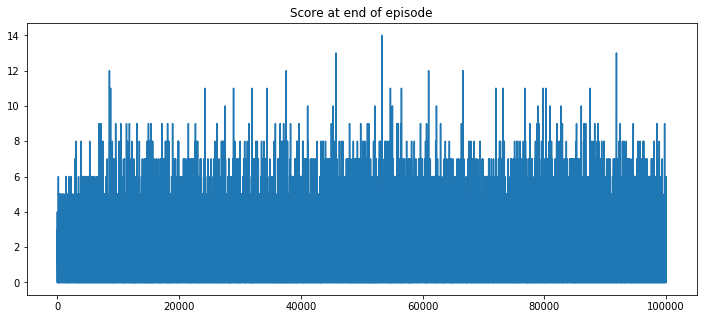

In [23]:
plt.figure(2,figsize=[12,5])
plt.title("Score at end of episode")
plt.plot(reward_total[:frames_total])
plt.show()

In [24]:
print("Average number of steps: {}". format(np.average(steps_total[:frames_total])))

Average number of steps: 228.65885


In [25]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average reward in last 100 episodes: {}". format(np.average(reward_total[frames_total-100:frames_total])))



Average number of steps=reward: 228.65885
Average reward in last 100 episodes: nan


/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

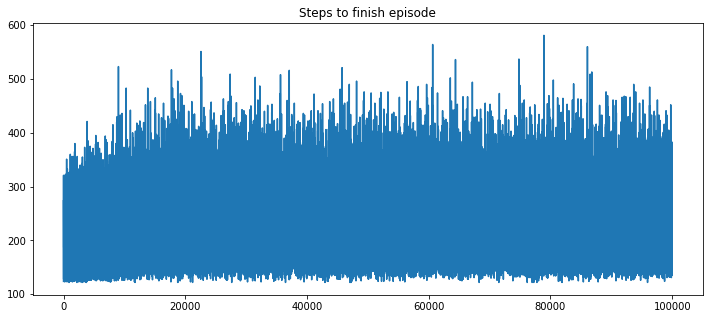

In [26]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total[:frames_total])
plt.show()